# Proyecto AA — Detección temprana de situaciones de trata de personas
**Ámbito:** Argentina (2020–2024) · **Foco adicional:** Tierra del Fuego (TDF)

**Objetivo.** Entrenar un **clasificador binario** (`es_trata` ∈ {0,1}) priorizando **Recall** para detección temprana. El modelo se entrena con **datos nacionales** y se reporta **transferencia** a TDF como análisis extra (no exclusivo).

**Alcance y criterio operativo.**
- Validación **temporal** (split sin fugas) + **umbral** elegido por **curva Precision–Recall** (restricción: *recall ≥ 0.80*).
- Se comparan **Logistic Regression (con interacciones)** y **HistGradientBoosting** (versión calibrada).  
- Se incluye **backtesting mensual (rolling origin)**, **calibración de probabilidades** y **interpretabilidad** (Permutation Importance + SHAP).

**Consigna incorporada.**
- Analizar la relación entre **mes/temporada** y **anonimato** con `es_trata` (tablas con %fila/%col + **χ²**).  
- Incluir **interacciones** en el modelo: `temporada×anonimato`, `provincia×anonimato`, `nacionalidad×temporada`.  
- Reportar métricas y lectura de efectos.

**Datos y modificaciones manuales (trazabilidad breve).**
- Se **elimina** `hora_ingreso` (columna sin datos en todas las filas).  
- Se **construye** la etiqueta binaria **`es_trata`** (variable objetivo).  
- Se **completan/normalizan**: `consultante_nacionalidad`, `consultante_provincia`, `consultante_localidad`  
  (mapear por `provincia_indec_id` cuando exista; normalizar a minúsculas/sin tildes; fallback `sin_descripcion`).  
- Guardar en `results/`: `nulos_antes.csv`, `nulos_despues.csv`, auditorías antes→después de esas columnas.

**Reproducibilidad.**
- `random_state = 42` en todos los pasos con aleatoriedad.
- Versiones sugeridas: **Python 3.11**, **pandas 2.2+**, **scikit-learn 1.4+**, **numpy 1.26+**, **matplotlib 3.8+**, **shap 0.45+**.
- Estructura de carpetas (paths relativos): `data/`, `figs/`, `results/`, `outputs/`.  
  - Figuras clave (PR/ROC/CM, heatmaps, Top-K, series mensuales) → `figs/`  
  - Métricas/umbrales/tablas (CSV/JSON) → `results/`  
  - Series finales / export de usuario → `outputs/`


## Configuración y reproducibilidad

In [11]:
# Configuración
RANDOM_STATE = 42
TARGET_RECALL = 0.80

import warnings
warnings.filterwarnings("ignore")

import os, re, json, unicodedata
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

# Estadística / ML
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_recall_curve, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix
)

# Gráficos (matplotlib, sin seaborn)
import matplotlib.pyplot as plt


##Importaciones, rutas y carga del CSV curado
Defino las rutas y elijo el CSV de trabajo. Uso el dataset curado como fuente canon. Si no se encuentra exactamente, busco por patrón.

In [12]:
from pathlib import Path
import glob
import pandas as pd

# --- Encontrar SIEMPRE la raíz del repo mirando .git ---
def repo_root_from_git(start: Path | None = None, max_up: int = 10) -> Path:
    cur = (start or Path.cwd()).resolve()
    for _ in range(max_up):
        if (cur / ".git").exists():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    return (start or Path.cwd()).resolve()

ROOT = repo_root_from_git()
print("ROOT:", ROOT)

# --- Carpetas estándar RELATIVAS A LA RAÍZ ---
DATA = ROOT / "data"
DATA_CURATED = DATA / "curated"
DATA_CURADO_ES = DATA / "curado"   # por si alguna entrega quedó así

for p in [DATA, DATA_CURATED]:
    p.mkdir(parents=True, exist_ok=True)

# Nombre exacto de tu entrega 2 (si existe, se usa; si no, se toma el .csv más grande)
CURATED_NAME = "data_curateddatasetoficina-rescate-orientaciones-202001-202308.csv"

def pick_csv_curated() -> Path:
    preferred = DATA_CURATED / CURATED_NAME
    if preferred.exists():
        return preferred

    # Buscar en data/curated y data/curado (español)
    cands = list(DATA_CURATED.glob("*.csv")) + list(DATA_CURADO_ES.glob("*.csv"))

    # Último recurso: buscar por patrón en todo el repo
    if not cands:
        patt = str(ROOT / "**" / "*oficina-rescate-orientaciones-202001-202308*.csv")
        cands = [Path(p) for p in glob.glob(patt, recursive=True)]

    if not cands:
        raise FileNotFoundError(
            f"No encuentro CSV en {DATA_CURATED}. Copiá tu .csv ahí "
            f"(puede llamarse distinto; se tomará el más grande)."
        )
    # Tomar el más grande (suele ser el correcto)
    return max(set(cands), key=lambda p: p.stat().st_size)

CSV_PATH = pick_csv_curated()
print("CSV_PATH:", CSV_PATH.relative_to(ROOT))

df = pd.read_csv(CSV_PATH, low_memory=False, encoding="utf-8")
print("Shape:", df.shape)
df.head(3)


ROOT: C:\aprendizajeAutomatico\repo\deteccion_trata\deteccionTrata
CSV_PATH: data\curated\data_curateddatasetoficina-rescate-orientaciones-202001-202308.csv
Shape: (7853, 20)


,fecha_ingreso,nro_registro_interno,situacion,origen,es_anonima,tema,es_trata,subtema,provincia,localidad,dependencia_alta,via_ingreso,consultante_nacionalidad,consultante_provincia,consultante_localidad,consultante_tipo,consultante_como_conocio_la_linea,consultante_genero,consultante_edad_aparente,provincia_indec_id
0,2020-01-01,1584554505,Urgencia,Ciudadano,No,Trata,1.0,Persona desaparecida,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,PNR - Línea 145,Línea 145,Argentina,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Consultante - ciudadano,NaN,Mujer,25.0,2.0
1,2020-01-02,4584554505,Urgencia,Ciudadano,No,Relaciones de familia,0.0,Deberes de responsabilidad parental o familiar,Jujuy,San Salvador de Jujuy,PNR - Línea 145,Línea 145,Bolivia,Jujuy,San Salvador de Jujuy,Consultante - ciudadano,NaN,Mujer,NaN,38.0
2,2020-01-02,5584554505,Urgencia,Ciudadano,Si,Trata,1.0,Explotación sexual,Buenos Aires,Buenos Aires,PNR - Línea 145,Línea 145,NaN,NaN,NaN,Consultante - ciudadano,NaN,Mujer,NaN,6.0


##Preparación temporal y espacial

Normalizo nombres de columnas, genero anio, mes, trimestre y limpio consultante_nacionalidad, consultante_provincia, consultante_localidad.

In [13]:
import pandas as pd

# Normalizar nombres de columnas (sin .str.normalize para máxima compatibilidad)
import unicodedata
def _norm_cols(s):
    s = str(s).strip().lower()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.replace(" ", "_")
    return s

df.columns = [ _norm_cols(c) for c in df.columns ]


# Columnas temporales
if not {"anio","mes"}.issubset(df.columns):
    posibles_fechas = [c for c in df.columns if "fecha" in c]
    if not posibles_fechas:
        raise ValueError("No encontré columna de fecha para derivar anio/mes. Indicá FECHA_COL.")
    FECHA_COL = posibles_fechas[0]
    df[FECHA_COL] = pd.to_datetime(df[FECHA_COL], errors="coerce", dayfirst=True)
    df["anio"] = df[FECHA_COL].dt.year
    df["mes"]  = df[FECHA_COL].dt.month

df["trimestre"] = ((df["mes"] - 1) // 3 + 1).astype("Int64")

# Limpieza de variables de lugar
def _clean_str(s):
    if pd.isna(s): return pd.NA
    s = str(s).strip().lower()
    s = s.encode("ascii", "ignore").decode("utf-8")
    return " ".join(w.capitalize() for w in s.split())

for c in ["consultante_nacionalidad", "consultante_provincia", "consultante_localidad"]:
    if c in df.columns:
        df[c] = df[c].apply(_clean_str).astype("string")

# Normalizaciones puntuales
if "consultante_provincia" in df.columns:
    df["consultante_provincia"] = df["consultante_provincia"].replace({
        "Tierra Del Fuego, Antartida E Islas Del Atlantico Sur": "Tierra Del Fuego",
        "Tierra De Fuego": "Tierra Del Fuego",
        "T Del Fuego": "Tierra Del Fuego",
    })
if "consultante_localidad" in df.columns:
    df["consultante_localidad"] = df["consultante_localidad"].replace({
        "Río Grande": "Rio Grande"
    })

# Tipos
for c in ["anio","mes","trimestre"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

print("Shape post prep:", df.shape)
df.head(5)



Shape post prep: (7853, 23)


,fecha_ingreso,nro_registro_interno,situacion,origen,es_anonima,tema,es_trata,subtema,provincia,localidad,...,consultante_provincia,consultante_localidad,consultante_tipo,consultante_como_conocio_la_linea,consultante_genero,consultante_edad_aparente,provincia_indec_id,anio,mes,trimestre
0,2020-01-01,1584554505,Urgencia,Ciudadano,No,Trata,1.0,Persona desaparecida,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,...,Ciudad Autnoma De Buenos Aires,Ciudad Autnoma De Buenos Aires,Consultante - ciudadano,NaN,Mujer,25.0,2.0,2020,1,1
1,2020-02-01,4584554505,Urgencia,Ciudadano,No,Relaciones de familia,0.0,Deberes de responsabilidad parental o familiar,Jujuy,San Salvador de Jujuy,...,Jujuy,San Salvador De Jujuy,Consultante - ciudadano,NaN,Mujer,NaN,38.0,2020,2,1
2,2020-02-01,5584554505,Urgencia,Ciudadano,Si,Trata,1.0,Explotación sexual,Buenos Aires,Buenos Aires,...,<NA>,<NA>,Consultante - ciudadano,NaN,Mujer,NaN,6.0,2020,2,1
3,2020-02-01,6584554505,Urgencia,Ciudadano,Si,Violencia de género,0.0,Económica,Salta,Salta,...,<NA>,<NA>,Consultante,"No sabe, no recuerda",Mujer,NaN,66.0,2020,2,1
4,2020-02-01,7584554505,Urgencia,Ciudadano,Si,Trata,1.0,Explotación sexual,Buenos Aires,Campana,...,<NA>,<NA>,Consultante,"No sabe, no recuerda",Mujer,NaN,NaN,2020,2,1


##Construcción robusta de es_trata

Normalize y/o derive la etiqueta es_trata (0/1) a partir de valores heterogéneos o, si falta, desde tema.

In [14]:
import re, unicodedata
import numpy as np
import pandas as pd

def norm_text(series: pd.Series) -> pd.Series:
    s = series.fillna("").astype(str).str.lower().str.strip()
    return s.apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii','ignore').decode('utf-8'))

def to_bin_es_trata(s):
    s = "" if pd.isna(s) else str(s).strip().lower().replace(',', '.')
    if re.fullmatch(r'1(\.0+)?', s): return 1
    if re.fullmatch(r'0(\.0+)?', s): return 0
    if s in {'si','sí','true','t','y','yes'}: return 1
    if s in {'no','false','f','n'}: return 0
    return None

if 'es_trata' in df.columns:
    df['es_trata'] = df['es_trata'].map(to_bin_es_trata).astype('Int64')
    n_null = int(df['es_trata'].isna().sum())
    if n_null > 0:
        print(f'Aviso: {n_null} filas sin etiqueta clara en es_trata → se eliminan para modelado.')
        df = df[df['es_trata'].notna()].copy()
    df['es_trata'] = df['es_trata'].astype(int)
elif 'tema' in df.columns:
    df['tema_norm'] = norm_text(df['tema'])
    df['es_trata'] = df['tema_norm'].str.contains(r'(^|\W)trata(\W|$)', regex=True).astype(int)
    df.drop(columns=['tema_norm'], inplace=True)
else:
    raise ValueError("Falta 'es_trata' o 'tema' para construir la etiqueta.")

print(df['es_trata'].value_counts(dropna=False))


Aviso: 5 filas sin etiqueta clara en es_trata → se eliminan para modelado.
es_trata
1    4241
0    3607
Name: count, dtype: int64


##ETL — Limpieza e imputación
Limpia categóricas, valida edad, agrega derivadas (temporada, dia_semana, fin_de_semana) y controla cardinalidad.

In [15]:
import numpy as np
import pandas as pd
import unicodedata

# Fallback por si norm_text no quedó definido en la Celda 3
if "norm_text" not in globals():
    def norm_text(series: pd.Series) -> pd.Series:
        s = series.astype(str).str.strip().str.lower()
        def _strip_acc(x):
            x = unicodedata.normalize("NFKD", x)
            return "".join(ch for ch in x if not unicodedata.combining(ch))
        return s.apply(_strip_acc)

# Aliases por si vinieran columnas antiguas
if 'provincia' in df.columns and 'consultante_provincia' not in df.columns:
    df = df.rename(columns={'provincia': 'consultante_provincia'})
if 'localidad' in df.columns and 'consultante_localidad' not in df.columns:
    df = df.rename(columns={'localidad': 'consultante_localidad'})

# Remover columnas no usadas (si existen)
for col_drop in ['hora_ingreso']:
    if col_drop in df.columns:
        df = df.drop(columns=[col_drop])

# Categóricas clave (normalización básica)
cat_cols = [
    'subtema','via_ingreso','origen','consultante_tipo','consultante_genero','es_anonima',
    'consultante_nacionalidad','consultante_provincia','consultante_localidad'
]
for c in cat_cols:
    if c in df.columns:
        df[c] = norm_text(df[c]).replace({'nan': 'desconocido'})

#Edad: validación + imputación por mediana
if 'consultante_edad_aparente' in df.columns:
    df['consultante_edad_aparente'] = pd.to_numeric(df['consultante_edad_aparente'], errors='coerce')
    df.loc[(df['consultante_edad_aparente']<=0)|(df['consultante_edad_aparente']>100),'consultante_edad_aparente'] = np.nan
    if df['consultante_edad_aparente'].notna().any():
        df['consultante_edad_aparente'] = df['consultante_edad_aparente'].fillna(df['consultante_edad_aparente'].median())

#  Derivadas extra de tiempo
# 1) Temporada desde 'mes' (si existe)
if 'mes' in df.columns:
    temporada = {12:'verano',1:'verano',2:'verano',3:'otonio',4:'otonio',5:'otonio',
                 6:'invierno',7:'invierno',8:'invierno',9:'primavera',10:'primavera',11:'primavera'}
    df['temporada'] = df['mes'].map(temporada).fillna('desconocido')

# 2) Asegurar que 'fecha_ingreso' sea datetime ANTES de usar .dt (parche clave)
if 'fecha_ingreso' in df.columns:
    df['fecha_ingreso'] = pd.to_datetime(df['fecha_ingreso'], errors='coerce', dayfirst=True)
    df['dia_semana'] = df['fecha_ingreso'].dt.dayofweek
    df['fin_de_semana'] = (df['dia_semana'] >= 5).map({True:'si', False:'no'})

# Normalizaciones puntuales de provincia/localidad
if "consultante_provincia" in df.columns:
    df["consultante_provincia"] = df["consultante_provincia"].replace({
        "tierra del fuego, antartida e islas del atlantico sur": "tierra del fuego",
        "tierra de fuego": "tierra del fuego",
        "t del fuego": "tierra del fuego"
    })

if "consultante_localidad" in df.columns:
    # unificar acentos frecuentes
    df["consultante_localidad"] = df["consultante_localidad"].replace({
        "rio grande": "rio grande"
    })

# Cardinalidad: colapsar categorías muy raras en 'subtema'
if 'subtema' in df.columns:
    min_count = 20
    vc = df['subtema'].value_counts(dropna=False)
    raros = vc[vc < min_count].index
    df['subtema'] = df['subtema'].where(~df['subtema'].isin(raros), f'otros_≤{min_count}')

# Fix finales de tipo/string en categóricas
cat_cols_fix = [
    'subtema','via_ingreso','origen','consultante_tipo','consultante_genero',
    'es_anonima','temporada','fin_de_semana',
    'consultante_nacionalidad','consultante_provincia','consultante_localidad'
]
for c in cat_cols_fix:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.lower().replace({'nan':'desconocido'})

# Normalización específica de 'es_anonima'
if 'es_anonima' in df.columns:
    def norm_anon(x):
        x = str(x).strip().lower().replace('sí','si')
        if x in {'1','1.0','true','t','y','yes','si','s'}:  return 'si'
        if x in {'0','0.0','false','f','n','no'}:           return 'no'
        return x if x else 'desconocido'
    df['es_anonima'] = df['es_anonima'].apply(norm_anon)

print("ETL OK. Columnas temporales presentes:",
      [c for c in ['mes','anio','temporada','trimestre','dia_semana','fin_de_semana'] if c in df.columns])
df.head(3)


ETL OK. Columnas temporales presentes: ['mes', 'anio', 'temporada', 'trimestre', 'dia_semana', 'fin_de_semana']


,fecha_ingreso,nro_registro_interno,situacion,origen,es_anonima,tema,es_trata,subtema,provincia,localidad,...,consultante_como_conocio_la_linea,consultante_genero,consultante_edad_aparente,provincia_indec_id,anio,mes,trimestre,temporada,dia_semana,fin_de_semana
0,2020-01-01,1584554505,Urgencia,ciudadano,no,Trata,1,persona desaparecida,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,...,NaN,mujer,25.0,2.0,2020,1,1,verano,2.0,no
1,2020-02-01,4584554505,Urgencia,ciudadano,no,Relaciones de familia,0,deberes de responsabilidad parental o familiar,Jujuy,San Salvador de Jujuy,...,NaN,mujer,45.0,38.0,2020,2,1,verano,5.0,si
2,2020-02-01,5584554505,Urgencia,ciudadano,si,Trata,1,explotacion sexual,Buenos Aires,Buenos Aires,...,NaN,mujer,45.0,6.0,2020,2,1,verano,5.0,si


##QA (controles de calidad)
Muestra forma, nulos principales, duplicados por ids comunes y distribución del target.

In [16]:
print("Forma final:", df.shape)
print("\nNulos por columna (top 15):")
display(df.isna().sum().sort_values(ascending=False).head(15))

for key in ["id","id_caso","id_intervencion"]:
    if key in df.columns:
        dups = df.duplicated(subset=[key]).sum()
        print(f"Duplicados por {key}:", dups)

print("\nDistribución de es_trata:")
display(df['es_trata'].value_counts(normalize=True).rename('prop').round(3))


Forma final: (7848, 26)

Nulos por columna (top 15):


consultante_como_conocio_la_linea    6806
fecha_ingreso                        4754
mes                                  4754
anio                                 4754
dia_semana                           4754
trimestre                            4754
localidad                            3190
provincia_indec_id                   2759
provincia                            2737
situacion                              10
es_trata                                0
subtema                                 0
es_anonima                              0
tema                                    0
origen                                  0
dtype: int64


Distribución de es_trata:


es_trata
1    0.54
0    0.46
Name: prop, dtype: float64

##Relevamientos temporales (tablas)
Objetivo: construir tablas por año-mes y por año con: total de intervenciones, confirmadas (es_trata) y tasa = confirmadas/total.

In [17]:
import pandas as pd
import numpy as np

df_tmp = df.copy()

# Normalización de columnas temporales
# Si no existen 'anio' y 'mes', las derivamos desde 'fecha'
cols = {c.lower(): c for c in df_tmp.columns}  # mapa case-insensitive
if 'anio' not in cols or 'mes' not in cols:
    # Detectamos 'fecha' con nombre flexible
    cand = [c for c in df_tmp.columns if c.lower() in ('fecha','fecharegistro','fecha_hecho','fecha_caso')]
    if not cand:
        raise ValueError("No encuentro columnas 'anio'/'mes' ni alguna 'fecha' para derivarlas.")
    col_fecha = cand[0]
    df_tmp[col_fecha] = pd.to_datetime(df_tmp[col_fecha], errors='coerce')
    if df_tmp[col_fecha].isna().all():
        raise ValueError(f"No se pudo parsear la columna de fecha: '{col_fecha}'")
    df_tmp['anio'] = df_tmp[col_fecha].dt.year
    df_tmp['mes']  = df_tmp[col_fecha].dt.month
else:
    # Homogeneizamos nombres exactos
    df_tmp.rename(columns={cols.get('anio','anio'): 'anio',
                           cols.get('mes','mes'): 'mes'}, inplace=True)

# 3) Normalización de 'es_trata' a 0/1
#    Acepta bool, 0/1, o textos tipo "si/no", "sí/no", "true/false".
if 'es_trata' not in df_tmp.columns:
    # Intento con nombres cercanos
    candidatos = [c for c in df_tmp.columns if c.lower() in ('trata','confirmada','es_trata','es_trafico')]
    if not candidatos:
        raise ValueError("No encuentro columna 'es_trata' (o similar).")
    df_tmp.rename(columns={candidatos[0]: 'es_trata'}, inplace=True)

def a_binario(x):
    if pd.isna(x): return 0
    if isinstance(x, (bool, np.bool_)): return int(x)
    try:
        # si es número 0/1
        f = float(x)
        return int(f != 0)
    except Exception:
        s = str(x).strip().lower()
        if s in ('si','sí','true','t','s','y','yes','1'): return 1
        if s in ('no','false','f','n','0'): return 0
        return 0  # default
df_tmp['es_trata'] = df_tmp['es_trata'].map(a_binario).astype(int)

# 4) Tablas: mensual (anio, mes) y anual (anio)
tabla_mensual = (
    df_tmp.groupby(['anio','mes'])
          .agg(total=('es_trata','size'),
               confirmadas=('es_trata','sum'))
          .assign(tasa=lambda t: np.where(t['total']>0, t['confirmadas']/t['total'], 0.0))
          .reset_index()
          .sort_values(['anio','mes'], ascending=True)
)

tabla_anual = (
    df_tmp.groupby(['anio'])
          .agg(total=('es_trata','size'),
               confirmadas=('es_trata','sum'))
          .assign(tasa=lambda t: np.where(t['total']>0, t['confirmadas']/t['total'], 0.0))
          .reset_index()
          .sort_values('anio')
)

# 5) (Opcional) columnas amigables y tasa en %
tabla_mensual['tasa_%'] = (tabla_mensual['tasa']*100).round(2)
tabla_anual['tasa_%']   = (tabla_anual['tasa']*100).round(2)

# 6) Vista rápida
print("Tabla mensual (primeras filas):")
display(tabla_mensual.head(12))
print("Tabla anual:")
display(tabla_anual)



Tabla mensual (primeras filas):


,anio,mes,total,confirmadas,tasa,tasa_%
0,2020,1,46,13,0.282609,28.26
1,2020,2,44,24,0.545455,54.55
2,2020,3,42,22,0.523810,52.38
3,2020,4,52,29,0.557692,55.77
4,2020,5,55,29,0.527273,52.73
5,2020,6,47,19,0.404255,40.43
6,2020,7,43,17,0.395349,39.53
7,2020,8,30,15,0.500000,50.00
8,2020,9,48,22,0.458333,45.83
9,2020,10,40,24,0.600000,60.00


Tabla anual:


,anio,total,confirmadas,tasa,tasa_%
0,2020,514,250,0.486381,48.64
1,2021,583,321,0.550600,55.06
2,2022,534,292,0.546816,54.68
3,2023,694,388,0.559078,55.91
4,2024,769,406,0.527958,52.80


##Gráficos temporales
Gráficos de barras por año, año-mes y año–trimestre (guarda PNGs).

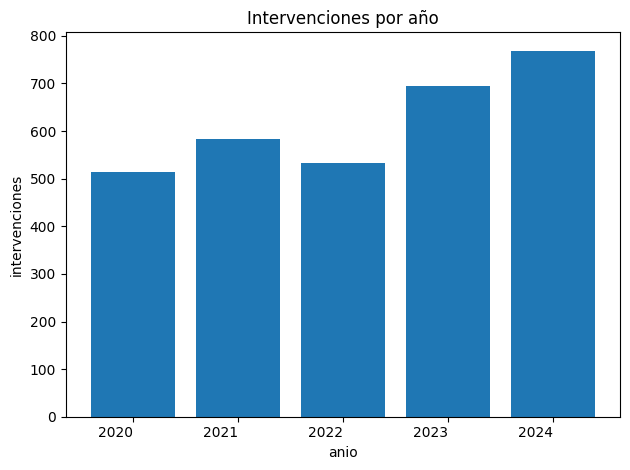

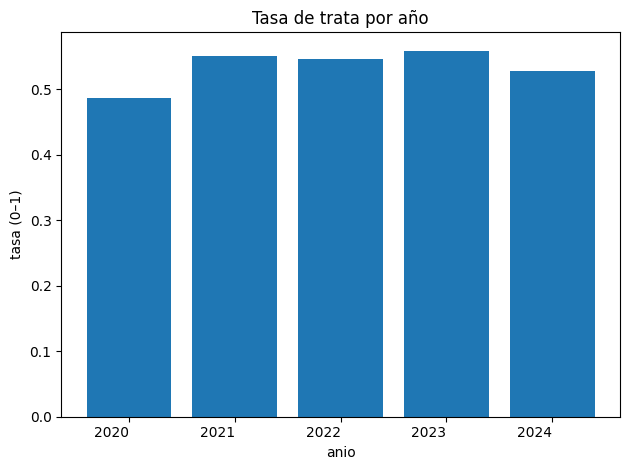

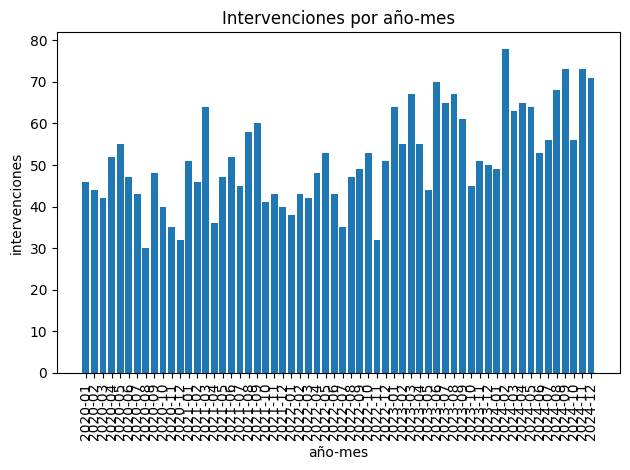

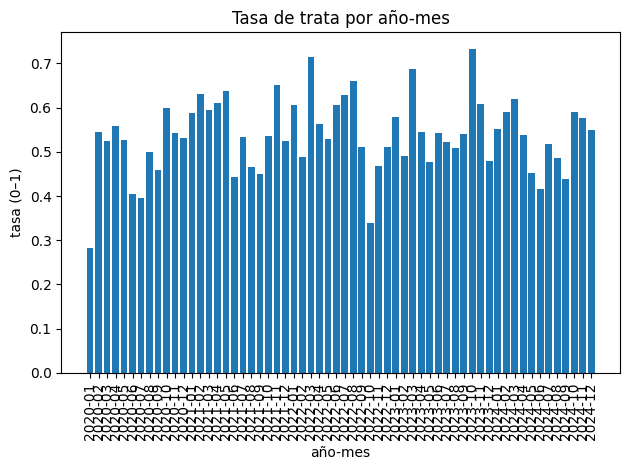

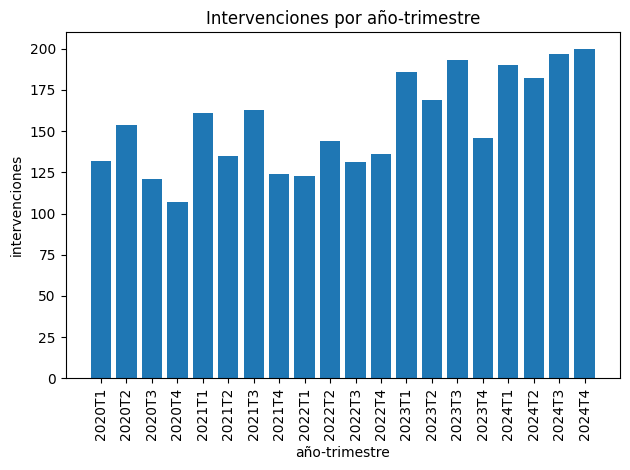

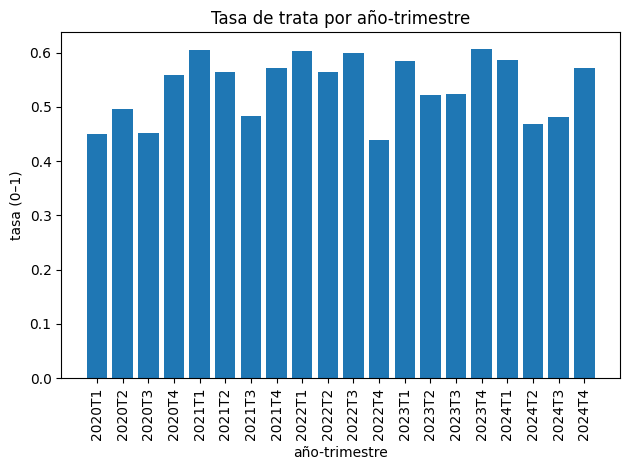

In [18]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

Path("figs").mkdir(parents=True, exist_ok=True)

# Helper de barras
def plot_bar(df, x, y, title, fname, rotation=0, ylabel=None, xlabel=None):
    plt.figure()
    plt.bar(df[x].astype(str), df[y])
    plt.title(title)
    plt.xlabel(xlabel if xlabel else x)
    plt.ylabel(ylabel if ylabel else y)
    plt.xticks(rotation=rotation, ha="right")
    plt.tight_layout()
    plt.savefig(f"figs/{fname}", dpi=150)
    plt.show()

# Derivaciones para gráficos

# 1) Año: total y tasa
por_anio = (
    tabla_anual
      .rename(columns={"total":"intervenciones", "tasa":"tasa_trata"})
      .loc[:, ["anio","intervenciones","tasa_trata"]]
      .sort_values("anio")
)

# 2) Mes (dentro de cada año): total y tasa
por_mes = (
    tabla_mensual
      .rename(columns={"total":"intervenciones", "tasa":"tasa_trata"})
      .loc[:, ["anio","mes","intervenciones","tasa_trata"]]
      .sort_values(["anio","mes"])
)

# 3) Trimestre: si no existe, lo calculamos desde tabla_mensual
#    (trimestre = 1..4 en base a mes)
por_trim = por_mes.copy()
por_trim["trimestre"] = ((por_trim["mes"] - 1) // 3 + 1).astype(int)
por_trim = (
    por_trim.groupby(["anio","trimestre"], as_index=False)
            .agg(intervenciones=("intervenciones","sum"),
                 tasa_trata=("tasa_trata","mean"))  # promedio de tasas en el trimestre
            .sort_values(["anio","trimestre"])
)

# Gráficos

# AÑO — intervenciones y tasa
plot_bar(por_anio, "anio", "intervenciones",
         "Intervenciones por año", "tmp_intervenciones_anio.png")
plot_bar(por_anio, "anio", "tasa_trata",
         "Tasa de trata por año", "tmp_tasa_trata_anio.png",
         ylabel="tasa (0–1)")

# MES — orden cronológico dentro de cada año
por_mes_plot = por_mes.sort_values(["anio","mes"]).copy()
labels_mes = por_mes_plot["anio"].astype(str) + "-" + por_mes_plot["mes"].astype(int).astype(str).str.zfill(2)

plt.figure()
plt.bar(labels_mes, por_mes_plot["intervenciones"])
plt.title("Intervenciones por año-mes")
plt.xlabel("año-mes")
plt.ylabel("intervenciones")
plt.xticks(rotation=90); plt.tight_layout()
plt.savefig("figs/tmp_intervenciones_anio_mes.png", dpi=150); plt.show()

plt.figure()
plt.bar(labels_mes, por_mes_plot["tasa_trata"])
plt.title("Tasa de trata por año-mes")
plt.xlabel("año-mes")
plt.ylabel("tasa (0–1)")
plt.xticks(rotation=90); plt.tight_layout()
plt.savefig("figs/tmp_tasa_trata_anio_mes.png", dpi=150); plt.show()

# TRIMESTRE — año/trimestre
por_trim_plot = por_trim.sort_values(["anio","trimestre"]).copy()
labels_trim = por_trim_plot["anio"].astype(str) + "T" + por_trim_plot["trimestre"].astype(int).astype(str)

plt.figure()
plt.bar(labels_trim, por_trim_plot["intervenciones"])
plt.title("Intervenciones por año-trimestre")
plt.xlabel("año-trimestre"); plt.ylabel("intervenciones")
plt.xticks(rotation=90); plt.tight_layout()
plt.savefig("figs/tmp_intervenciones_anio_trimestre.png", dpi=150); plt.show()

plt.figure()
plt.bar(labels_trim, por_trim_plot["tasa_trata"])
plt.title("Tasa de trata por año-trimestre")
plt.xlabel("año-trimestre"); plt.ylabel("tasa (0–1)")
plt.xticks(rotation=90); plt.tight_layout()
plt.savefig("figs/tmp_tasa_trata_anio_trimestre.png", dpi=150); plt.show()


##Relevamientos espaciales (tablas)
Tablas por nacionalidad, provincia, y por provincia×localidad; guarda CSVs.

In [19]:
import numpy as np
from pathlib import Path
Path("results").mkdir(exist_ok=True)

# Si venís usando 'df' en vez de 'df_tmp', cambiá esta línea:
base = df_tmp.copy()

# Por nacionalidad
por_nacionalidad = (
    base.groupby(["consultante_nacionalidad"])
        .agg(intervenciones=("es_trata", "size"),
             confirmadas=("es_trata", "sum"))
        .assign(tasa=lambda t: np.where(t["intervenciones"]>0,
                                        t["confirmadas"]/t["intervenciones"], 0.0))
        .reset_index()
        .sort_values("intervenciones", ascending=False)
)

# Por provincia
por_provincia = (
    base.groupby(["consultante_provincia"])
        .agg(intervenciones=("es_trata", "size"),
             confirmadas=("es_trata", "sum"))
        .assign(tasa=lambda t: np.where(t["intervenciones"]>0,
                                        t["confirmadas"]/t["intervenciones"], 0.0))
        .reset_index()
        .sort_values("intervenciones", ascending=False)
)

# Por provincia + localidad
por_localidad = (
    base.groupby(["consultante_provincia","consultante_localidad"])
        .agg(intervenciones=("es_trata", "size"),
             confirmadas=("es_trata", "sum"))
        .assign(tasa=lambda t: np.where(t["intervenciones"]>0,
                                        t["confirmadas"]/t["intervenciones"], 0.0))
        .reset_index()
        .sort_values(["consultante_provincia","intervenciones"], ascending=[True, False])
)

# Guardados
por_nacionalidad.to_csv("results/relevamiento_por_nacionalidad.csv", index=False, encoding="utf-8-sig")
por_provincia.to_csv("results/relevamiento_por_provincia.csv", index=False, encoding="utf-8-sig")
por_localidad.to_csv("results/relevamiento_por_localidad.csv", index=False, encoding="utf-8-sig")

# Filtros de estabilidad (tamaño mínimo)
MIN_PROV, MIN_LOC, MIN_NAC = 30, 15, 20

por_provincia_f    = por_provincia[por_provincia["intervenciones"]>=MIN_PROV].copy()
por_localidad_f    = por_localidad[por_localidad["intervenciones"]>=MIN_LOC].copy()
por_nacionalidad_f = por_nacionalidad[por_nacionalidad["intervenciones"]>=MIN_NAC].copy()

# Etiquetas de "sin dato"
for df_ in [por_provincia, por_provincia_f, por_localidad, por_localidad_f,
            por_nacionalidad, por_nacionalidad_f]:
    for c in ["consultante_provincia","consultante_localidad","consultante_nacionalidad"]:
        if c in df_.columns:
            df_[c] = df_[c].fillna("sin dato").replace({"<na>": "sin dato", "nan": "sin dato"})

# Vista rápida
display(por_provincia.head(10))



,consultante_provincia,intervenciones,confirmadas,tasa
0,,3154,1570,0.497781
1,buenos aires,1683,1000,0.594177
5,ciudad autnoma de buenos aires,756,415,0.548942
21,santa fe,310,172,0.554839
7,crdoba,295,174,0.589831
24,tucumn,211,98,0.464455
13,mendoza,177,108,0.610169
16,ro negro,138,45,0.326087
17,salta,132,81,0.613636
3,chaco,124,71,0.572581


In [20]:
# --- Chequeo rápido (opcional) ---
print("Tamaños antes vs. después del filtro:")
print("provincia   :", por_provincia.shape, "→", por_provincia_f.shape)
print("localidad   :", por_localidad.shape, "→", por_localidad_f.shape)
print("nacionalidad:", por_nacionalidad.shape, "→", por_nacionalidad_f.shape)

print("\nMuestra por_provincia_f:")
display(por_provincia_f.head(10))

print("\nMuestra por_localidad_f:")
display(por_localidad_f.head(10))

print("\nMuestra por_nacionalidad_f:")
display(por_nacionalidad_f.head(10))


Tamaños antes vs. después del filtro:
provincia   : (25, 4) → (23, 4)
localidad   : (407, 5) → (37, 5)
nacionalidad: (18, 4) → (5, 4)

Muestra por_provincia_f:


,consultante_provincia,intervenciones,confirmadas,tasa
0,,3154,1570,0.497781
1,buenos aires,1683,1000,0.594177
5,ciudad autnoma de buenos aires,756,415,0.548942
21,santa fe,310,172,0.554839
7,crdoba,295,174,0.589831
24,tucumn,211,98,0.464455
13,mendoza,177,108,0.610169
16,ro negro,138,45,0.326087
17,salta,132,81,0.613636
3,chaco,124,71,0.572581



Muestra por_localidad_f:


,consultante_provincia,consultante_localidad,intervenciones,confirmadas,tasa
0,,,3104,1546,0.498067
23,buenos aires,,1038,565,0.544316
43,buenos aires,buenos aires,173,137,0.791908
113,buenos aires,mar del plata,31,18,0.580645
95,buenos aires,la plata,24,22,0.916667
54,buenos aires,ciudad autnoma de buenos aires,23,5,0.217391
188,catamarca,,32,12,0.375000
197,chaco,,98,53,0.540816
206,chaco,resistencia,16,12,0.750000
207,chubut,,41,21,0.512195



Muestra por_nacionalidad_f:


,consultante_nacionalidad,intervenciones,confirmadas,tasa
0,,5937,3084,0.519454
3,argentina,1725,1089,0.631304
15,uruguay,105,20,0.190476
4,bolivia,22,17,0.772727
14,sin descripcion,20,16,0.800000


##Gráficos espaciales (Top K)
Barras horizontales Top K por provincias, localidades y nacionalidades (guarda PNGs).

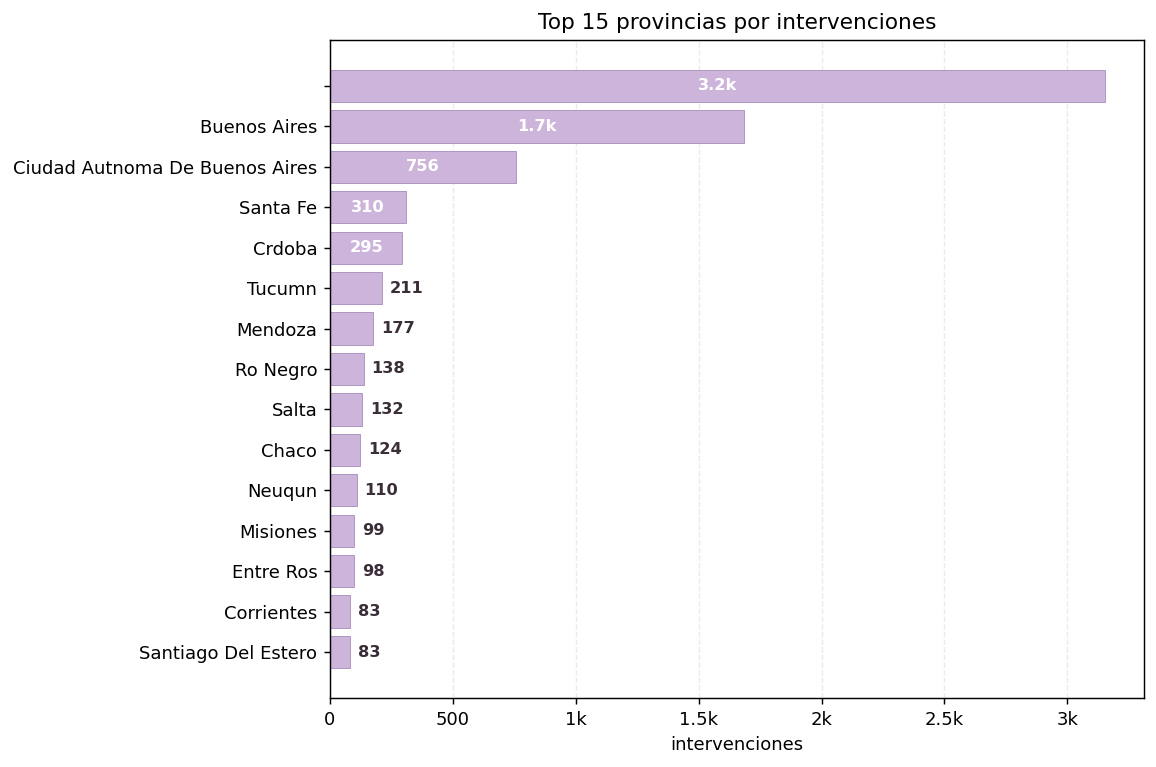

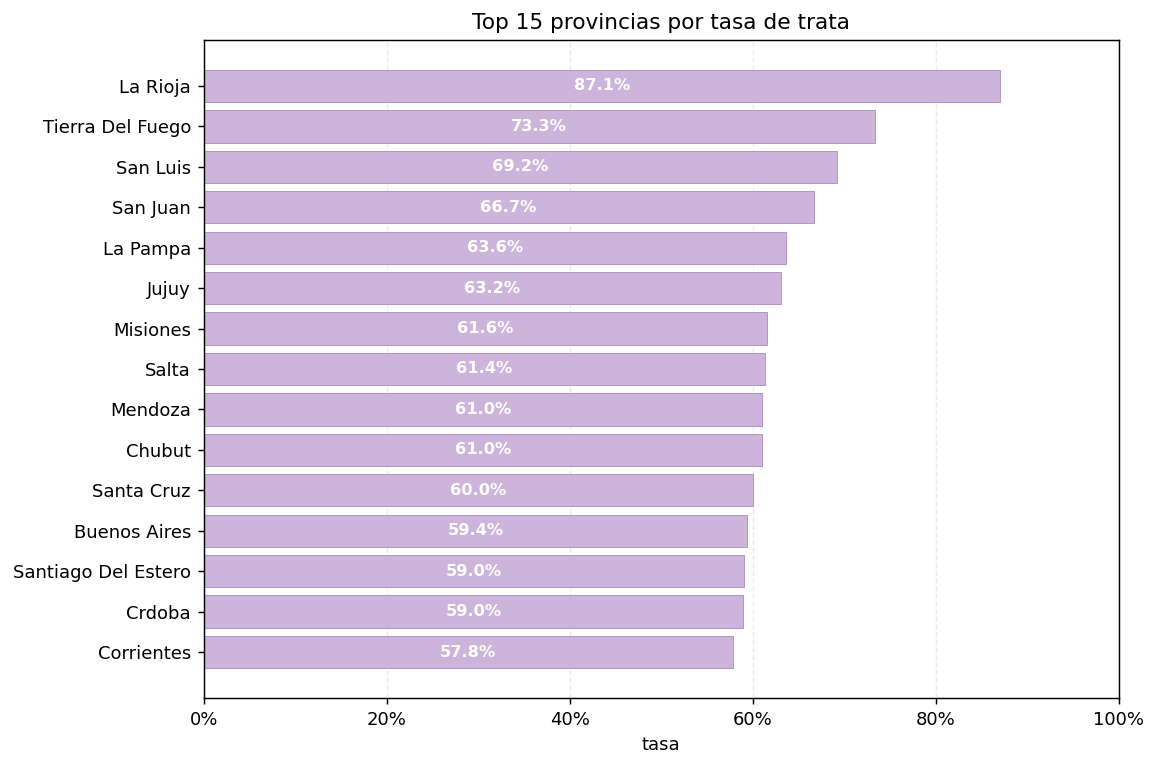

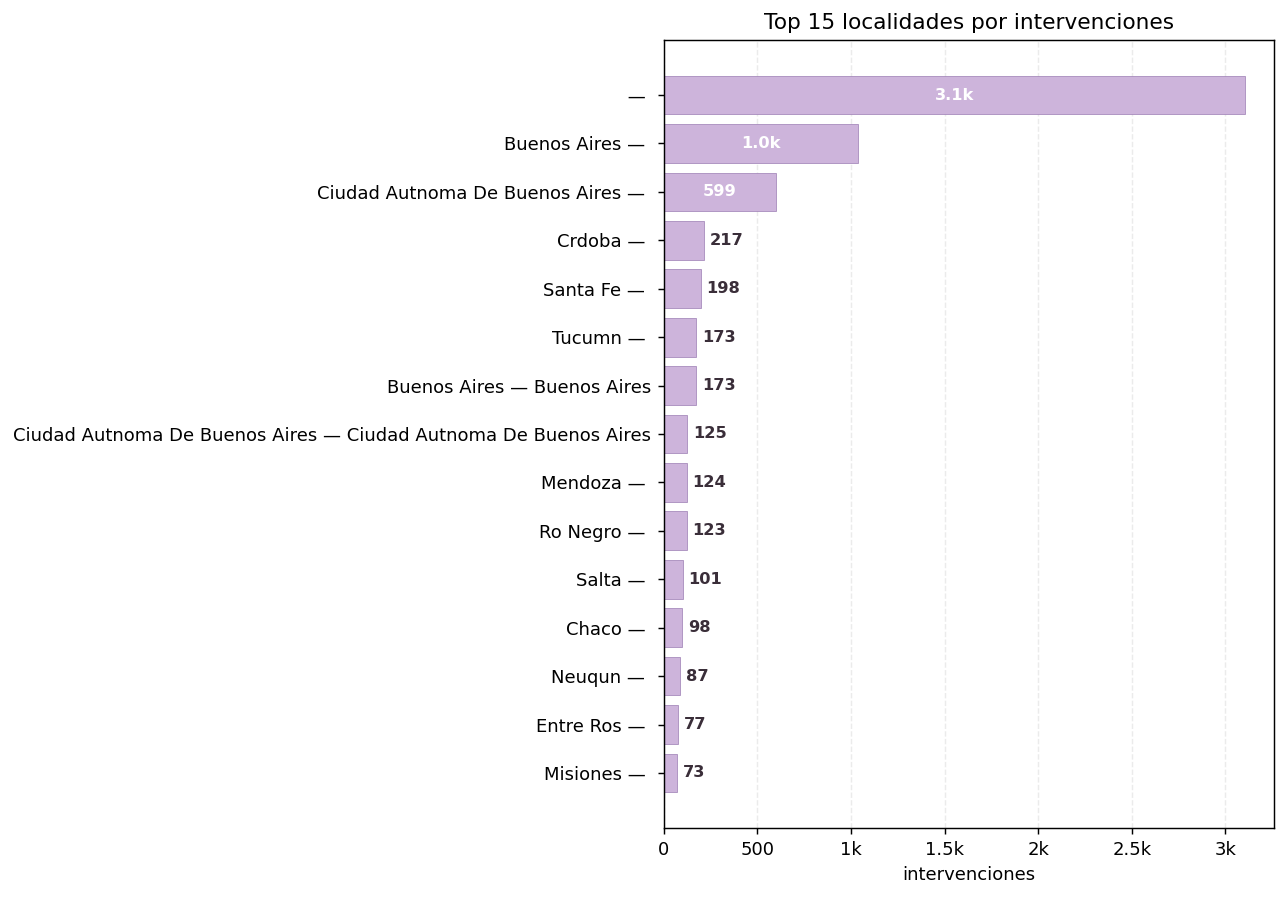

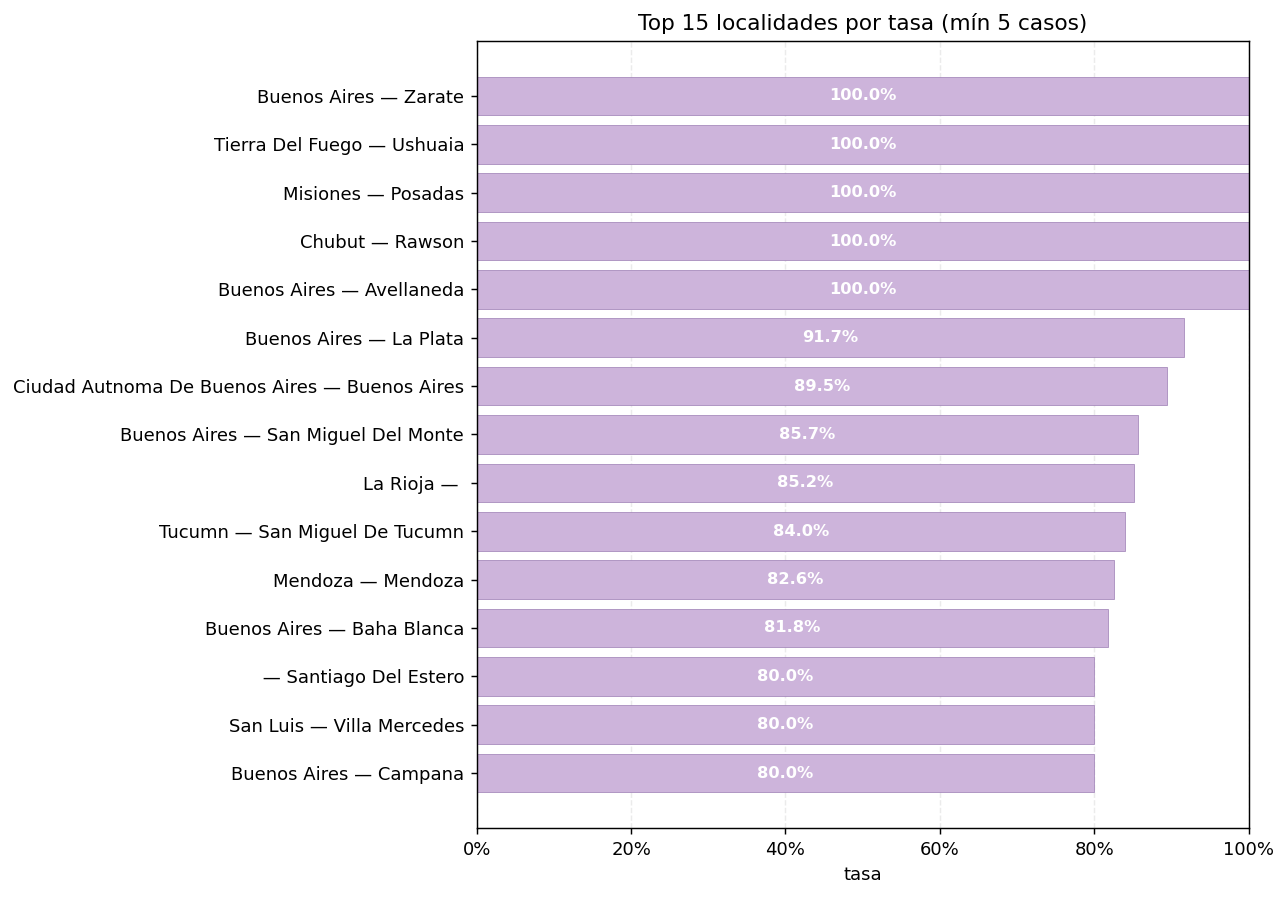

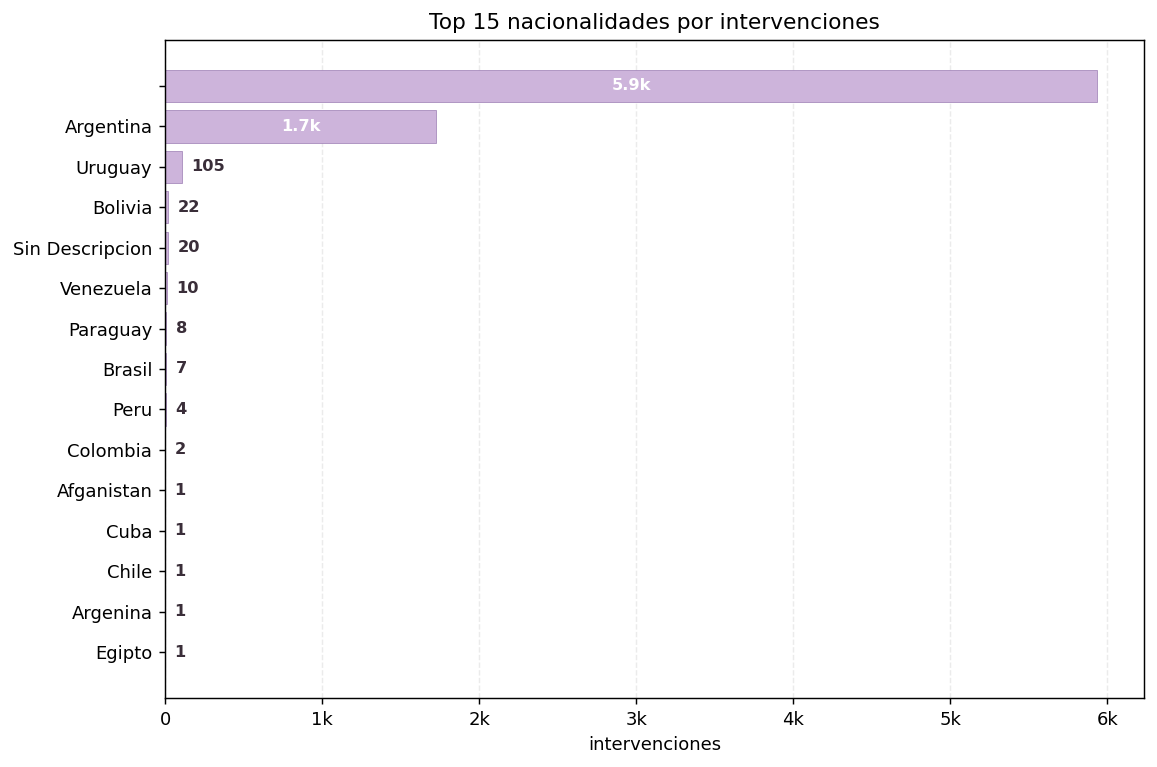

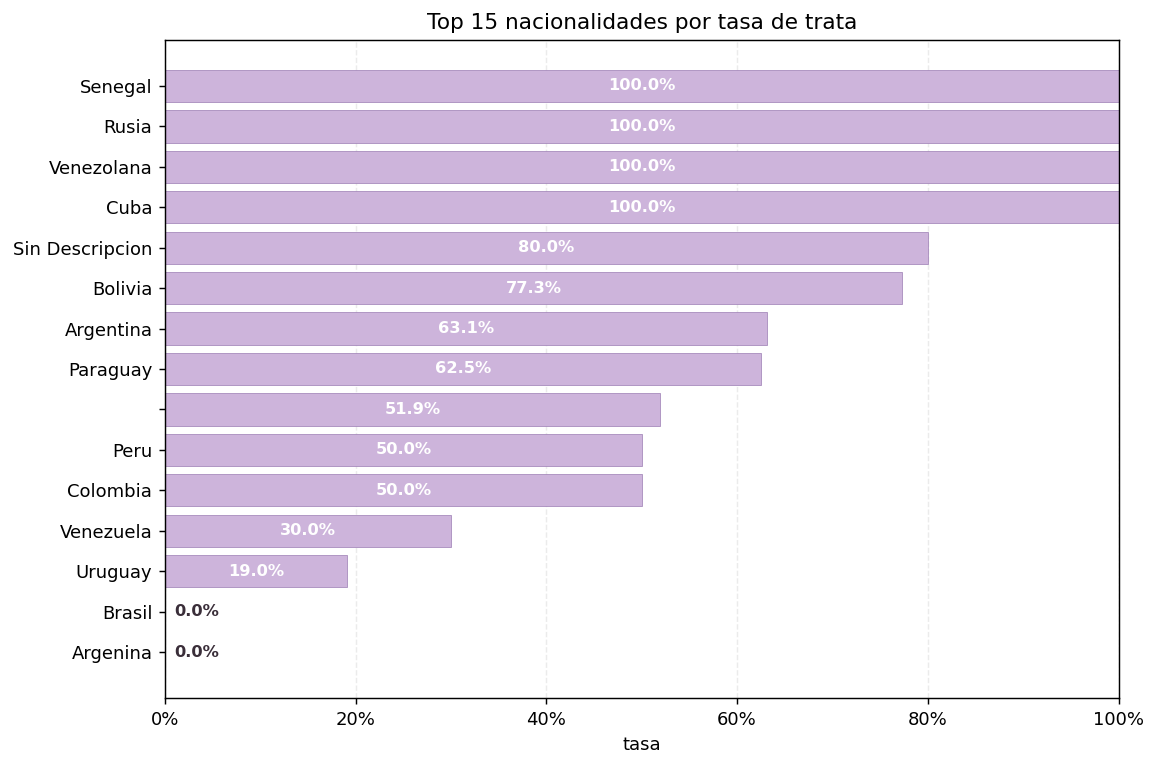

In [21]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path
Path("figs").mkdir(exist_ok=True)

# 1) Construyo dataframes de plot
def ensure_tables(base_df):
    # Si ya tenés por_provincia/por_localidad/por_nacionalidad, las uso
    if 'por_provincia' in globals() and 'por_localidad' in globals() and 'por_nacionalidad' in globals():
        pp, pl, pn = por_provincia.copy(), por_localidad.copy(), por_nacionalidad.copy()
    else:
        # Las creo rápido desde df_tmp (o df)
        dfb = base_df.copy()
        # normalizo es_trata
        if "es_trata" in dfb.columns:
            dfb["es_trata"] = pd.to_numeric(dfb["es_trata"], errors="coerce").fillna(0).astype(int)
        else:
            raise ValueError("No encuentro 'es_trata' en el DF base.")
        # por provincia
        pp = (dfb.groupby("consultante_provincia")
                    .agg(intervenciones=("es_trata","size"),
                         confirmadas=("es_trata","sum"))
                    .assign(tasa=lambda t: np.where(t["intervenciones"]>0, t["confirmadas"]/t["intervenciones"], 0.0))
                    .reset_index())
        # por localidad
        pl = (dfb.groupby(["consultante_provincia","consultante_localidad"])
                    .agg(intervenciones=("es_trata","size"),
                         confirmadas=("es_trata","sum"))
                    .assign(tasa=lambda t: np.where(t["intervenciones"]>0, t["confirmadas"]/t["intervenciones"], 0.0))
                    .reset_index())
        # por nacionalidad
        pn = (dfb.groupby("consultante_nacionalidad")
                    .agg(intervenciones=("es_trata","size"),
                         confirmadas=("es_trata","sum"))
                    .assign(tasa=lambda t: np.where(t["intervenciones"]>0, t["confirmadas"]/t["intervenciones"], 0.0))
                    .reset_index())
    return pp, pl, pn

# el DF maestro
base = globals().get("df_tmp", globals().get("df"))
if base is None:
    raise ValueError("No encuentro 'df_tmp' ni 'df' en memoria.")

pp, pl, pn = ensure_tables(base)

# renombro tasa → tasa_trata para ser consistente con celdas previas
prov_plot = pp.rename(columns={"tasa":"tasa_trata"}).copy()
loc_plot  = pl.rename(columns={"tasa":"tasa_trata"}).copy()
nac_plot  = pn.rename(columns={"tasa":"tasa_trata"}).copy()

# etiquetas prolijas
for col in ["consultante_provincia","consultante_localidad","consultante_nacionalidad"]:
    if col in prov_plot.columns: prov_plot[col] = prov_plot[col].astype(str).str.title()
    if col in loc_plot.columns:  loc_plot[col]  = loc_plot[col].astype(str).str.title()
    if col in nac_plot.columns:  nac_plot[col]  = nac_plot[col].astype(str).str.title()

loc_plot["prov_loc"] = loc_plot["consultante_provincia"] + " — " + loc_plot["consultante_localidad"]

# 2) Helper de gráfico
VIOLETA = "#CDB4DB"; BORDE="#9D7FB5"; TOPK=15; MIN_CASOS_LOC=5
fmt_k = lambda v: (f"{v/1000:.1f}k" if v>=1000 and (v/1000)%1 else (f"{int(v/1000)}k" if v>=1000 else f"{int(v)}"))
k_formatter   = FuncFormatter(lambda v, _: fmt_k(v))
pct_formatter = FuncFormatter(lambda v, _: f"{v:.0%}")

def barh_topk(df, label_col, value_col, title, fname, is_pct=False, xlabel=None, figsize=(9,6)):
    d = (df[[label_col, value_col]]
         .dropna()
         .sort_values(value_col, ascending=False)
         .head(TOPK)
         .iloc[::-1])
    if d.empty:
        print(f"[AVISO] Sin datos para {title}")
        return
    fig, ax = plt.subplots(figsize=figsize, dpi=130)
    bars = ax.barh(d[label_col].astype(str), d[value_col], color=VIOLETA, edgecolor=BORDE, linewidth=0.4)
    ax.set_title(title); ax.set_xlabel(xlabel if xlabel else value_col)
    ax.xaxis.grid(True, linestyle="--", alpha=0.25); ax.set_axisbelow(True)
    if is_pct:
        ax.set_xlim(0,1); ax.xaxis.set_major_formatter(pct_formatter)
    else:
        ax.xaxis.set_major_formatter(k_formatter)
    vmax = float(d[value_col].max())
    for rect, v in zip(bars, d[value_col].values):
        if is_pct:
            label=f"{v:.1%}"; inside = rect.get_width()>=0.08; x = rect.get_width()/2 if inside else rect.get_width()+0.01
        else:
            label=fmt_k(v);  inside = rect.get_width()>=vmax*0.08; x = rect.get_width()/2 if inside else rect.get_width()+vmax*0.01
        ax.text(x, rect.get_y()+rect.get_height()/2, label,
                va="center", ha=("center" if inside else "left"),
                color=("white" if inside else "#3A2E39"), fontsize=9, fontweight="bold")
    plt.tight_layout(); plt.savefig(f"figs/{fname}", dpi=150); plt.show()

# 3) Gráficos
# Provincias: intervenciones y tasa
barh_topk(prov_plot, "consultante_provincia", "intervenciones",
          f"Top {TOPK} provincias por intervenciones", "esp_top_provincias_int.png",
          is_pct=False, xlabel="intervenciones")

barh_topk(prov_plot, "consultante_provincia", "tasa_trata",
          f"Top {TOPK} provincias por tasa de trata", "esp_top_provincias_tasa.png",
          is_pct=True, xlabel="tasa")

# Localidades (acumulado por prov—loc)
barh_topk(loc_plot, "prov_loc", "intervenciones",
          f"Top {TOPK} localidades por intervenciones", "esp_top_localidades_int.png",
          is_pct=False, xlabel="intervenciones", figsize=(10,7))

loc_fil = loc_plot[loc_plot["intervenciones"] >= MIN_CASOS_LOC]
barh_topk(loc_fil, "prov_loc", "tasa_trata",
          f"Top {TOPK} localidades por tasa (mín {MIN_CASOS_LOC} casos)", "esp_top_localidades_tasa.png",
          is_pct=True, xlabel="tasa", figsize=(10,7))

# Nacionalidades
barh_topk(nac_plot, "consultante_nacionalidad", "intervenciones",
          f"Top {TOPK} nacionalidades por intervenciones", "esp_top_nacionalidades_int.png",
          is_pct=False, xlabel="intervenciones")

barh_topk(nac_plot, "consultante_nacionalidad", "tasa_trata",
          f"Top {TOPK} nacionalidades por tasa de trata", "esp_top_nacionalidades_tasa.png",
          is_pct=True, xlabel="tasa")


##Cruces espacio–tiempo (tablas)
Genera resúmenes por provincia×trimestre, nacionalidad×trimestre y localidad×trimestre; guarda CSVs.

In [22]:
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import display

Path("results").mkdir(exist_ok=True)

# Elegí el DF base (ajustá si tu variable se llama distinto)
base = df_tmp.copy()  # o df.copy()

# Aseguro anio/mes (si no existen, los creo desde 'fecha')
lower = {c.lower(): c for c in base.columns}

if "anio" not in lower or "mes" not in lower:
    cand = [c for c in base.columns if c.lower() in ("fecha","fecharegistro","fecha_hecho","fecha_caso")]
    if not cand:
        raise ValueError("No encuentro 'anio' y 'mes' ni una columna de 'fecha'.")
    col_fecha = cand[0]
    base[col_fecha] = pd.to_datetime(base[col_fecha], errors="coerce")
    base["anio"] = base[col_fecha].dt.year
    base["mes"]  = base[col_fecha].dt.month
else:
    # normalizo nombres exactos
    if lower["anio"] != "anio": base.rename(columns={lower["anio"]:"anio"}, inplace=True)
    if lower["mes"]  != "mes":  base.rename(columns={lower["mes"] :"mes"},  inplace=True)

# Normalizo 'mes' y creo 'trimestre' (permitiendo NA)
base["mes"] = pd.to_numeric(base["mes"], errors="coerce")
faltantes_mes = int(base["mes"].isna().sum())

base["trimestre"] = np.where(base["mes"].notna(), ((base["mes"] - 1)//3 + 1), np.nan)
base["trimestre"] = pd.Series(base["trimestre"]).round().astype("Int64")  # 1..4 o <NA>

#  Normalizo 'es_trata' a 0/1 seguro
def a_binario(x):
    if pd.isna(x): return 0
    if isinstance(x, (bool, np.bool_)): return int(x)
    s = str(x).strip().lower()
    if s in ("1","si","sí","true","t","y","yes"): return 1
    if s in ("0","no","false","f","n"): return 0
    try: return int(float(x) != 0)
    except Exception: return 0

if "es_trata" not in base.columns:
    raise ValueError("No encuentro la columna 'es_trata'.")

base["es_trata"] = base["es_trata"].map(a_binario).astype("Int64")

#  Diagnóstico rápido
print("=== Diagnóstico de fechas ===")
print(f"Filas totales: {len(base):,}".replace(",","."))
print(f"Filas con 'mes' faltante: {faltantes_mes:,}".replace(",","."))
print("Meses presentes:", sorted(base["mes"].dropna().unique().astype(int))[:12], "...")
print("Años presentes:", sorted(base["anio"].dropna().unique().astype(int)))
print()

# Si no hay mes en ninguna fila, marcamos Trimestre 'Desconocido' para no quedarnos sin salida
INCLUDE_DESCONOCIDO = True

base_ok = base.copy()
if base_ok["trimestre"].isna().all():
    if INCLUDE_DESCONOCIDO:
        print("Aviso: no hay 'mes' válido; se informará Trimestre='Desconocido'.")
        base_ok["trimestre"] = pd.Series([-1]*len(base_ok), dtype="Int64")
    else:
        print("No hay datos con 'mes' válido. No se generan cruces por trimestre.")
        display(base.head(5))

# Etiqueta de trimestre amigable
map_trim = {1:"T1", 2:"T2", 3:"T3", 4:"T4", -1:"Desconocido"}
base_ok["trimestre_lbl"] = base_ok["trimestre"].map(map_trim)

# Agregaciones vectorizadas (sin apply)
def tabla_xtiempo(df, keys):
    out = (df.groupby(keys)
             .agg(intervenciones=("es_trata","size"),
                  confirmadas=("es_trata","sum"))
             .assign(tasa=lambda t: np.where(t["intervenciones"]>0,
                                             t["confirmadas"]/t["intervenciones"], 0.0))
             .reset_index())
    return out

# Claves esperadas; si tus columnas se llaman distinto, renombrá antes
prov_trim = tabla_xtiempo(base_ok, ["consultante_provincia","anio","trimestre","trimestre_lbl"])\
              .sort_values(["consultante_provincia","anio","trimestre"])

nac_trim  = tabla_xtiempo(base_ok, ["consultante_nacionalidad","anio","trimestre","trimestre_lbl"])\
              .sort_values(["consultante_nacionalidad","anio","trimestre"])

loc_trim  = tabla_xtiempo(base_ok, ["consultante_provincia","consultante_localidad","anio","trimestre","trimestre_lbl"])\
              .sort_values(["consultante_provincia","consultante_localidad","anio","trimestre"])

# Guardado y vistas rápidas
prov_trim.to_csv("results/relevamiento_provincia_trimestre.csv", index=False, encoding="utf-8-sig")
nac_trim.to_csv("results/relevamiento_nacionalidad_trimestre.csv", index=False, encoding="utf-8-sig")
loc_trim.to_csv("results/relevamiento_localidad_trimestre.csv", index=False, encoding="utf-8-sig")

print("OK: CSVs guardados en 'results/'. Muestras:")
print("\nprov_trim:")
display(prov_trim.head(10))
print("\nnac_trim:")
display(nac_trim.head(10))
print("\nloc_trim:")
display(loc_trim.head(10))




=== Diagnóstico de fechas ===
Filas totales: 7.848
Filas con 'mes' faltante: 4.754
Meses presentes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)] ...
Años presentes: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]

OK: CSVs guardados en 'results/'. Muestras:

prov_trim:


,consultante_provincia,anio,trimestre,trimestre_lbl,intervenciones,confirmadas,tasa
0,,2020,1,T1,56,19,0.339286
1,,2020,2,T2,80,32,0.400000
2,,2020,3,T3,56,19,0.339286
3,,2020,4,T4,62,31,0.500000
4,,2021,1,T1,116,61,0.525862
5,,2021,2,T2,110,52,0.472727
6,,2021,3,T3,122,47,0.385246
7,,2021,4,T4,84,39,0.464286
8,,2022,1,T1,26,15,0.576923
9,,2022,2,T2,44,16,0.363636



nac_trim:


,consultante_nacionalidad,anio,trimestre,trimestre_lbl,intervenciones,confirmadas,tasa
0,,2020,1,T1,70,24,0.342857
1,,2020,2,T2,82,36,0.439024
2,,2020,3,T3,64,23,0.359375
3,,2020,4,T4,60,29,0.483333
4,,2021,1,T1,126,68,0.539683
5,,2021,2,T2,110,57,0.518182
6,,2021,3,T3,130,57,0.438462
7,,2021,4,T4,90,50,0.555556
8,,2022,1,T1,89,54,0.606742
9,,2022,2,T2,112,64,0.571429



loc_trim:


,consultante_provincia,consultante_localidad,anio,trimestre,trimestre_lbl,intervenciones,confirmadas,tasa
0,,,2020,1,T1,56,19,0.339286
1,,,2020,2,T2,80,32,0.400000
2,,,2020,3,T3,56,19,0.339286
3,,,2020,4,T4,62,31,0.500000
4,,,2021,1,T1,116,61,0.525862
5,,,2021,2,T2,110,52,0.472727
6,,,2021,3,T3,122,47,0.385246
7,,,2021,4,T4,84,39,0.464286
8,,,2022,1,T1,25,14,0.560000
9,,,2022,2,T2,41,14,0.341463


##Heatmaps provincia × trimestre
Heatmap de intervenciones y de tasa de trata por provincia×año–trimestre (guarda PNGs).

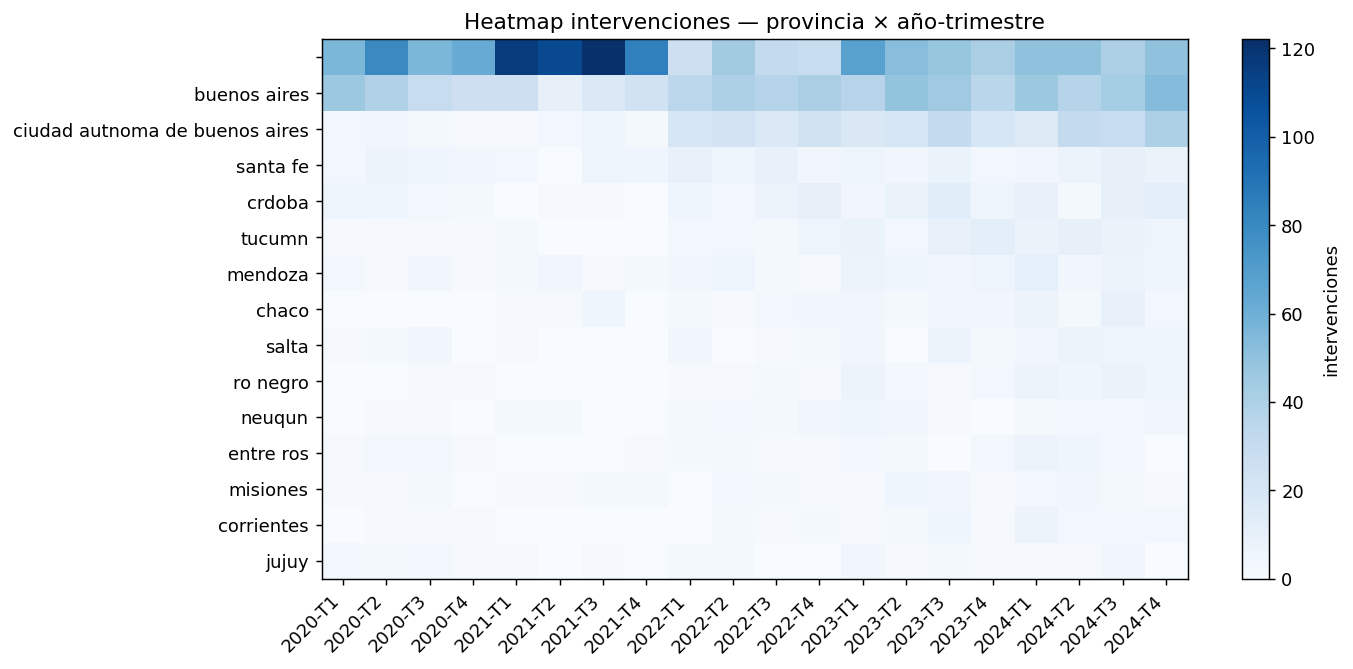

✔ Guardado: figs/esp_heatmap_prov_trim_intervenciones.png


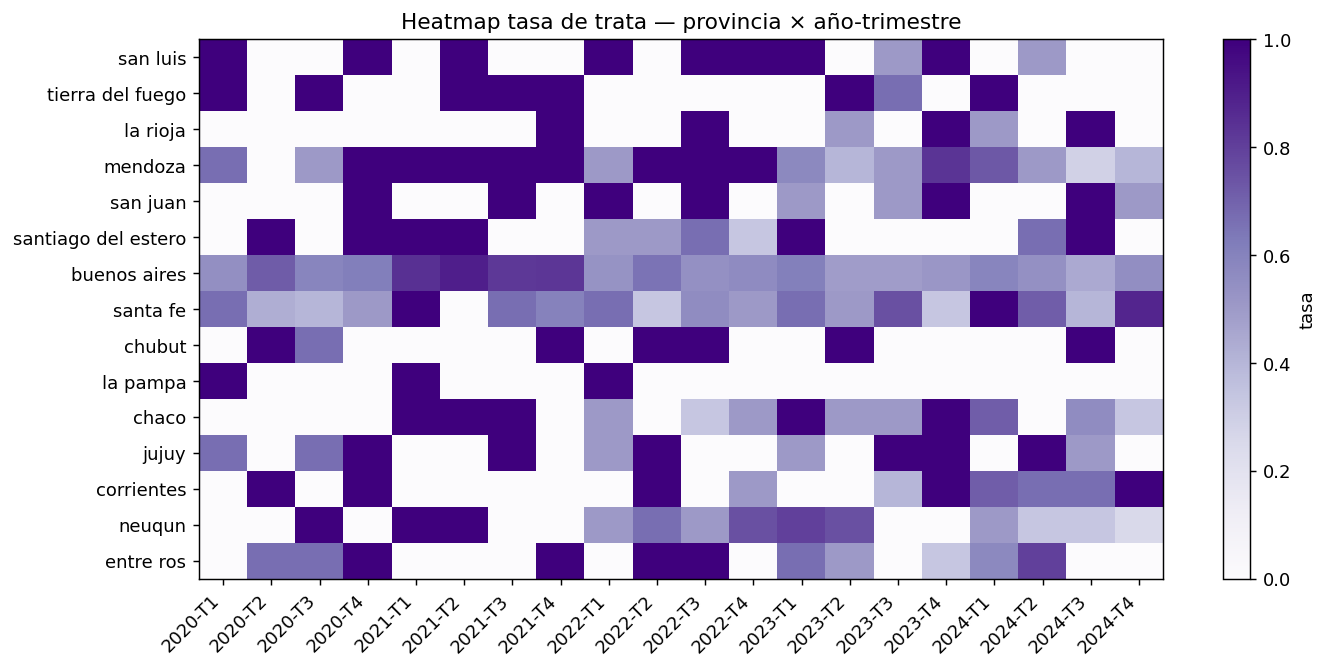

✔ Guardado: figs/esp_heatmap_prov_trim_tasa.png


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

Path("figs").mkdir(exist_ok=True)

# Parámetros editables
EXCLUIR_DESCONOCIDO = True   # si True, saca trimestres sin mes
TOPN = 15                    # filas (provincias) a mostrar
ESCALA_FILAS = 0.35          # alto por fila (↓ achica, ↑ agranda)
ESCALA_COLS  = 0.55          # ancho por columna (↓ achica, ↑ agranda)
CMAP_INT  = "Blues"          # paleta intervenciones
CMAP_TASA = "Purples"        # paleta tasa
OUTPUT_SUFFIX = ""           # ej: "_2020_2024" si filtraste período


df_hm = prov_trim.copy()

#Sanitización mínima
req = {"consultante_provincia","anio","trimestre","intervenciones","tasa"}
faltan = req - set(df_hm.columns)
if faltan:
    raise ValueError(f"Faltan columnas en prov_trim: {faltan}")

df_hm["consultante_provincia"] = df_hm["consultante_provincia"].astype(str)
df_hm["anio"] = pd.to_numeric(df_hm["anio"], errors="coerce").astype("Int64")

# Etiqueta T1..T4 o "Desconocido"
def lbl_trim(x):
    try:
        x = int(x)
        return {1:"T1",2:"T2",3:"T3",4:"T4"}.get(x, "Desconocido")
    except Exception:
        return "Desconocido"

df_hm["trimestre_lbl"] = df_hm["trimestre"].map(lbl_trim)
if EXCLUIR_DESCONOCIDO:
    df_hm = df_hm[df_hm["trimestre_lbl"] != "Desconocido"].copy()

# Etiqueta combinada año-trimestre (ej: 2022-T3)
df_hm = df_hm[pd.notna(df_hm["anio"])].copy()
df_hm["anio_trim"] = df_hm["anio"].astype(int).astype(str) + "-" + df_hm["trimestre_lbl"]

# Helper para ordenar columnas cronológicamente
def _orden_cols(cols):
    def parse(c):
        try:
            a, t = str(c).split("-", 1)
            anio = int(a)
            tri = int(t.replace("T","")) if t.startswith("T") else 99
            return (anio, tri)
        except Exception:
            return (0, 99)
    return sorted(cols, key=parse)

def _heatmap(df, value_col, agg, title, fname, cmap):
    # Pivot provincia × año-trimestre
    pv = pd.pivot_table(
        df, index="consultante_provincia", columns="anio_trim",
        values=value_col, aggfunc=agg, dropna=False
    )
    if pv.empty:
        print(f"[AVISO] Pivot vacío para {value_col}.")
        return

    # Orden filas por total/media y TopN
    orden = pv.sum(axis=1, numeric_only=True) if agg=="sum" else pv.mean(axis=1, numeric_only=True)
    pv = pv.loc[orden.sort_values(ascending=False).index].head(TOPN)

    # Orden columnas cronológico
    pv = pv.reindex(columns=_orden_cols(pv.columns))

    # A matriz float (evita dtype object)
    M = pv.fillna(0).to_numpy(dtype=float)

    # Tamaños
    fig_w = max(8, pv.shape[1]*ESCALA_COLS)
    fig_h = max(5, pv.shape[0]*ESCALA_FILAS)

    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=130)
    im = ax.imshow(M, aspect="auto", cmap=cmap)

    ax.set_yticks(np.arange(len(pv.index)))
    ax.set_yticklabels(pv.index.astype(str))
    ax.set_xticks(np.arange(len(pv.columns)))
    ax.set_xticklabels(pv.columns, rotation=45, ha="right")

    ax.set_title(title)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(value_col)

    plt.tight_layout()
    outpath = f"figs/{fname}{OUTPUT_SUFFIX}.png"
    plt.savefig(outpath, dpi=150)
    plt.show()
    print(f"✔ Guardado: {outpath}")

# Heatmap de INTERVENCIONES (suma)
_heatmap(
    df_hm, "intervenciones", agg="sum",
    title="Heatmap intervenciones — provincia × año-trimestre",
    fname="esp_heatmap_prov_trim_intervenciones",
    cmap=CMAP_INT
)

#  Heatmap de TASA (promedio trimestral)
_heatmap(
    df_hm, "tasa", agg="mean",
    title="Heatmap tasa de trata — provincia × año-trimestre",
    fname="esp_heatmap_prov_trim_tasa",
    cmap=CMAP_TASA
)




##Foco Tierra del Fuego (tablas)
Filtra TDF, arma resúmenes por trimestre y por localidad×trimestre; guarda CSVs.

In [24]:
import pandas as pd
import numpy as np
from pathlib import Path
import unicodedata

Path("results").mkdir(exist_ok=True)

# 0) Tomar DF base (df_tmp si existe; si no, df)
try:
    base = df_tmp.copy()
except NameError:
    try:
        base = df.copy()
    except NameError:
        raise ValueError("No encuentro 'df_tmp' ni 'df' en memoria. Corré celdas de preparación previas.")

# 1) Helpers
def norm_txt(s):
    """lower + sin tildes + sin espacios redundantes (para comparar textos)."""
    if pd.isna(s): return ""
    s = str(s).strip().lower()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = " ".join(s.split())  # colapsa espacios
    return s

def a_binario(x):
    """Normaliza es_trata a 0/1 (bool, 0/1, 'si/no', 'true/false', numérico)."""
    if pd.isna(x): return 0
    if isinstance(x, (bool, np.bool_)): return int(x)
    s = str(x).strip().lower()
    if s in ("1","si","sí","true","t","y","yes"): return 1
    if s in ("0","no","false","f","n"): return 0
    try: return int(float(x) != 0)
    except Exception: return 0

def tabla_xt(df, keys):
    """Agrupa y calcula intervenciones, confirmadas y tasa (vectorizado)."""
    out = (df.groupby(keys, dropna=False)
             .agg(intervenciones=("es_trata","size"),
                  confirmadas=("es_trata","sum"))
             .assign(tasa=lambda t: np.where(t["intervenciones"]>0,
                                             t["confirmadas"]/t["intervenciones"], 0.0))
             .reset_index())
    return out

# 2) Asegurar variables temporales y target
# a) anio/mes (derivar desde fecha si faltan)
cols_lower = {c.lower(): c for c in base.columns}
if "anio" not in cols_lower or "mes" not in cols_lower:
    cand = [c for c in base.columns if c.lower() in ("fecha","fecharegistro","fecha_hecho","fecha_caso","fecha_ingreso")]
    if not cand:
        raise ValueError("No encuentro 'anio' y 'mes' ni una columna de 'fecha' para derivarlas.")
    fecha_col = cand[0]
    base[fecha_col] = pd.to_datetime(base[fecha_col], errors="coerce")
    base["anio"] = base[fecha_col].dt.year
    base["mes"]  = base[fecha_col].dt.month
else:
    if cols_lower["anio"] != "anio": base.rename(columns={cols_lower["anio"]:"anio"}, inplace=True)
    if cols_lower["mes"]  != "mes":  base.rename(columns={cols_lower["mes"] :"mes"},  inplace=True)

# b) tipos consistentes
base["anio"] = pd.to_numeric(base["anio"], errors="coerce")
base["mes"]  = pd.to_numeric(base["mes"],  errors="coerce")

# c) trimestre (1..4, enteros anulables)
base["trimestre"] = ((base["mes"] - 1) // 3 + 1)
base.loc[base["mes"].isna(), "trimestre"] = pd.NA
base["trimestre"] = base["trimestre"].astype("Int64")

# d) es_trata binario
if "es_trata" not in base.columns:
    raise ValueError("No encuentro la columna 'es_trata' en el dataset.")
base["es_trata"] = base["es_trata"].map(a_binario).astype(int)

# 3) Filtro Tierra del Fuego (robusto a variaciones)
if "consultante_provincia" not in base.columns:
    raise ValueError("No encuentro la columna 'consultante_provincia'.")

base["_prov_norm"] = base["consultante_provincia"].map(norm_txt)

# Variantes habituales de escritura (sin tildes, lower, sin dobles espacios)
TDF_KEYS = {
    "tierra del fuego",
    "tierra del fuego antartida e islas del atlantico sur",
    "t del fuego",
    "tdf",
    "tierra de fuego",
    "tierradelfuego"   # sin espacio
}

tdf = base[base["_prov_norm"].isin(TDF_KEYS)].copy()

if tdf.empty:
    print("⚠ No hay registros de Tierra del Fuego (revisá cómo viene escrita la provincia).")
else:
    # Eliminamos filas sin trimestre (si las hubiera) para reportes trimestrales
    tdf = tdf.dropna(subset=["trimestre"]).copy()

    # 4) Tablas: por trimestre y por localidad×trimestre
    tdf_trim = tabla_xt(tdf, ["anio","trimestre"]).sort_values(["anio","trimestre"])

    if "consultante_localidad" in tdf.columns:
        # normalizo localidad mínima (sin tildes/minúsculas) para agrupar bien
        tdf["_loc_norm"] = tdf["consultante_localidad"].map(norm_txt)
        # Por claridad en salida, dejamos la original si existe; agrupamos por la original
        tdf_loc = tabla_xt(tdf, ["consultante_localidad","anio","trimestre"])\
                    .sort_values(["consultante_localidad","anio","trimestre"])
    else:
        tdf_loc = pd.DataFrame(columns=["consultante_localidad","anio","trimestre",
                                        "intervenciones","confirmadas","tasa"])
        print("Aviso: no encontré 'consultante_localidad'; tabla de localidades vacía.")

    # 5) Guardado + vistas
    out1 = Path("results") / "relevamiento_tdf_trimestre.csv"
    out2 = Path("results") / "relevamiento_tdf_localidad_trimestre.csv"
    tdf_trim.to_csv(out1, index=False, encoding="utf-8-sig")
    tdf_loc.to_csv(out2, index=False, encoding="utf-8-sig")

    print(f"✔ Registros TDF: {len(tdf):,}".replace(",", "."))
    print(f"✔ Guardados:\n  - {out1}\n  - {out2}")
    print("\nResumen por trimestre (primeras filas):")
    display(tdf_trim.head(10))
    print("\nResumen por localidad×trimestre (primeras filas):")
    display(tdf_loc.head(10))


✔ Registros TDF: 13
✔ Guardados:
  - results\relevamiento_tdf_trimestre.csv
  - results\relevamiento_tdf_localidad_trimestre.csv

Resumen por trimestre (primeras filas):


,anio,trimestre,intervenciones,confirmadas,tasa
0,2020,1,1,1,1.000000
1,2020,3,2,2,1.000000
2,2020,4,1,0,0.000000
3,2021,2,1,1,1.000000
4,2021,3,1,1,1.000000
5,2021,4,1,1,1.000000
6,2023,2,1,1,1.000000
7,2023,3,3,2,0.666667
8,2024,1,1,1,1.000000
9,2024,3,1,0,0.000000



Resumen por localidad×trimestre (primeras filas):


,consultante_localidad,anio,trimestre,intervenciones,confirmadas,tasa
0,,2023,2,1,1,1.0
1,,2023,3,2,2,1.0
2,,2024,1,1,1,1.0
3,,2024,3,1,0,0.0
4,paran,2023,3,1,0,0.0
5,rio grande,2020,1,1,1,1.0
6,ro grande,2020,4,1,0,0.0
7,ushuaia,2020,3,2,2,1.0
8,ushuaia,2021,2,1,1,1.0
9,ushuaia,2021,3,1,1,1.0


##Gráficos TDF
Gráficos para TDF (intervenciones por año–trimestre y Top localidades).

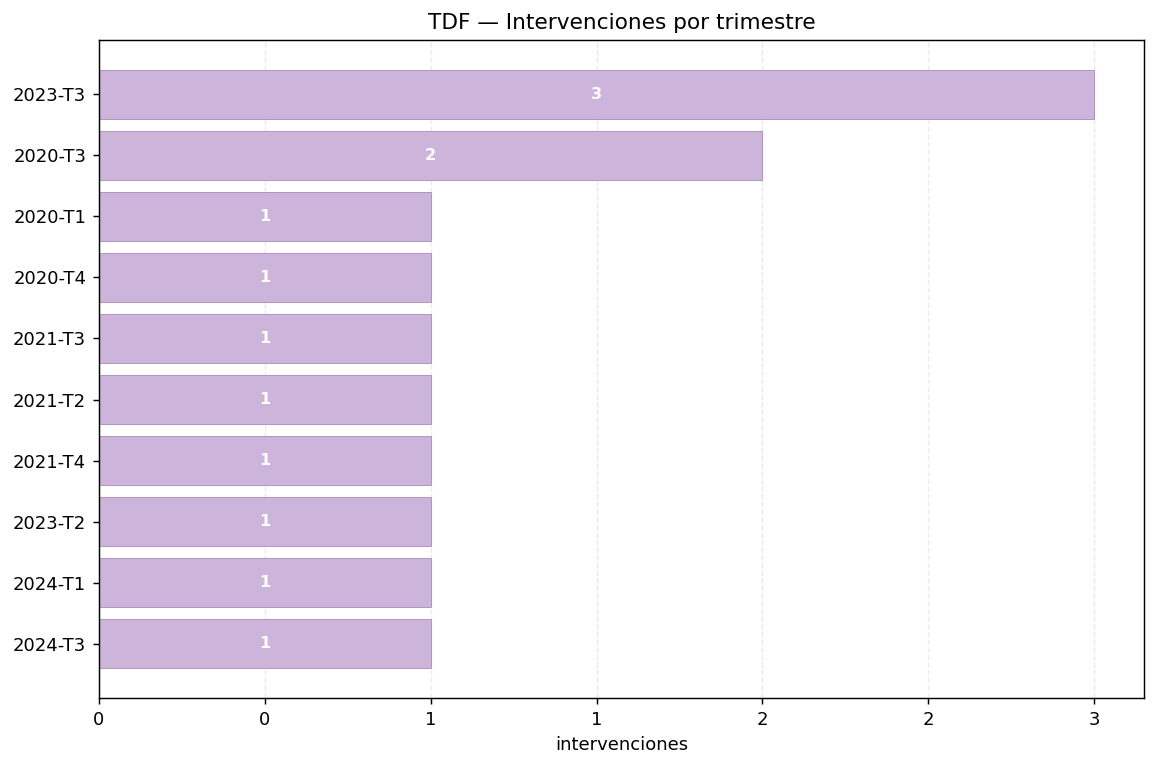

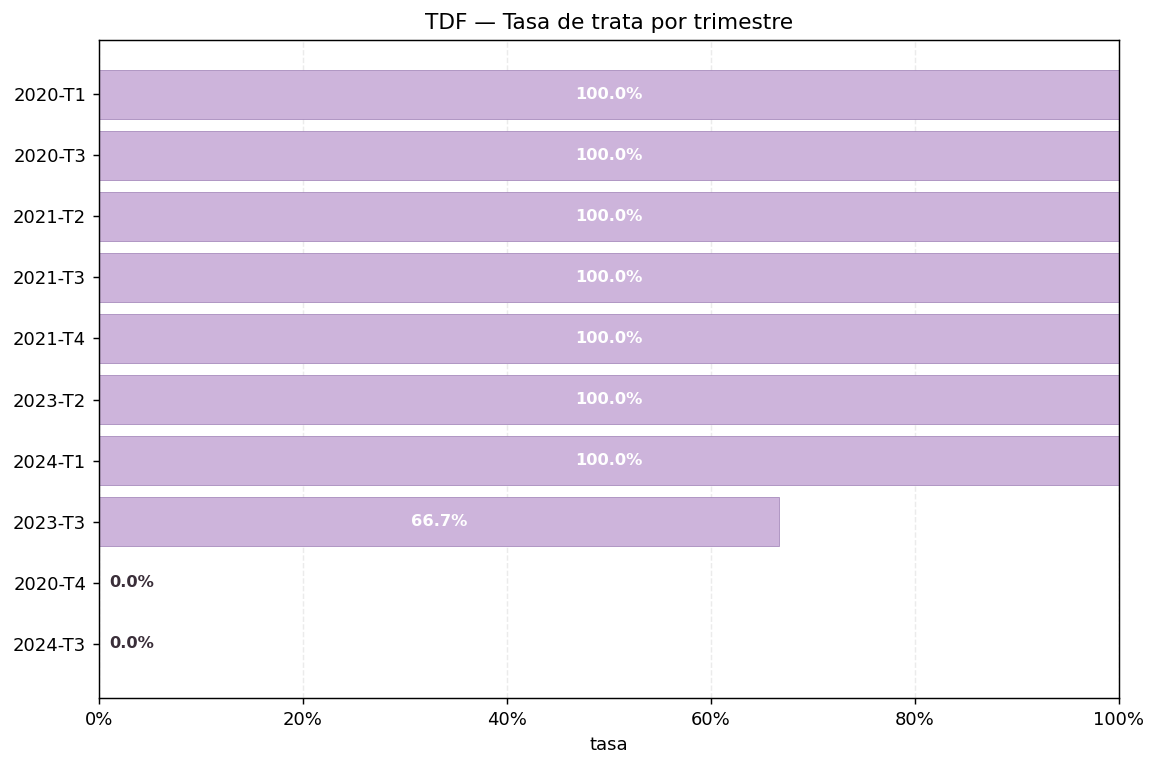

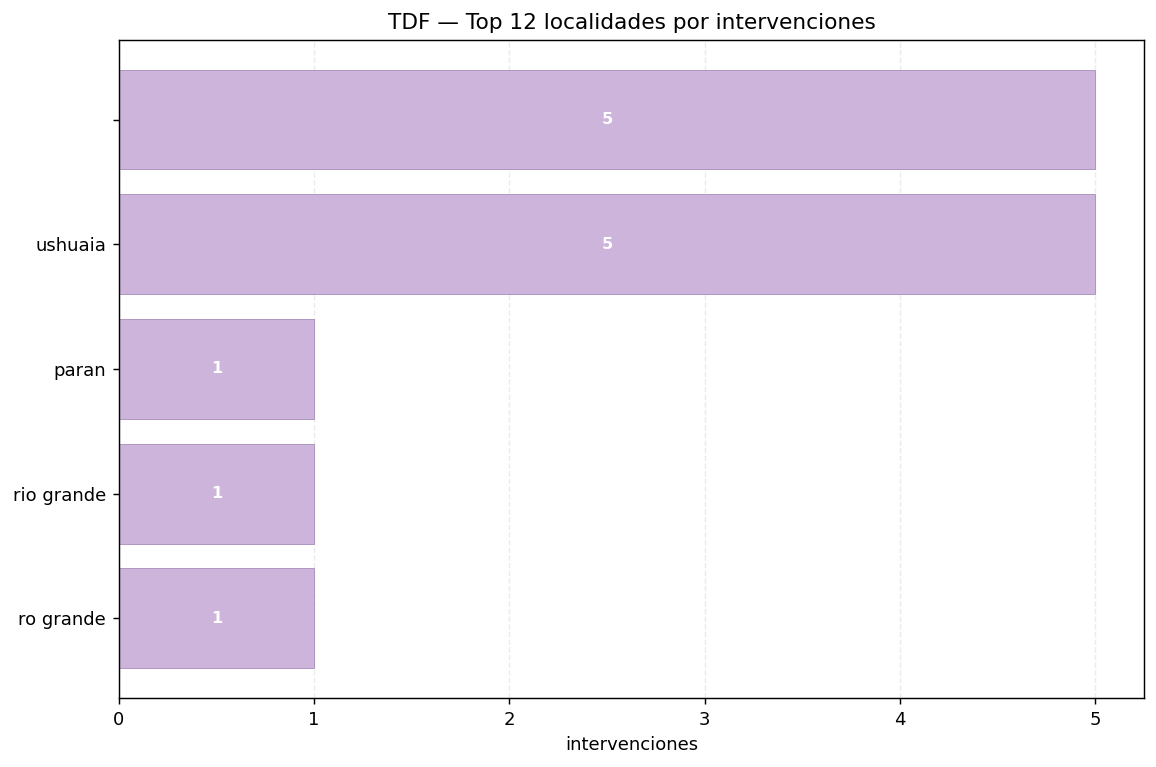

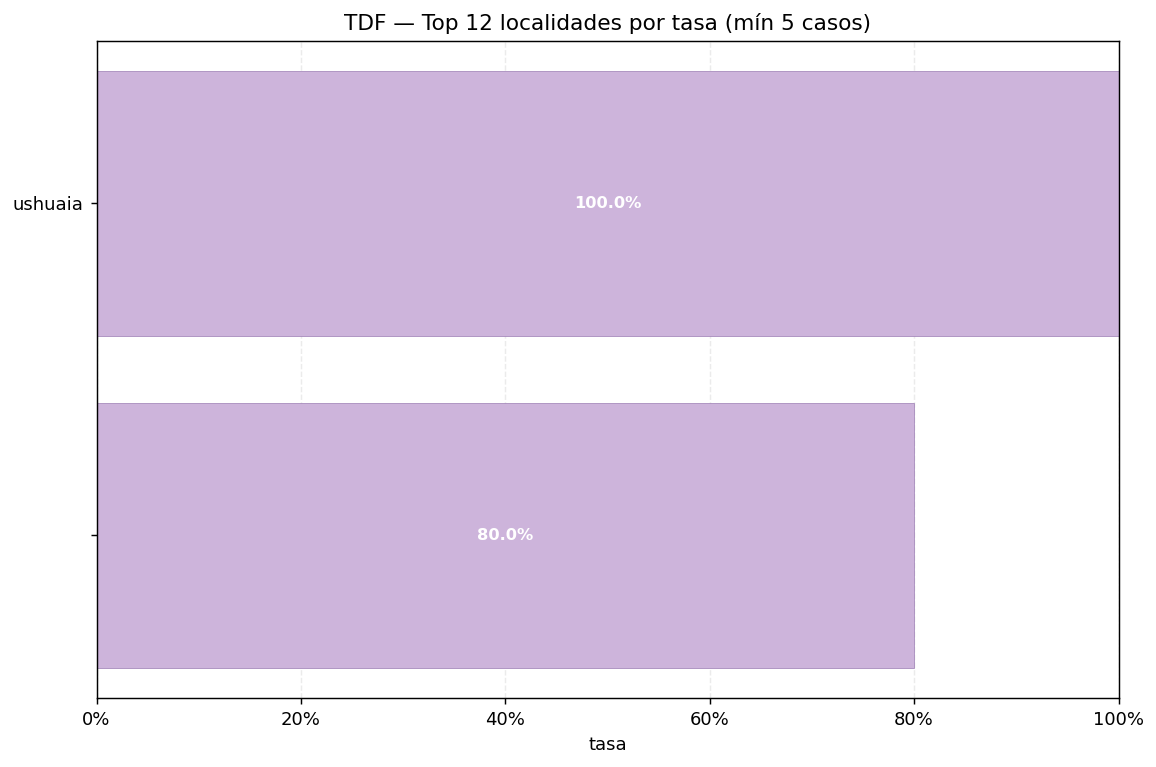

[AVISO] tdf_trim está vacío. Corré la Celda 12 primero o no hay registros para TDF.


In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
from pathlib import Path

Path("figs").mkdir(exist_ok=True)

# Config general
VIOLETA = "#CDB4DB"
BORDE   = "#9D7FB5"
TOPK_LOC = 12          # top localidades por intervenciones/tasa
MIN_CASOS_LOC = 5      # mínimo de intervenciones para rankear por tasa

# Helpers de formato
def fmt_k(v):
    if v >= 1000:
        val = v / 1000.0
        return f"{val:.1f}k" if val % 1 else f"{int(val)}k"
    return f"{int(v)}"
k_formatter   = FuncFormatter(lambda v, pos: fmt_k(v))
pct_formatter = FuncFormatter(lambda v, pos: f"{v:.0%}")

def barh_labels(ax, bars, values, is_pct=False):
    vmax = float(max(values) if len(values) else 1)
    for rect, v in zip(bars, values):
        cx = rect.get_width()/2
        if is_pct:
            label = f"{v:.1%}"
            if rect.get_width() < 0.08:
                ax.text(rect.get_width()+0.01, rect.get_y()+rect.get_height()/2,
                        label, va="center", ha="left", color="#3A2E39", fontsize=9, fontweight="bold")
            else:
                ax.text(cx, rect.get_y()+rect.get_height()/2,
                        label, va="center", ha="center", color="white", fontsize=9, fontweight="bold")
        else:
            label = fmt_k(v)
            if rect.get_width() < vmax*0.08:
                ax.text(rect.get_width()+vmax*0.01, rect.get_y()+rect.get_height()/2,
                        label, va="center", ha="left", color="#3A2E39", fontsize=9, fontweight="bold")
            else:
                ax.text(cx, rect.get_y()+rect.get_height()/2,
                        label, va="center", ha="center", color="white", fontsize=9, fontweight="bold")

def plot_barh(df, label_col, value_col, title, fname, is_pct=False, xlabel=None, figsize=(8,5)):
    if df.empty:
        print(f"[AVISO] No hay datos para '{title}'.")
        return
    d = df[[label_col, value_col]].dropna().copy()
    d = d.sort_values(value_col, ascending=False).iloc[::-1]  # mayor arriba
    fig, ax = plt.subplots(figsize=figsize, dpi=130)
    bars = ax.barh(d[label_col].astype(str), d[value_col], color=VIOLETA, edgecolor=BORDE, linewidth=0.4)
    ax.set_title(title)
    ax.set_xlabel(xlabel if xlabel else value_col)
    ax.xaxis.grid(True, linestyle="--", alpha=0.25); ax.set_axisbelow(True)
    if is_pct:
        ax.set_xlim(0, 1); ax.xaxis.set_major_formatter(pct_formatter)
    else:
        ax.xaxis.set_major_formatter(k_formatter)
    barh_labels(ax, bars, d[value_col].values, is_pct=is_pct)
    plt.tight_layout(); plt.savefig(f"figs/{fname}", dpi=150); plt.show()

# Trimestres (año–Tn)
if 'tdf_trim' not in globals() or tdf_trim.empty:
    print("[AVISO] tdf_trim está vacío. Corré la Celda 9 primero o no hay registros para TDF.")
else:
    tt = tdf_trim.copy()
    # Etiqueta año–trimestre
    tt["anio_trim"] = tt["anio"].astype(int).astype(str) + "-T" + tt["trimestre"].astype(int).astype(str)
    # Orden cronológico
    def _parse_lbl(s):
        a, t = str(s).split("-T")
        return (int(a), int(t))
    tt = tt.sort_values(by=["anio_trim"], key=lambda c: c.map(_parse_lbl))

    # Intervenciones por trimestre (horizontal para mantener estilo)
    plot_barh(tt, "anio_trim", "intervenciones",
              "TDF — Intervenciones por trimestre",
              "tdf_intervenciones_trimestre.png",
              is_pct=False, xlabel="intervenciones", figsize=(9,6))

    # Tasa por trimestre
    plot_barh(tt, "anio_trim", "tasa",
              "TDF — Tasa de trata por trimestre",
              "tdf_tasa_trimestre.png",
              is_pct=True, xlabel="tasa", figsize=(9,6))

# Localidades
if 'tdf_loc' not in globals() or tdf_loc.empty:
    print("[AVISO] tdf_loc está vacío (no hay columna de localidad o no hay datos).")
else:
    tl = tdf_loc.copy()
    # Acumulados por localidad (total sobre todo el período)
    loc_sum = (tl.groupby("consultante_localidad", as_index=False)
                 .agg(intervenciones=("intervenciones","sum"),
                      confirmadas=("confirmadas","sum")))
    loc_sum["tasa"] = np.where(loc_sum["intervenciones"]>0,
                               loc_sum["confirmadas"]/loc_sum["intervenciones"], 0.0)

    # Top localidades por intervenciones
    top_loc_int = loc_sum.sort_values("intervenciones", ascending=False).head(TOPK_LOC)
    plot_barh(top_loc_int, "consultante_localidad", "intervenciones",
              f"TDF — Top {TOPK_LOC} localidades por intervenciones",
              "tdf_top_localidades_intervenciones.png",
              is_pct=False, xlabel="intervenciones", figsize=(9,6))

    # Top localidades por tasa (con mínimo de casos)
    loc_tasa = loc_sum[loc_sum["intervenciones"] >= MIN_CASOS_LOC]
    top_loc_tasa = loc_tasa.sort_values("tasa", ascending=False).head(TOPK_LOC)
    plot_barh(top_loc_tasa, "consultante_localidad", "tasa",
              f"TDF — Top {TOPK_LOC} localidades por tasa (mín {MIN_CASOS_LOC} casos)",
              "tdf_top_localidades_tasa.png",
              is_pct=True, xlabel="tasa", figsize=(9,6))

    print("[AVISO] tdf_trim está vacío. Corré la Celda 12 primero o no hay registros para TDF.")


### Split / CV / Modelos (robusta, sin fugas)
1) Define features numéricas/categóricas y el target 'es_trata'
2) Arma un preprocesamiento con ColumnTransformer (imputación + escala + OneHot)
3) Hace split temporal (opción) o aleatorio estratificado
4) Corre CV con 3 modelos base y guarda métricas (CV y holdout) a CSV


In [26]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import (
    StratifiedKFold, TimeSeriesSplit, train_test_split, cross_validate
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#  Parámetros editables
DF_BASE = "df_tmp"                 # df maestro en memoria: 'df_tmp' o 'df'
TARGET  = "es_trata"               # target (0/1)

# columnas identificadoras que nunca van al modelo
ID_COLS = ["id", "nro_registro_interno", "registro_id", "uuid"]

# columnas excluidas por potencial fuga/pos-resultado
EXCLUDE_COLS = [
    "tema", "subtema",             # suelen ser proxy del label
    "confirmadas", "resultado",    # cualquier var. post-resultado
    "anio_mes", "anio_trimestre",  # se usan para splits/agrup., no como features
]

# columnas de fecha candidatas (si existe alguna, se crearán features seguras)
FECHA_CANDIDATAS = ["fecha_ingreso", "fecharegistro", "fecha_hecho", "fecha_caso", "fecha"]

# Split temporal (evita fuga)
TIME_BASED_SPLIT = True
# corte: <= train ;  > test
CUTOFF = ("anio", 2023, "mes", 6)  # (col_anio, valor_anio, col_mes, valor_mes)

# CV y reproducibilidad
N_SPLITS = 5
RANDOM_STATE = 42

RESULTS_DIR = Path("results"); RESULTS_DIR.mkdir(exist_ok=True)

#  1) Base y target
base = globals().get(DF_BASE, None)
if base is None:
    raise ValueError(f"No encontré el DataFrame '{DF_BASE}' en memoria.")

data = base.copy()

if TARGET not in data.columns:
    raise ValueError(f"No encuentro la columna target '{TARGET}'.")
data[TARGET] = pd.to_numeric(data[TARGET], errors="coerce").fillna(0).astype(int)

# 2) Ingeniería de tiempo segura
def add_time_features(df, fecha_cols):
    """Crea features temporales seguras (anio, mes, dia_semana, fin_semana, cíclicas)."""
    df = df.copy()
    fecha_col = None
    for c in fecha_cols:
        if c in df.columns:
            fecha_col = c
            break
    if fecha_col is not None:
        f = pd.to_datetime(df[fecha_col], errors="coerce")
        df["anio"] = f.dt.year
        df["mes"] = f.dt.month
        df["dia_semana"] = f.dt.dayofweek
        df["es_fin_semana"] = df["dia_semana"].isin([5, 6]).astype(int)
        # codificación cíclica (opcional pero estable)
        df["mes_sin"] = np.sin(2*np.pi*(df["mes"].fillna(0))/12)
        df["mes_cos"] = np.cos(2*np.pi*(df["mes"].fillna(0))/12)
    return df, fecha_col

data, fecha_detectada = add_time_features(data, FECHA_CANDIDATAS)

# 3) Construcción de X/y + exclusiones anti-fuga
# columnas a sacar por nombre exacto (IDs + lista de exclusiones + la fecha original si existiera)
drop_cols_exact = [c for c in ID_COLS + EXCLUDE_COLS if c in data.columns]
if fecha_detectada is not None:
    drop_cols_exact.append(fecha_detectada)  # quitamos la fecha cruda

X = data.drop(columns=[TARGET] + drop_cols_exact, errors="ignore")
y = data[TARGET].copy()

# también evitamos one-hots de fecha que puedan quedar de pasos anteriores
EXCLUDE_PREFIX = ("cat__fecha_", "oh__fecha_", "dt_", "fecha_")
drop_pref = [c for c in X.columns if any(str(c).startswith(p) for p in EXCLUDE_PREFIX)]
X = X.drop(columns=drop_pref, errors="ignore")

# columnas num/cat (tras las exclusiones)
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

# 4) Preprocesamiento
def _make_ohe():
    # compatibilidad sklearn ≥1.2 (sparse_output) y previas (sparse)
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

num_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])

cat_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", _make_ohe())
])

pre = ColumnTransformer(
    transformers=[
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols),
    ],
    remainder="drop"
)

# 5) Modelos
models = {
    "LogReg": LogisticRegression(max_iter=200, class_weight="balanced", random_state=RANDOM_STATE),
    "RF": RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_leaf=2,
        class_weight="balanced_subsample", random_state=RANDOM_STATE, n_jobs=-1
    ),
    "HGB": HistGradientBoostingClassifier(
        learning_rate=0.08, max_depth=None, l2_regularization=0.0,
        random_state=RANDOM_STATE
    ),
}

# 6) Split (temporal o estratificado)
if TIME_BASED_SPLIT:
    ay, av, my, mv = CUTOFF
    if (ay not in data.columns) or (my not in data.columns):
        raise ValueError(f"Para split temporal necesito columnas '{ay}' y '{my}'.")
    mask_train = (data[ay] < av) | ((data[ay] == av) & (data[my] <= mv))
    X_train, X_test = X.loc[mask_train].copy(), X.loc[~mask_train].copy()
    y_train, y_test = y.loc[mask_train].copy(), y.loc[~mask_train].copy()

    # Ordenamos por tiempo para que TimeSeriesSplit no fugue
    # Si tenemos fecha_detectada, ordenamos por esa fecha; si no, por (anio, mes)
    if fecha_detectada is not None and fecha_detectada in base.columns:
        idx_order = pd.to_datetime(base.loc[mask_train, fecha_detectada], errors="coerce").sort_values().index
        X_train, y_train = X_train.loc[idx_order], y_train.loc[idx_order]
    elif {"anio", "mes"}.issubset(data.columns):
        idx_order = pd.MultiIndex.from_arrays(
            [X_train["anio"].fillna(0).astype(int), X_train["mes"].fillna(0).astype(int)]
        ).argsort()
        X_train, y_train = X_train.iloc[idx_order], y_train.iloc[idx_order]

    cv = TimeSeriesSplit(n_splits=N_SPLITS)
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

print(f"Train: {len(X_train):,} | Test: {len(X_test):,} | Positivos train: {y_train.sum():,}".replace(",", "."))

# 7) CV + evaluación holdout
rows = []
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

for name, clf in models.items():
    pipe = Pipeline([("prep", pre), ("clf", clf)])

    cvres = cross_validate(
        pipe, X_train, y_train,
        scoring=scoring, cv=cv, n_jobs=-1, return_train_score=False
    )
    cv_mean = {f"cv_test_{k}": float(np.mean(v)) for k, v in cvres.items() if k.startswith("test_")}
    cv_std  = {f"cv_test_{k}_std": float(np.std(v))  for k, v in cvres.items() if k.startswith("test_")}

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    y_proba = None
    try:
        y_proba = pipe.predict_proba(X_test)[:, 1]
    except Exception:
        try:
            s = pipe.decision_function(X_test)
            y_proba = (s - s.min())/(s.max()-s.min() + 1e-9)
        except Exception:
            pass

    hold = {
        "hold_accuracy": float(accuracy_score(y_test, y_pred)),
        "hold_precision": float(precision_score(y_test, y_pred, zero_division=0)),
        "hold_recall": float(recall_score(y_test, y_pred, zero_division=0)),
        "hold_f1": float(f1_score(y_test, y_pred, zero_division=0)),
        "hold_roc_auc": float(roc_auc_score(y_test, y_proba)) if y_proba is not None and len(np.unique(y_test))==2 else np.nan,
    }

    rows.append({"modelo": name, **cv_mean, **cv_std, **hold})

resultados = pd.DataFrame(rows).sort_values("hold_f1", ascending=False).reset_index(drop=True)
display(resultados)

out_csv = RESULTS_DIR / "modelos_metricas.csv"
resultados.to_csv(out_csv, index=False, encoding="utf-8-sig")
print(f"✔ Métricas guardadas en {out_csv}")

#  8) Exporto a globals
globals().update({
    "pre": pre,
    "models": models,
    "X_train": X_train, "y_train": y_train,
    "X_test": X_test, "y_test": y_test,
    "resultados": resultados,
    "TIME_BASED_SPLIT": TIME_BASED_SPLIT
})


Train: 1.986 | Test: 5.862 | Positivos train: 1.062


,modelo,cv_test_test_accuracy,cv_test_test_precision,cv_test_test_recall,cv_test_test_f1,cv_test_test_roc_auc,cv_test_test_accuracy_std,cv_test_test_precision_std,cv_test_test_recall_std,cv_test_test_f1_std,cv_test_test_roc_auc_std,hold_accuracy,hold_precision,hold_recall,hold_f1,hold_roc_auc
0,HGB,0.601208,0.628753,0.673262,0.643215,0.652520,0.020040,0.017387,0.128550,0.054621,0.034892,0.622484,0.624935,0.759987,0.685877,0.659170
1,LogReg,0.600000,0.607912,0.765645,0.673172,0.629642,0.040470,0.024227,0.124731,0.052932,0.052206,0.600478,0.621199,0.674740,0.646864,0.627936
2,RF,0.603021,0.646499,0.635083,0.628406,0.644115,0.032064,0.045112,0.144239,0.068591,0.033374,0.613613,0.650925,0.620006,0.635089,0.659888


✔ Métricas guardadas en results\modelos_metricas.csv


##Búsqueda de hiperparámetros (prioriza Recall)
pre, X_train, y_train, X_test, y_test, TIME_BASED_SPLIT

In [ ]:
import warnings, joblib
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import loguniform, randint

warnings.filterwarnings("ignore")

RESULTS = Path("results"); RESULTS.mkdir(exist_ok=True)

# 0) Valido objetos base 
need = ["pre", "X_train", "y_train", "X_test", "y_test"]
for var in need:
    if var not in globals():
        raise ValueError(f"Falta '{var}'. Corré la Celda 14 antes.")


if "TIME_BASED_SPLIT" not in globals():
    TIME_BASED_SPLIT = True

# Parámetros editables
N_ITER       = 30          # iteraciones por modelo (ajustá según tiempo disponible)
CV_SPLITS    = 5           # pliegues
N_JOBS       = -1          # paralelismo
RANDOM_STATE = 42
SCORING      = {"recall": "recall", "f1": "f1", "roc_auc": "roc_auc"}  # métricas en CV
REFIT        = "recall"    # el mejor por recall (priorizamos sensibilidad)

#  1) Defino CV (temporal o estratificado)
cv = TimeSeriesSplit(n_splits=CV_SPLITS) if TIME_BASED_SPLIT else StratifiedKFold(
    n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE
)

# 2) Modelos + espacios de búsqueda
# Tip: damos más “superficie” al HGB porque salió mejor en la 14.
search_spaces = {
    "LogReg": (
        LogisticRegression(max_iter=200, class_weight="balanced", random_state=RANDOM_STATE),
        {
            "clf__C": loguniform(1e-3, 1e3),
            "clf__solver": ["liblinear", "lbfgs"],  # ambos usan L2
            "clf__penalty": ["l2"],
        }
    ),
    "RF": (
        RandomForestClassifier(
            class_weight="balanced_subsample", random_state=RANDOM_STATE, n_jobs=-1
        ),
        {
            "clf__n_estimators": randint(200, 800),
            "clf__max_depth": randint(3, 30),
            "clf__min_samples_split": randint(2, 20),
            "clf__min_samples_leaf": randint(1, 10),
            "clf__max_features": ["sqrt", "log2", None],
        }
    ),
    "HGB": (
        HistGradientBoostingClassifier(
            random_state=RANDOM_STATE,
            early_stopping=True,           # ayuda a evitar sobreajuste
            validation_fraction=0.15,
            max_iter=400                   # nº de árboles base; también se ajusta con learning_rate
        ),
        {
            "clf__learning_rate": loguniform(1e-3, 3e-1),
            "clf__max_depth": randint(3, 15),
            "clf__max_leaf_nodes": randint(15, 127),
            "clf__min_samples_leaf": randint(10, 60),
            "clf__l2_regularization": loguniform(1e-6, 1e-0),  # incluimos regularización más amplia
        }
    ),
}

#  3) Ejecutar búsquedas
result_rows = []
best_global = {"name": None, "search": None, "pipeline": None, "cv_recall": -1.0}

for name, (estimator, space) in search_spaces.items():
    pipe = Pipeline([("prep", pre), ("clf", estimator)])

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=space,
        n_iter=N_ITER,
        scoring=SCORING,
        refit=REFIT,
        cv=cv,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        verbose=1
    )
    search.fit(X_train, y_train)

    # resumen por modelo en CV
    idx = search.best_index_
    best_params   = search.best_params_
    best_cv_recall = float(search.cv_results_["mean_test_recall"][idx])
    best_cv_f1     = float(search.cv_results_["mean_test_f1"][idx])
    best_cv_auc    = float(search.cv_results_["mean_test_roc_auc"][idx])

    result_rows.append({
        "modelo": name,
        "best_cv_recall": best_cv_recall,
        "best_cv_f1": best_cv_f1,
        "best_cv_roc_auc": best_cv_auc,
        "best_params": best_params
    })

    if best_cv_recall > best_global["cv_recall"]:
        best_global = {
            "name": name,
            "search": search,
            "pipeline": search.best_estimator_,
            "cv_recall": best_cv_recall
        }

# 4) Tabla y guardado
resumen = pd.DataFrame(result_rows).sort_values("best_cv_recall", ascending=False).reset_index(drop=True)
display(resumen)
resumen.to_csv(RESULTS / "hp_search_resumen.csv", index=False, encoding="utf-8-sig")
print(f"✔ Guardado resumen: {RESULTS / 'hp_search_resumen.csv'}")

# 5) Evaluación holdout del mejor (según recall en CV)
best_name = best_global["name"]
best_pipe = best_global["pipeline"]
print(f"Mejor por CV (Recall): {best_name}")

y_pred = best_pipe.predict(X_test)

try:
    y_proba = best_pipe.predict_proba(X_test)[:, 1]
except Exception:
    try:
        s = best_pipe.decision_function(X_test)
        y_proba = (s - s.min())/(s.max()-s.min() + 1e-9)
    except Exception:
        y_proba = None

hold_metrics = {
    "modelo": best_name,
    "hold_accuracy": float(accuracy_score(y_test, y_pred)),
    "hold_precision": float(precision_score(y_test, y_pred, zero_division=0)),
    "hold_recall": float(recall_score(y_test, y_pred, zero_division=0)),
    "hold_f1": float(f1_score(y_test, y_pred, zero_division=0)),
    "hold_roc_auc": float(roc_auc_score(y_test, y_proba)) if y_proba is not None else np.nan
}
hold_df = pd.DataFrame([hold_metrics])
display(hold_df)
hold_df.to_csv(RESULTS / "hp_best_holdout_metrics.csv", index=False, encoding="utf-8-sig")
print(f"✔ Guardado holdout: {RESULTS / 'hp_best_holdout_metrics.csv'}")

#  6) Persistir el mejor pipeline y exponer a globals
joblib.dump(best_pipe, RESULTS / "mejor_pipeline.pkl")
print(f"✔ Guardado pipeline: {RESULTS / 'mejor_pipeline.pkl'}")

globals().update({
    "best_pipe": best_pipe,
    "best_model_name": best_name
})

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


,modelo,best_cv_recall,best_cv_f1,best_cv_roc_auc,best_params
0,LogReg,0.777026,0.674858,0.630098,"{'clf__C': 0.22200545479787925, 'clf__penalty'..."
1,HGB,0.713747,0.639275,0.637714,{'clf__l2_regularization': 2.4924591120155927e...
2,RF,0.671592,0.641221,0.650911,"{'clf__max_depth': 18, 'clf__max_features': No..."


✔ Guardado resumen: results\hp_search_resumen.csv
Mejor por CV (Recall): LogReg


,modelo,hold_accuracy,hold_precision,hold_recall,hold_f1,hold_roc_auc
0,LogReg,0.584613,0.625846,0.581944,0.603097,0.627792


✔ Guardado holdout: results\hp_best_holdout_metrics.csv
✔ Guardado pipeline: results\mejor_pipeline.pkl


# Mejor modelo + Umbral por PR (diagnósticos incluidos)
Objetos de Celda 10 (pre, models, X_train, y_train, X_test, y_test, resultados)
y opcionalmente de Celda 11 (best_pipe del tuning).

Nota:
Si lo requieren ‘mejor F1’ por encima de todo, podudo plantear HGB @0.304 como baseline alternativo, pero para detección temprana me quedo con LogReg + umbral 0.328.”

Modelo elegido para Celda 16: Tuned-LogisticRegression
Umbral óptimo: 0.328 | Criterio: max F1 con recall ≥ 0.80
→ F1=0.704  Prec=0.559  Recall=0.951  | AP=0.667  ROC-AUC=0.6277916704819658


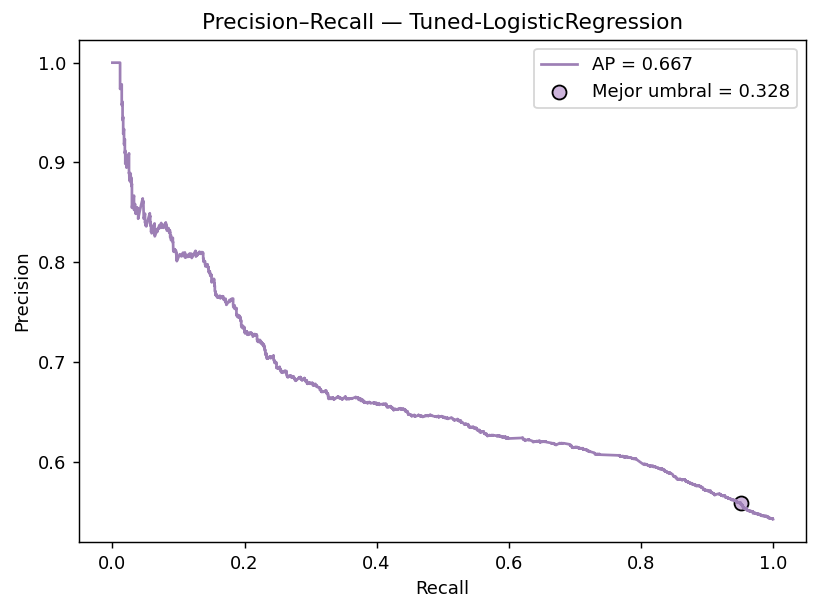

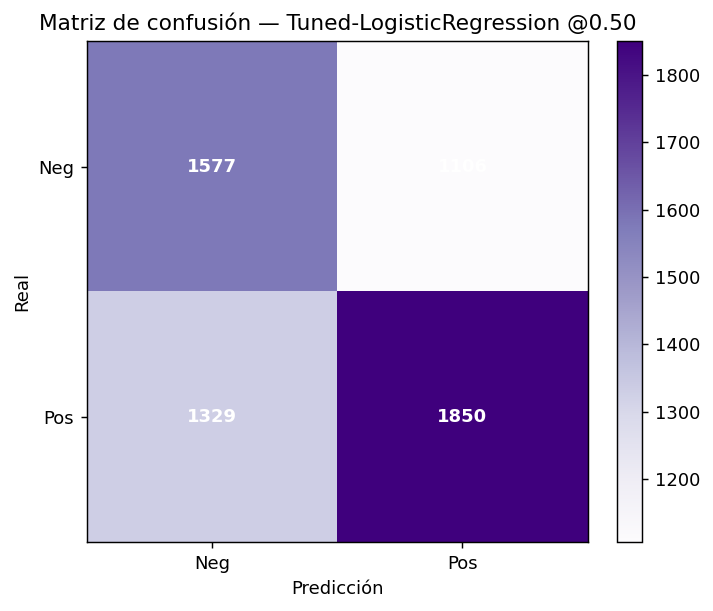

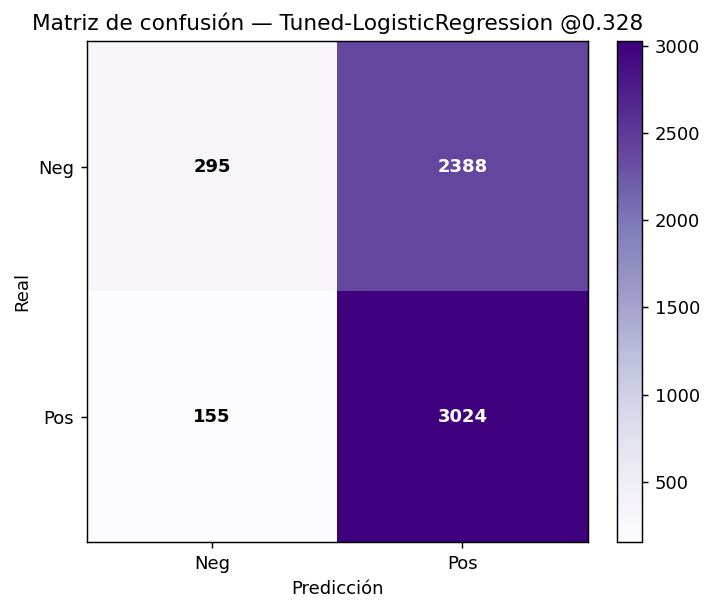

,modelo,umbral,accuracy,precision,recall,f1,roc_auc
0,Tuned-LogisticRegression,0.50,0.5846,0.6258,0.5819,0.6031,0.6278
1,Tuned-LogisticRegression,0.328 (opt),0.5662,0.5588,0.9512,0.7040,0.6278


✔ Archivos guardados en 'figs/' y 'results/'.
   - PR:            figs\pr_Tuned-LogisticRegression_c16.png
   - CM @0.50:      figs\cm_Tuned-LogisticRegression_050_c16.png
   - CM @óptimo:    figs\cm_Tuned-LogisticRegression_opt_c16.png
   - Tabla PR:      results\thresholds_curve_Tuned-LogisticRegression_c16.csv
   - Métricas:      results\best_metrics_Tuned-LogisticRegression_c16.csv
   - Umbral JSON:   results\best_threshold_Tuned-LogisticRegression_c16.json
   - Reporte TXT:   results\classification_report_Tuned-LogisticRegression_opt_c16.txt


In [28]:
import warnings, json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import load
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    precision_recall_curve, average_precision_score, roc_auc_score,
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score
)

warnings.filterwarnings("ignore")

# ----- Paths y estilos -----
FIGS    = Path("figs");    FIGS.mkdir(exist_ok=True)
RESULTS = Path("results"); RESULTS.mkdir(exist_ok=True)

VIOLETA = "#CDB4DB"
BORDE   = "#9D7FB5"

# ====== Parámetros editables ======
RECALL_TARGET        = 0.80           # objetivo de recall mínimo
FALLBACK_TO_MAX_F1   = True           # si no se llega al target, tomar el umbral de F1 máximo
N_UMBRAL_PUNTOS      = 200            # resolución del barrido de umbrales para tablas adicionales (opc.)
# ===================================

# --- 0) Chequeos mínimos y carga del pipeline ---
need = ["X_test","y_test"]
for v in need:
    if v not in globals():
        raise ValueError(f"Falta '{v}' (corré la Celda 14).")

best_pipe = None
pipe_path = RESULTS / "mejor_pipeline.pkl"
if pipe_path.exists():
    best_pipe = load(pipe_path)
else:
    if "best_pipe" in globals():
        best_pipe = globals()["best_pipe"]
    else:
        raise FileNotFoundError("No encuentro results/mejor_pipeline.pkl ni 'best_pipe' en memoria. Corré la Celda 15.")

BEST_NAME = "Tuned-" + best_pipe.named_steps["clf"].__class__.__name__
print(f"Modelo elegido para Celda 16: {BEST_NAME}")

# --- 1) Scores (probabilidades) en TEST ---
try:
    y_score = best_pipe.predict_proba(X_test)[:, 1]
except Exception:
    # algunos modelos no tienen predict_proba → decision_function normalizada a [0,1]
    s = best_pipe.decision_function(X_test)
    y_score = (s - s.min()) / (s.max() - s.min() + 1e-9)

# --- 2) Curva PR y umbral óptimo (max F1 con recall ≥ target) ---
prec, rec, thr = precision_recall_curve(y_test, y_score)
# Nota: len(thr) = len(prec) - 1
prec_m, rec_m, thr_m = prec[:-1], rec[:-1], thr

f1_vals = 2 * (prec_m * rec_m) / (prec_m + rec_m + 1e-12)
idx_ok  = np.where(rec_m >= RECALL_TARGET)[0]

if len(idx_ok):
    best_idx  = int(idx_ok[np.nanargmax(f1_vals[idx_ok])])
    criterio  = f"max F1 con recall ≥ {RECALL_TARGET:.2f}"
else:
    if FALLBACK_TO_MAX_F1:
        best_idx = int(np.nanargmax(f1_vals))
        criterio = "max F1 (sin cumplir recall objetivo)"
    else:
        # último recurso: umbral 0.50
        best_idx = int(np.argmin(np.abs(thr_m - 0.50)))
        criterio = "umbral 0.50 (fallback)"

best_thr = float(thr_m[best_idx])
best_f1  = float(f1_vals[best_idx])
best_pr  = float(prec_m[best_idx])
best_re  = float(rec_m[best_idx])

ap = float(average_precision_score(y_test, y_score))
try:
    roc_auc = float(roc_auc_score(y_test, y_score)) if len(np.unique(y_test))==2 else np.nan
except Exception:
    roc_auc = np.nan

print(f"Umbral óptimo: {best_thr:.3f} | Criterio: {criterio}")
print(f"→ F1={best_f1:.3f}  Prec={best_pr:.3f}  Recall={best_re:.3f}  | AP={ap:.3f}  ROC-AUC={roc_auc if not np.isnan(roc_auc) else 'NA'}")

# --- 3) Gráfico Precision–Recall con punto óptimo ---
plt.figure(dpi=130)
plt.plot(rec, prec, label=f"AP = {ap:.3f}", color=BORDE)
plt.scatter(best_re, best_pr, s=60, color=VIOLETA, edgecolors="black",
            label=f"Mejor umbral = {best_thr:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision–Recall — {BEST_NAME}")
plt.legend()
plt.tight_layout()
plt.savefig(FIGS / f"pr_{BEST_NAME}_c16.png", dpi=150)
plt.show()

# --- 4) Matrices de confusión: 0.50 vs óptimo ---
def plot_cm(y_true, y_sc, thr_, title, fname):
    y_hat = (y_sc >= thr_).astype(int)
    cm = confusion_matrix(y_true, y_hat)
    fig, ax = plt.subplots(dpi=130)
    im = ax.imshow(cm, cmap="Purples")
    vmax = cm.max() if cm.size else 1
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v),
                ha="center", va="center",
                color=("white" if v > 0.5*vmax else "black"), fontweight="bold")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Neg", "Pos"]); ax.set_yticklabels(["Neg", "Pos"])
    ax.set_xlabel("Predicción"); ax.set_ylabel("Real"); ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.savefig(FIGS / fname, dpi=150); plt.show()
    return y_hat

y_pred_050 = plot_cm(y_test, y_score, 0.50, f"Matriz de confusión — {BEST_NAME} @0.50",
                     f"cm_{BEST_NAME}_050_c16.png")
y_pred_opt = plot_cm(y_test, y_score, best_thr, f"Matriz de confusión — {BEST_NAME} @{best_thr:.3f}",
                     f"cm_{BEST_NAME}_opt_c16.png")

# --- 5) Métricas con ambos umbrales + reporte de clasificación al óptimo ---
def metricas(y_true, y_hat, y_scr):
    return {
        "accuracy":  float(accuracy_score(y_true, y_hat)),
        "precision": float(precision_score(y_true, y_hat, zero_division=0)),
        "recall":    float(recall_score(y_true, y_hat, zero_division=0)),
        "f1":        float(f1_score(y_true, y_hat, zero_division=0)),
        "roc_auc":   float(roc_auc_score(y_true, y_scr)) if len(np.unique(y_true))==2 else np.nan
    }

m_050 = metricas(y_test, y_pred_050, y_score)
m_opt = metricas(y_test, y_pred_opt, y_score)

rep_opt = classification_report(y_test, y_pred_opt, digits=3, zero_division=0)

# --- 6) Guardados: curvas/umbrales/métricas ---
# 6.1 Tabla “completa” de la curva PR (por si querés inspeccionar)
thr_table = pd.DataFrame({
    "threshold": thr_m,
    "precision": prec_m,
    "recall":    rec_m,
    "f1":        f1_vals
})
thr_table.to_csv(RESULTS / f"thresholds_curve_{BEST_NAME}_c16.csv", index=False, encoding="utf-8-sig")

# 6.2 Resumen de métricas @0.50 y @óptimo
summary = pd.DataFrame([
    {"modelo":BEST_NAME, "umbral":"0.50", **m_050},
    {"modelo":BEST_NAME, "umbral":f"{best_thr:.3f} (opt)", **m_opt}
]).round(4)
display(summary)
summary.to_csv(RESULTS / f"best_metrics_{BEST_NAME}_c16.csv", index=False, encoding="utf-8-sig")

# 6.3 Guardar umbral óptimo (para inferencia)
with open(RESULTS / f"best_threshold_{BEST_NAME}_c16.json","w", encoding="utf-8") as f:
    json.dump({
        "model": BEST_NAME,
        "criterion": criterio,
        "recall_target": RECALL_TARGET,
        "best_threshold": best_thr,
        "AP": ap,
        "ROC_AUC": None if np.isnan(roc_auc) else roc_auc
    }, f, ensure_ascii=False, indent=2)

# 6.4 Guardar classification report en TXT
(RESULTS / f"classification_report_{BEST_NAME}_opt_c16.txt").write_text(
    f"Modelo: {BEST_NAME}\n"
    f"Criterio: {criterio}\n"
    f"Umbral óptimo: {best_thr:.3f}\n\n{rep_opt}",
    encoding="utf-8"
)

print("✔ Archivos guardados en 'figs/' y 'results/'.")
print("   - PR:           ", FIGS / f"pr_{BEST_NAME}_c16.png")
print("   - CM @0.50:     ", FIGS / f"cm_{BEST_NAME}_050_c16.png")
print("   - CM @óptimo:   ", FIGS / f"cm_{BEST_NAME}_opt_c16.png")
print("   - Tabla PR:     ", RESULTS / f"thresholds_curve_{BEST_NAME}_c16.csv")
print("   - Métricas:     ", RESULTS / f"best_metrics_{BEST_NAME}_c16.csv")
print("   - Umbral JSON:  ", RESULTS / f"best_threshold_{BEST_NAME}_c16.json")
print("   - Reporte TXT:  ", RESULTS / f"classification_report_{BEST_NAME}_opt_c16.txt")


## ROC, PR, Confusión y mejor umbral para el mejor modelo

Mejor modelo (por hold_f1): HGB


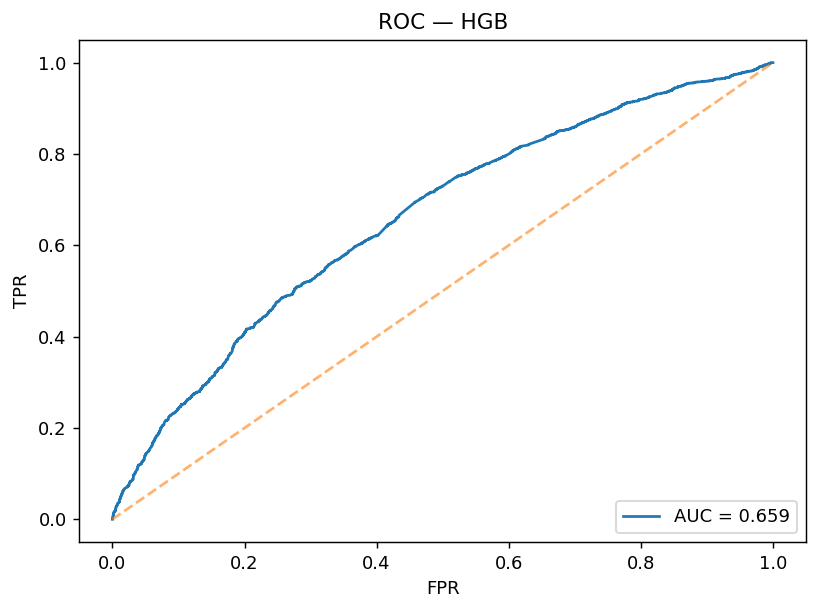

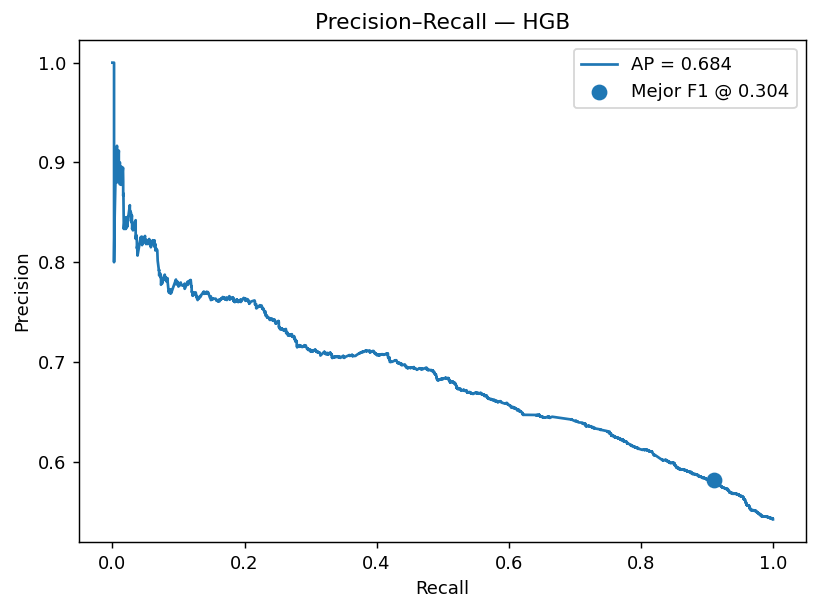

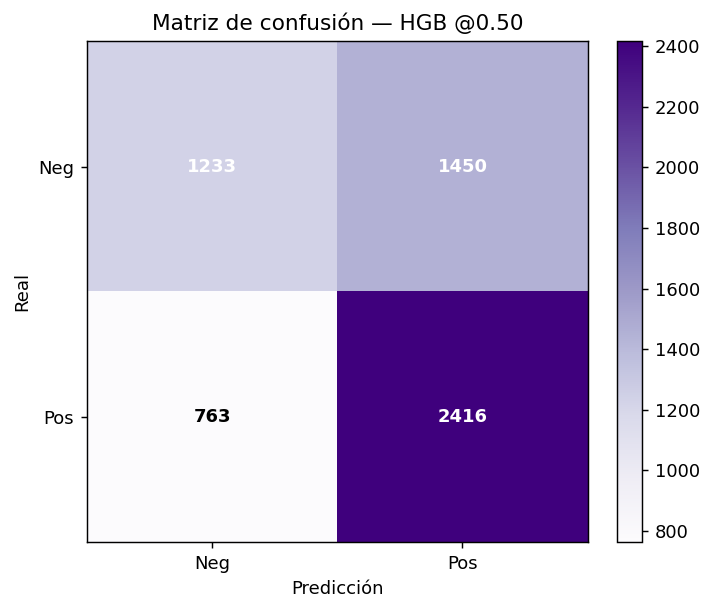

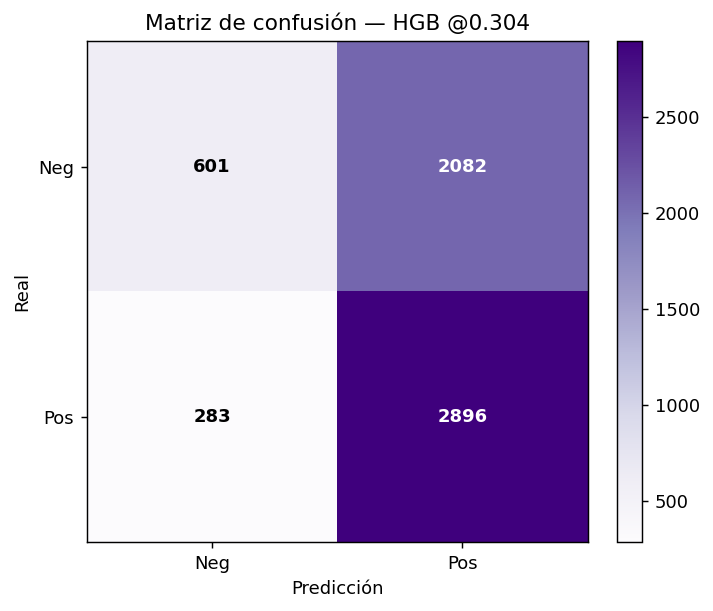

Mejor umbral: 0.304 | Métricas en test → F1=0.710, Recall=0.911, Prec=0.582, Acc=0.597, ROC-AUC=0.659

Classification report (@ mejor umbral):
               precision    recall  f1-score   support

           0      0.680     0.224     0.337      2683
           1      0.582     0.911     0.710      3179

    accuracy                          0.597      5862
   macro avg      0.631     0.567     0.524      5862
weighted avg      0.627     0.597     0.539      5862

✔ Archivos guardados en 'figs/' y 'results/'.


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix
)

FIGS = Path("figs"); FIGS.mkdir(exist_ok=True)
RESULTS = Path("results"); RESULTS.mkdir(exist_ok=True)

# 1) Tomo el mejor modelo por hold_f1
if 'resultados' not in globals():
    raise ValueError("No encuentro el DataFrame 'resultados' (corré la Celda 10 primero).")
best_row = resultados.iloc[0]
best_name = best_row['modelo']
print(f"Mejor modelo (por hold_f1): {best_name}")

# reconstruyo el pipeline del mejor modelo
best_clf = models[best_name]
best_pipe = Pipeline([("prep", pre), ("clf", best_clf)])
best_pipe.fit(X_train, y_train)

# 2) Probabilidades para test (o score continuo si no hay proba)
try:
    y_score = best_pipe.predict_proba(X_test)[:, 1]
except Exception:
    # decision_function → normalizo a [0,1] para trazar curvas
    s = best_pipe.decision_function(X_test)
    y_score = (s - s.min()) / (s.max() - s.min() + 1e-9)

# 3) Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

plt.figure(dpi=130)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", alpha=0.6)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — {best_name}")
plt.legend(loc="lower right")
plt.tight_layout(); plt.savefig(FIGS / f"roc_{best_name}.png", dpi=150); plt.show()

# 4) Curva Precision-Recall + mejor umbral (max F1)
prec, rec, thr = precision_recall_curve(y_test, y_score)
# 'thr' tiene len = len(prec)-1; ajusto para computar F1 bien
f1_vals = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = int(np.nanargmax(f1_vals))
best_thr = float(thr[best_idx])
ap = average_precision_score(y_test, y_score)

plt.figure(dpi=130)
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.scatter(rec[best_idx], prec[best_idx], s=60, zorder=3, label=f"Mejor F1 @ {best_thr:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision–Recall — {best_name}")
plt.legend()
plt.tight_layout(); plt.savefig(FIGS / f"pr_{best_name}.png", dpi=150); plt.show()

# 5) Matrices de confusión (umbral 0.5 y mejor umbral)
def plot_cm(y_true, y_sc, thr, title, fname):
    y_hat = (y_sc >= thr).astype(int)
    cm = confusion_matrix(y_true, y_hat)
    fig, ax = plt.subplots(dpi=130)
    im = ax.imshow(cm, cmap="Purples")
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center", color="white" if v>cm.max()*0.5 else "black", fontweight="bold")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Neg", "Pos"]); ax.set_yticklabels(["Neg", "Pos"])
    ax.set_xlabel("Predicción"); ax.set_ylabel("Real"); ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.savefig(FIGS / fname, dpi=150); plt.show()
    return y_hat

y_pred_05 = plot_cm(y_test, y_score, 0.5, f"Matriz de confusión — {best_name} @0.50", f"cm_{best_name}_050.png")
y_pred_bt = plot_cm(y_test, y_score, best_thr, f"Matriz de confusión — {best_name} @{best_thr:.3f}", f"cm_{best_name}_best.png")

# 6) Métricas al mejor umbral + classification report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def metricas(y_true, y_hat, y_scr):
    return {
        "accuracy": accuracy_score(y_true, y_hat),
        "precision": precision_score(y_true, y_hat, zero_division=0),
        "recall": recall_score(y_true, y_hat, zero_division=0),
        "f1": f1_score(y_true, y_hat, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_scr)
    }

m_best = metricas(y_test, y_pred_bt, y_score)
print(f"Mejor umbral: {best_thr:.3f} | Métricas en test → "
      f"F1={m_best['f1']:.3f}, Recall={m_best['recall']:.3f}, Prec={m_best['precision']:.3f}, "
      f"Acc={m_best['accuracy']:.3f}, ROC-AUC={m_best['roc_auc']:.3f}")

# Reporte clasificación @ mejor umbral
rep_txt = classification_report(y_test, y_pred_bt, digits=3, zero_division=0)
print("\nClassification report (@ mejor umbral):\n", rep_txt)

# Guardados
# tabla de umbrales con F1 (por si querés reportar)
thr_table = pd.DataFrame({
    "threshold": thr, "precision": prec[:-1], "recall": rec[:-1], "f1": f1_vals
})
thr_table.to_csv(RESULTS / f"thresholds_f1_{best_name}.csv", index=False, encoding="utf-8-sig")

# classification report a TXT
(RESULTS / f"classification_report_{best_name}.txt").write_text(
    f"Modelo: {best_name}\n"
    f"ROC-AUC: {roc_auc:.3f} | AP: {ap:.3f}\n"
    f"Mejor umbral: {best_thr:.3f}\n\n{rep_txt}",
    encoding="utf-8"
)

print("✔ Archivos guardados en 'figs/' y 'results/'.")


##Inferencia (carga pipeline + umbral y predice sobre CSV nuevo)
Requisitos:
- results/mejor_pipeline.pkl (si corriste Celda 11) O bien objetos de Celda 10 para recrear el mejor pipeline.
- results/best_threshold_*.json (generado en Celda 12).
1) Carga el pipeline "tuned" si existe; si no, reconstruye el mejor de Celda 10.
2) Carga el umbral óptimo (JSON de Celda 12). Si hay varios, elige el que matchee el modelo.
3) Lee un CSV de entrada, alinea columnas esperadas, predice probabilidades y etiquetas con el umbral.
4) Guarda un CSV con columnas: id (si hay), proba, pred_label, más (opcional) algunas columnas de referencia.

In [30]:
import numpy as np, pandas as pd, json, joblib
from pathlib import Path
from sklearn.pipeline import Pipeline

RESULTS = Path("results"); RESULTS.mkdir(exist_ok=True)

# Parámetros editables
INFER_CSV = Path("data/infer/nuevos_casos.csv")
ID_COLS_CANDIDATAS = ["id","id_caso","id_intervencion"]
REF_COLS = ["anio","mes","consultante_provincia","consultante_localidad","consultante_nacionalidad","es_anonima"]


# 1) Cargar pipeline (preferir calibrado; luego tuned; sino reconstruir desde Celda 14)
pipe_path_cal = RESULTS / "mejor_pipeline_calibrado.pkl"
pipe_path_tuned = RESULTS / "mejor_pipeline.pkl"
if pipe_path_cal.exists():
    pipe = joblib.load(pipe_path_cal); model_label = "calibrado"
elif pipe_path_tuned.exists():
    pipe = joblib.load(pipe_path_tuned); model_label = "tuned"
else:
    assert all(v in globals() for v in ["pre","resultados","models","X_train","y_train"]), \
        "No hay pipeline persistido ni objetos de Celda 14 (pre/resultados/models)."
    best_name = resultados.sort_values("hold_f1", ascending=False).iloc[0]["modelo"]
    pipe = Pipeline([("prep", pre), ("clf", models[best_name])])
    pipe.fit(X_train, y_train)
    model_label = f"reconstruido-{best_name}"

# 2) Cargar umbral óptimo
thr_json_cal = RESULTS / "best_threshold_calibrado.json"
thr_json_c16 = next(iter(RESULTS.glob("best_threshold_*_c16.json")), None)
if thr_json_cal.exists():
    best_thr = float(json.loads(thr_json_cal.read_text(encoding="utf-8"))["best_threshold"])
elif thr_json_c16 and thr_json_c16.exists():
    best_thr = float(json.loads(thr_json_c16.read_text(encoding="utf-8"))["best_threshold"])
else:
    best_thr = 0.50
print(f"Umbral usado para inferencia: {best_thr:.3f} ({model_label})")

# Helpers para alinear con el preprocesador
pre = pipe.named_steps["prep"]
def expected_input_columns(pre):
    cols = []
    for name, trans, sel in pre.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if isinstance(sel, (list, tuple, np.ndarray)):
            cols.extend(list(sel))
        elif sel is not None:
            cols.append(sel)
    return list(dict.fromkeys([str(c) for c in cols]))

def align_df_to_pre(X_df, pre):
    exp = expected_input_columns(pre)
    X = X_df.copy()
    missing = [c for c in exp if c not in X.columns]
    for c in missing:
        X[c] = np.nan
    X = X[exp]
    if missing:
        print(f"[Inferencia] Se agregaron {len(missing)} columnas faltantes: {missing[:10]}{'...' if len(missing)>10 else ''}")
    return X, exp

def predict_with_threshold(pipeline, X, thr):
    try:
        proba = pipeline.predict_proba(X)[:,1]
    except Exception:
        d = pipeline.decision_function(X)
        proba = (d - d.min())/(d.max()-d.min()+1e-9)
    pred = (proba >= thr).astype(int)
    return proba, pred

# 3) Si NO existe el CSV → crear plantilla y (si se puede) correr DEMO con X_test
if not INFER_CSV.exists():
    INFER_CSV.parent.mkdir(parents=True, exist_ok=True)
    exp_cols = expected_input_columns(pre)

    # Guardar PLANTILLA
    template_path = RESULTS / "inferencia_template_columns.csv"
    pd.DataFrame(columns=exp_cols).to_csv(template_path, index=False, encoding="utf-8-sig")
    print(f"⚠ No se encontró el archivo de entrada: {INFER_CSV}")
    print(f"→ Te dejé una PLANTILLA con las columnas esperadas en: {template_path}")

    # Si tenemos X_test disponible, generamos una inferencia DEMO para validar el flujo
    if "X_test" in globals():
        X_demo = pd.DataFrame(X_test).copy()
        X_demo, _ = align_df_to_pre(X_demo, pre)
        proba, pred = predict_with_threshold(pipe, X_demo, best_thr)

        # armar salida demo (sin ID fijo; agrego índice)
        out_demo = pd.DataFrame({"idx": np.arange(len(proba)), "proba": proba, "pred_label": pred})
        demo_path = RESULTS / "inferencia_DEMO_desde_Xtest.csv"
        out_demo.to_csv(demo_path, index=False, encoding="utf-8-sig")
        print(f"✔ También generé una inferencia DEMO con X_test: {demo_path}")
        display(out_demo.head())
    else:
        print("ℹ No hay X_test en memoria para DEMO. Cambiá INFER_CSV a tu archivo real y volvé a correr.")

# 4) Si SÍ existe el CSV → correr inferencia normal
else:
    new_df = pd.read_csv(INFER_CSV, low_memory=False)
    id_col = next((c for c in ID_COLS_CANDIDATAS if c in new_df.columns), None)

    X_inf, exp_cols = align_df_to_pre(new_df, pre)
    proba, pred = predict_with_threshold(pipe, X_inf, best_thr)

    cols_ref = [c for c in REF_COLS if c in new_df.columns]
    out = pd.DataFrame({
        **({id_col: new_df[id_col]} if id_col else {}),
        "proba": proba,
        "pred_label": pred
    })
    if cols_ref:
        out = pd.concat([out, new_df[cols_ref].reset_index(drop=True)], axis=1)

    stamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    out_path = RESULTS / f"inferencia_{model_label}_{stamp}.csv"
    out.to_csv(out_path, index=False, encoding="utf-8-sig")
    print(f"✔ Inferencia guardada en {out_path}")
    display(out.head())

Umbral usado para inferencia: 0.328 (tuned)
⚠ No se encontró el archivo de entrada: data\infer\nuevos_casos.csv
→ Te dejé una PLANTILLA con las columnas esperadas en: results\inferencia_template_columns.csv
✔ También generé una inferencia DEMO con X_test: results\inferencia_DEMO_desde_Xtest.csv


,idx,proba,pred_label
0,0,0.495138,1
1,1,0.680924,1
2,2,0.794248,1
3,3,0.845634,1
4,4,0.758789,1


##Interpretabilidad (alineada, robusta)

Calculando permutation importance...


,feature,importance_mean,importance_std
0,cat__origen_institucion - 145,0.049619,0.002610
1,num__trimestre,0.029359,0.002737
2,num__mes_cos,0.028614,0.003374
3,cat__situacion_Emergencia,0.011025,0.001624
4,num__provincia_indec_id,0.009837,0.001371
5,num__anio,0.008963,0.001614
6,cat__origen_institucion - accion catolica,0.004962,0.002615
7,cat__origen_institucion,0.003443,0.002398
8,num__es_fin_semana,0.003091,0.000796
9,num__mes_sin,0.002798,0.001178


✔ Importancias guardadas: results\pi_Tuned-HistGradientBoostingClassifier.csv


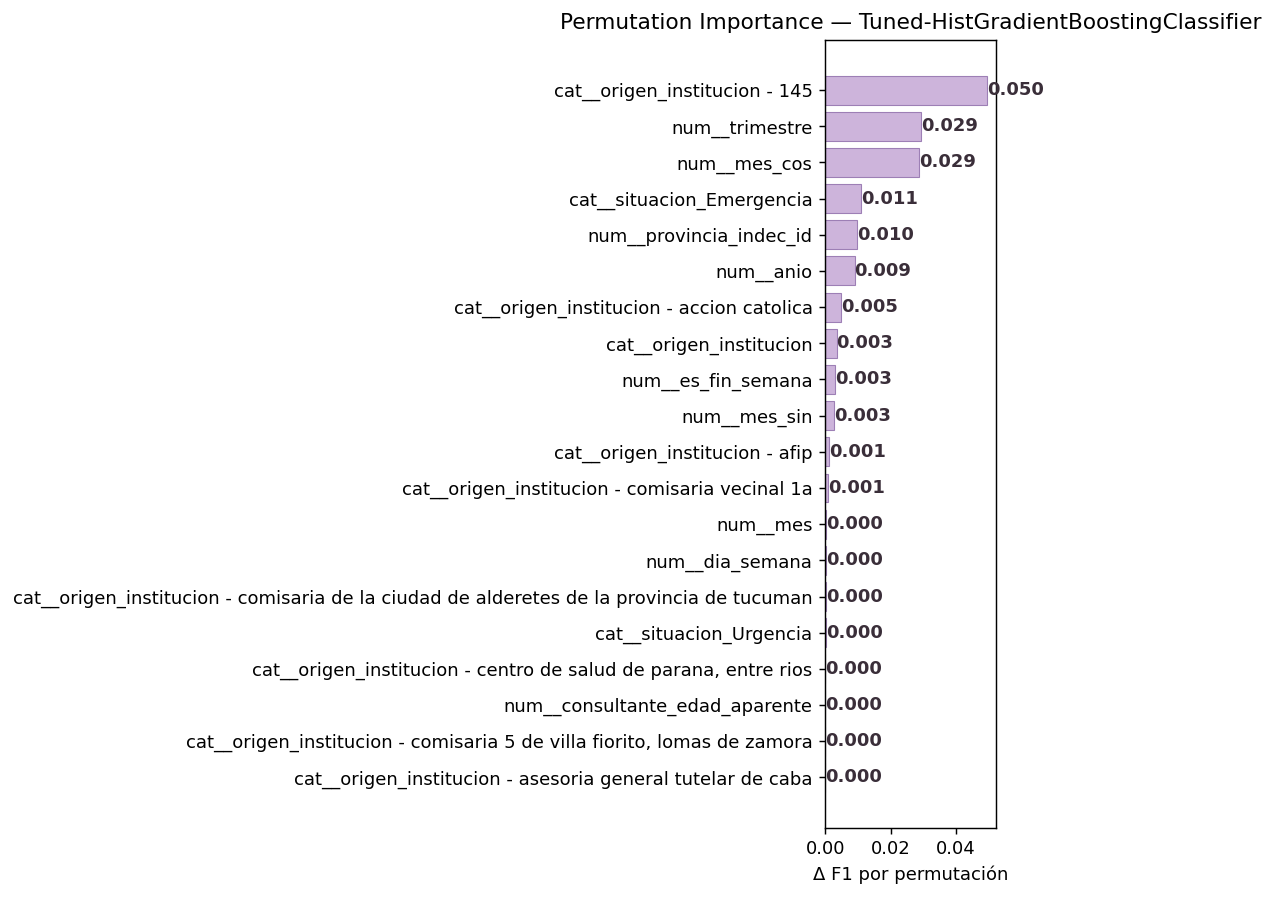

SHAP no disponible; omitiendo sección SHAP. (pip install shap)
Aviso PDP: no se pudo generar PDP para este modelo/feature set (Feature 'cat__origen_institucion - 145' not in feature_names).
✔ Celda 14 finalizada: gráficos en 'figs/' y tablas en 'results/'.


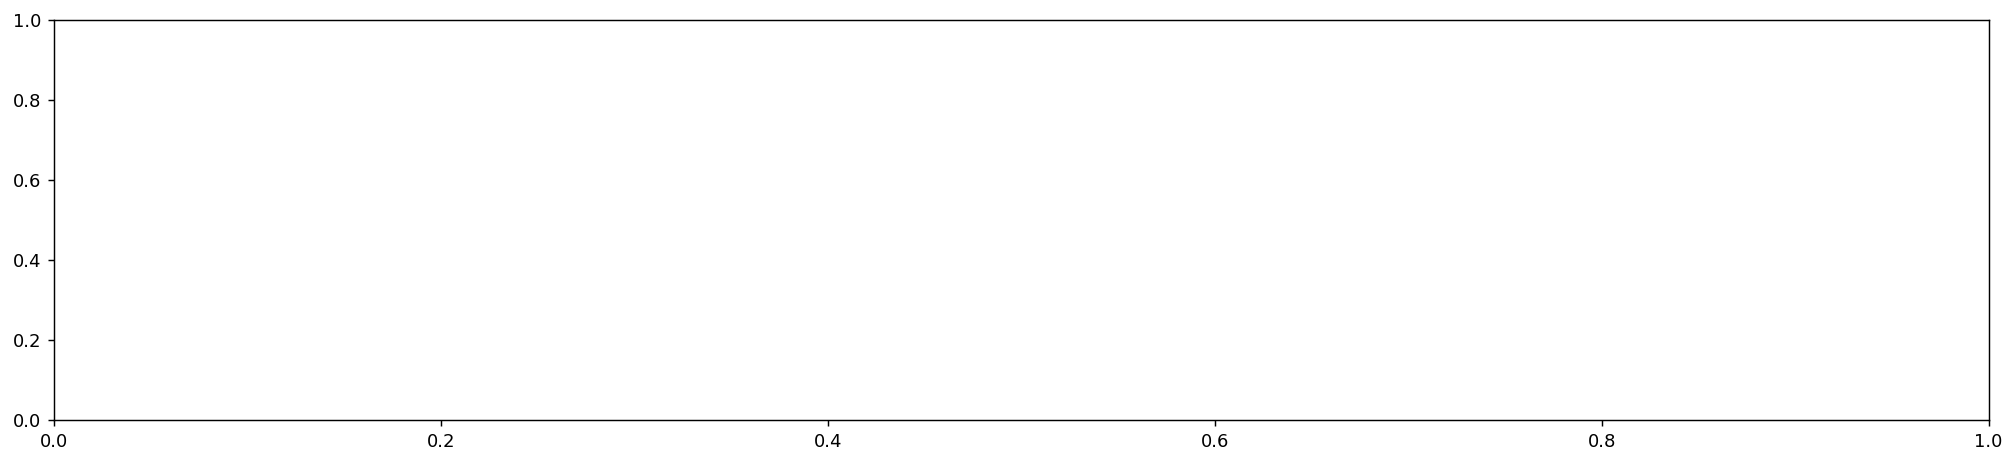

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

FIGS = Path("figs"); FIGS.mkdir(exist_ok=True)
RESULTS = Path("results"); RESULTS.mkdir(exist_ok=True)

# Parámetros editables
PREFER_TUNED = True
SELECT_FROM_10_BY = "hold_f1"
N_REPEATS_PI = 10
N_TOP_PI = 20
PDP_TOP = 6
RANDOM_STATE = 42
VIOLETA = "#CDB4DB"
BORDE   = "#9D7FB5"
# ==================================

# 0) Obtener pipeline a explicar
if PREFER_TUNED and ('best_pipe' in globals()):
    pipe = best_pipe
    model_label = "Tuned-" + pipe.named_steps['clf'].__class__.__name__
else:
    # reconstruyo mejor de la 10
    req = ["pre","models","X_train","y_train","resultados"]
    if not all(v in globals() for v in req):
        raise ValueError("Faltan objetos de la Celda 10 y no hay best_pipe. Corré la 10/11 antes.")
    if SELECT_FROM_10_BY not in resultados.columns:
        raise ValueError(f"No existe la columna '{SELECT_FROM_10_BY}' en 'resultados'.")
    best_name = resultados.sort_values(SELECT_FROM_10_BY, ascending=False).iloc[0]["modelo"]
    pipe = Pipeline([("prep", pre), ("clf", models[best_name])])
    pipe.fit(X_train, y_train)
    model_label = f"CV-{best_name}"

# 1) Alinear X_test a columnas esperadas por el pipeline
def align_to_expected(X_df, pipe, X_fallback=None):
    exp = getattr(pipe, "feature_names_in_", None)
    if exp is None and X_fallback is not None:
        exp = list(X_fallback.columns)
    if exp is None:
        return X_df
    X_aligned = X_df.copy()
    missing = [c for c in exp if c not in X_aligned.columns]
    for c in missing:
        X_aligned[c] = np.nan
    X_aligned = X_aligned[exp]
    if missing:
        print(f"[PI] Aviso: se agregaron {len(missing)} columnas faltantes en X_test: {missing}")
    return X_aligned

X_test_pi = align_to_expected(X_test, pipe, X_fallback=X_train)

# 2) Nombres de features post-preprocesamiento
def get_feature_names_from_pre(pre, X_ref):
    names = []
    for name, trans, cols in pre.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        cols = list(cols) if isinstance(cols, (list, tuple, np.ndarray)) else ([cols] if cols is not None else [])
        if hasattr(trans, "get_feature_names_out"):
            try:
                out = list(trans.get_feature_names_out(cols))
            except Exception:
                out = cols
        elif hasattr(trans, "named_steps") and "onehot" in trans.named_steps:
            oh = trans.named_steps["onehot"]
            try:
                out = list(oh.get_feature_names_out(cols))
            except Exception:
                # fallback rudimentario
                out = []
                for c, cats in zip(cols, getattr(oh, "categories_", [[]]*len(cols))):
                    out += [f"{c}_{cat}" for cat in cats]
        else:
            out = cols
        names.extend([str(x) for x in out])
    return np.array(names, dtype=object)

pre = pipe.named_steps["prep"]
try:
    feat_names = pipe[:-1].get_feature_names_out()  # sklearn >= 1.0
except Exception:
    feat_names = get_feature_names_from_pre(pre, X_train)

# 3) Permutation Importance (en TEST alineado)
print("Calculando permutation importance...")
pi = permutation_importance(
    pipe, X_test_pi, y_test,
    n_repeats=N_REPEATS_PI, random_state=RANDOM_STATE, n_jobs=-1, scoring="f1"
)

imp_df = (pd.DataFrame({
            "feature": feat_names[:len(pi.importances_mean)],
            "importance_mean": pi.importances_mean,
            "importance_std": pi.importances_std
         })
         .sort_values("importance_mean", ascending=False)
         .reset_index(drop=True))

imp_top = imp_df.head(N_TOP_PI)
display(imp_top)

imp_csv = RESULTS / f"pi_{model_label}.csv"
imp_df.to_csv(imp_csv, index=False, encoding="utf-8-sig")
print(f"✔ Importancias guardadas: {imp_csv}")

# Plot
plt.figure(figsize=(8, max(4, 0.35*len(imp_top))), dpi=130)
vals = imp_top["importance_mean"].values[::-1]
labels = imp_top["feature"].astype(str).values[::-1]
bars = plt.barh(labels, vals, color=VIOLETA, edgecolor=BORDE, linewidth=0.6)
for r, v in zip(bars, vals):
    plt.text(v if v>0 else 0, r.get_y()+r.get_height()/2, f"{v:.3f}",
             va="center", ha="left" if v>=0 else "right", color="#3A2E39", fontweight="bold")
plt.title(f"Permutation Importance — {model_label}")
plt.xlabel("Δ F1 por permutación")
plt.tight_layout()
plt.savefig(FIGS / f"pi_{model_label}.png", dpi=150)
plt.show()

# 4) SHAP (opcional; se omite si no está instalado o no soporta el estimador) ---
try:
    import shap
    shap_available = True
except Exception:
    shap_available = False
    print("SHAP no disponible; omitiendo sección SHAP. (pip install shap)")

if shap_available:
    try:
        X_test_trans = pre.transform(X_test_pi)
        clf = pipe.named_steps["clf"]
        try:
            explainer = shap.Explainer(clf, X_test_trans, feature_names=feat_names)
            shap_values = explainer(X_test_trans)
        except Exception:
            explainer = shap.TreeExplainer(clf)
            shap_values = explainer.shap_values(X_test_trans)

        shap.summary_plot(shap_values, X_test_trans, feature_names=feat_names, show=False)
        plt.tight_layout(); plt.savefig(FIGS / f"shap_summary_{model_label}.png", dpi=150); plt.show()

        shap.summary_plot(shap_values, X_test_trans, feature_names=feat_names, plot_type="dot", show=False)
        plt.tight_layout(); plt.savefig(FIGS / f"shap_beeswarm_{model_label}.png", dpi=150); plt.show()
    except Exception as e:
        print(f"Aviso SHAP: no se pudo generar explicación ({e}).")

# 5) PDP (partial dependence) de las top features (si soporta)
try:
    top_feats = imp_top["feature"].tolist()[:PDP_TOP]
    fig_w = max(8, 3.2 * min(PDP_TOP, len(top_feats)))
    fig, ax = plt.subplots(figsize=(fig_w, 4), dpi=130)
    PartialDependenceDisplay.from_estimator(pipe, X_test_pi, features=top_feats, kind="average", ax=ax)
    plt.suptitle(f"PDP — {model_label}", y=1.03)
    plt.tight_layout()
    plt.savefig(FIGS / f"pdp_{model_label}.png", dpi=150)
    plt.show()
except Exception as e:
    print(f"Aviso PDP: no se pudo generar PDP para este modelo/feature set ({e}).")

print("✔ Celda 14 finalizada: gráficos en 'figs/' y tablas en 'results/'.")



## Calibración de probabilidades + umbral estable (con alineado de columnas)

No calibrado → {'brier': 0.24301563993040448, 'roc_auc': 0.6591698432817771, 'ap': 0.6838195829436405}
Calibrado    → {'brier': 0.23385975674870976, 'roc_auc': 0.6568739223123421, 'ap': 0.6847405999692453}


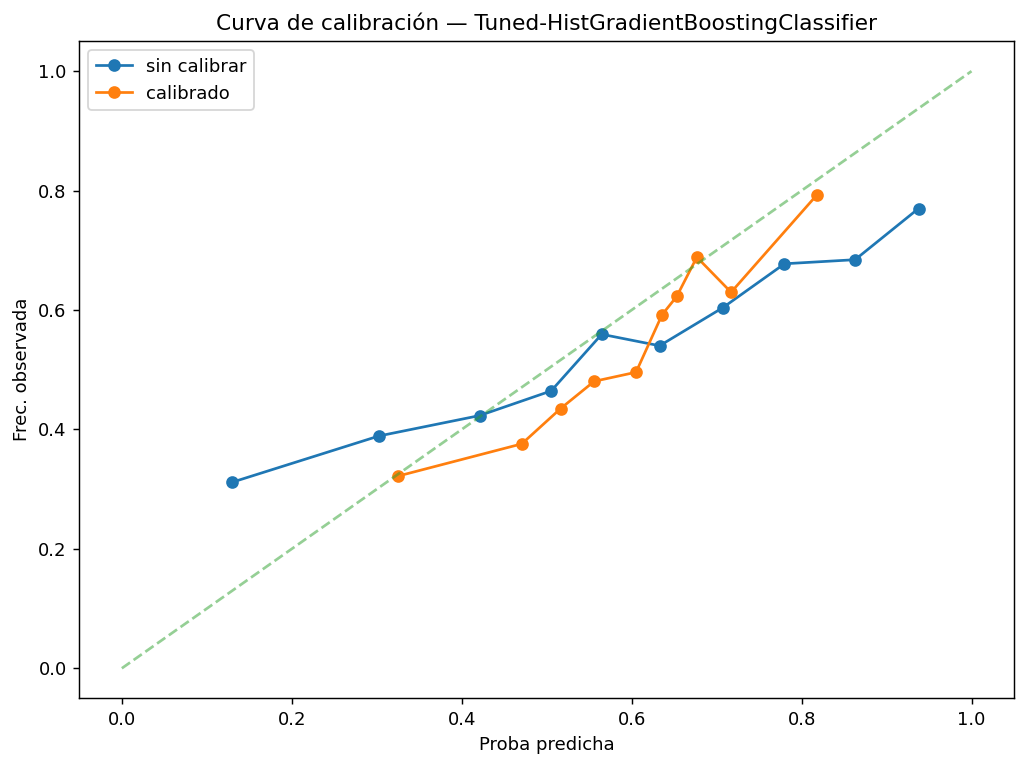

Umbral óptimo calibrado: 0.396 | target recall ≥ 0.80
Métricas @0.50: {'precision': 0.5910064239828694, 'recall': 0.8681975463982384, 'f1': 0.703274302458912}
Métricas @opt : {'precision': 0.5619117918435136, 'recall': 0.9578483799937088, 'f1': 0.7083042568039079}


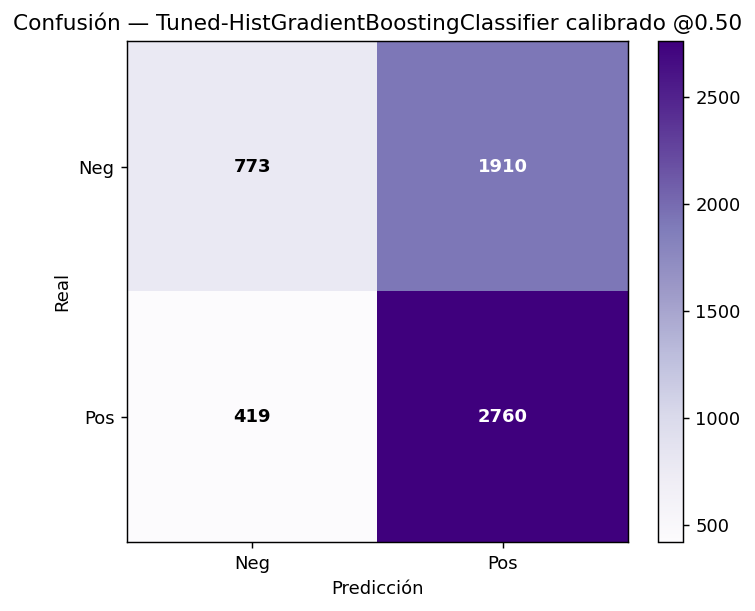

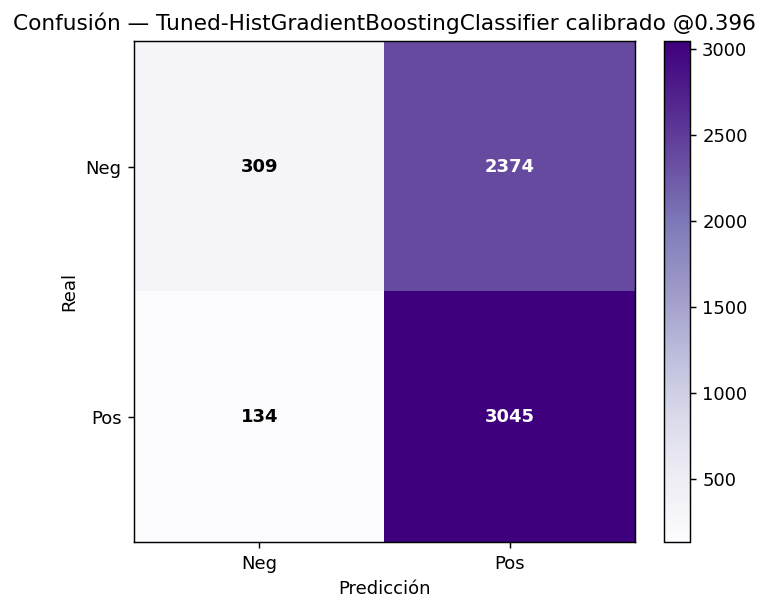

✔ Guardado:
  - C:\aprendizajeAutomatico\repo\deteccion_trata\deteccionTrata\results\mejor_pipeline_calibrado.pkl
  - C:\aprendizajeAutomatico\repo\deteccion_trata\deteccionTrata\results\best_threshold_calibrado.json
  - C:\aprendizajeAutomatico\repo\deteccion_trata\deteccionTrata\results\calibration_summary.csv
  - C:\aprendizajeAutomatico\repo\deteccion_trata\deteccionTrata\figs\calibracion_reliability.png
  - C:\aprendizajeAutomatico\repo\deteccion_trata\deteccionTrata\figs\calibration_Tuned-HistGradientBoostingClassifier.png
  - C:\aprendizajeAutomatico\repo\deteccion_trata\deteccionTrata\figs\cm_cal_Tuned-HistGradientBoostingClassifier_050.png
  - C:\aprendizajeAutomatico\repo\deteccion_trata\deteccionTrata\figs\cm_cal_Tuned-HistGradientBoostingClassifier_opt.png


In [65]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    brier_score_loss, roc_auc_score, average_precision_score,
    precision_recall_curve, confusion_matrix, precision_score, recall_score, f1_score
)
from IPython.display import display
import joblib, json, re

# ------------------- Ubicación de carpetas (siempre en la RAÍZ del repo) -------------------
def find_repo_root(start: Path) -> Path:
    cur = start.resolve()
    for _ in range(12):
        if (cur / ".git").exists():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    return start.resolve()

REPO = find_repo_root(Path.cwd())
FIGS = (REPO / "figs");    FIGS.mkdir(parents=True, exist_ok=True)
RESULTS = (REPO / "results"); RESULTS.mkdir(parents=True, exist_ok=True)

# ------------------- Tomo modelo base y preprocesador -------------------
if 'best_pipe' in globals():
    base_est = best_pipe.named_steps['clf']          # clasificador
    pre      = best_pipe.named_steps['prep']         # preprocesador
    model_label = "Tuned-" + base_est.__class__.__name__
else:
    assert all(v in globals() for v in ['pre','models','resultados','X_train','y_train','X_test','y_test']), \
        "Faltan objetos (pre/models/resultados/X_*/y_*). Correr celdas anteriores."
    best_name = resultados.sort_values('hold_f1', ascending=False).iloc[0]['modelo']
    base_est  = models[best_name]
    model_label = f"CV-{best_name}"

# Nombre de archivo seguro
safe_model = re.sub(r'[^A-Za-z0-9._-]+','_', model_label)

# ------------------- Alineado de columnas a lo que espera el preprocesador -------------------
def expected_input_columns(pre):
    cols = []
    for name, trans, sel in pre.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        if isinstance(sel, (list, tuple, np.ndarray)):
            cols.extend(list(sel))
        elif sel is not None:
            cols.append(sel)
    return list(dict.fromkeys([str(c) for c in cols]))

def align_df_to_pre(X_df, pre):
    exp = expected_input_columns(pre)
    X_al = X_df.copy()
    missing = [c for c in exp if c not in X_al.columns]
    for c in missing:
        X_al[c] = np.nan
    X_al = X_al[exp]
    if missing:
        print(f"[Calibración] Se agregaron {len(missing)} columnas faltantes: {missing}")
    return X_al

X_train_cal = align_df_to_pre(X_train, pre)
X_test_cal  = align_df_to_pre(X_test,  pre)

# ------------------- 1) Calibración isotónica con CV -------------------
cal_clf  = CalibratedClassifierCV(estimator=base_est, method="isotonic", cv=5)
cal_pipe = Pipeline([("prep", pre), ("clf", cal_clf)])
cal_pipe.fit(X_train_cal, y_train)

# ------------------- 2) Scores sin calibrar vs calibrado -------------------
def get_scores(pipeline, X):
    try:
        return pipeline.predict_proba(X)[:,1]
    except Exception:
        d = pipeline.decision_function(X)
        return (d - d.min())/(d.max()-d.min() + 1e-9)

pipe_ref = Pipeline([("prep", pre), ("clf", base_est)])
pipe_ref.fit(X_train_cal, y_train)

s_ref = get_scores(pipe_ref, X_test_cal)
s_cal = get_scores(cal_pipe,  X_test_cal)

def summary_scores(y, s):
    return dict(
        brier=brier_score_loss(y, s),
        roc_auc=roc_auc_score(y, s),
        ap=average_precision_score(y, s)
    )

sum_ref = summary_scores(y_test, s_ref)
sum_cal = summary_scores(y_test, s_cal)

print("No calibrado →", sum_ref)
print("Calibrado    →", sum_cal)

# ------------------- 3) Curva de calibración (guarda y muestra) -------------------
fig, ax = plt.subplots(figsize=(8,6), dpi=130)
for sco, lab in [(s_ref, "sin calibrar"), (s_cal, "calibrado")]:
    prob_true, prob_pred = calibration_curve(y_test, sco, n_bins=10, strategy="quantile")
    ax.plot(prob_pred, prob_true, marker='o', label=lab)
ax.plot([0,1],[0,1], '--', alpha=.5)
ax.set_xlabel("Proba predicha"); ax.set_ylabel("Frec. observada")
ax.set_title(f"Curva de calibración — {model_label}")
ax.legend()
fig.tight_layout()

# Nombre estable para README + copia con nombre del modelo
path_readme = FIGS / "calibracion_reliability.png"
path_model  = FIGS / f"calibration_{safe_model}.png"
fig.savefig(path_readme, dpi=200, bbox_inches="tight")
fig.savefig(path_model,  dpi=200, bbox_inches="tight")
display(fig)
plt.close(fig)

# ------------------- 4) Umbral con objetivo de recall -------------------
RECALL_TARGET = globals().get("RECALL_TARGET", 0.80)
prec, rec, thr = precision_recall_curve(y_test, s_cal)
prec_m, rec_m = prec[:-1], rec[:-1]
f1_vals = 2*(prec_m*rec_m)/(prec_m+rec_m+1e-12)
idx_ok = np.where(rec_m >= RECALL_TARGET)[0]
best_idx = idx_ok[np.argmax(f1_vals[idx_ok])] if len(idx_ok) else int(np.nanargmax(f1_vals))
thr_opt = float(thr[best_idx])

# ------------------- 5) Matrices de confusión @0.50 vs @óptimo -------------------
def report_umbral(scores, thr):
    yhat = (scores>=thr).astype(int)
    cm = confusion_matrix(y_test, yhat)
    met = dict(
        precision=precision_score(y_test,yhat,zero_division=0),
        recall=recall_score(y_test,yhat,zero_division=0),
        f1=f1_score(y_test,yhat,zero_division=0)
    )
    return yhat, met, cm

y050, met050, cm050 = report_umbral(s_cal, 0.50)
yopt, metopt, cmopt = report_umbral(s_cal, thr_opt)

print(f"Umbral óptimo calibrado: {thr_opt:.3f} | target recall ≥ {RECALL_TARGET:.2f}")
print("Métricas @0.50:", met050)
print("Métricas @opt :", metopt)

def plot_cm(cm, title, fname):
    fig, ax = plt.subplots(dpi=130)
    im = ax.imshow(cm, cmap="Purples")
    vmax = cm.max() if cm.size else 1
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v),
                ha="center", va="center",
                color=("white" if v>0.5*vmax else "black"),
                fontweight="bold")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Neg","Pos"]); ax.set_yticklabels(["Neg","Pos"])
    ax.set_xlabel("Predicción"); ax.set_ylabel("Real"); ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    out = FIGS / fname
    fig.savefig(out, dpi=200, bbox_inches="tight")
    display(fig)
    plt.close(fig)
    return out

p_cm050 = plot_cm(cm050, f"Confusión — {model_label} calibrado @0.50", f"cm_cal_{safe_model}_050.png")
p_cmopt = plot_cm(cmopt, f"Confusión — {model_label} calibrado @{thr_opt:.3f}", f"cm_cal_{safe_model}_opt.png")

# ------------------- 6) Guardados -------------------
joblib.dump(cal_pipe, RESULTS / "mejor_pipeline_calibrado.pkl")
json.dump(
    {
        "model": model_label,
        "best_threshold": thr_opt,
        "recall_target": RECALL_TARGET,
        "calibration": {"brier": sum_cal["brier"], "roc_auc": sum_cal["roc_auc"], "ap": sum_cal["ap"]}
    },
    open(RESULTS / "best_threshold_calibrado.json","w",encoding="utf-8"),
    ensure_ascii=False, indent=2
)

pd.DataFrame([
    {
        "modelo":model_label, "set":"TEST",
        "brier_ref":sum_ref["brier"], "brier_cal":sum_cal["brier"],
        "roc_auc_ref":sum_ref["roc_auc"], "roc_auc_cal":sum_cal["roc_auc"],
        "ap_ref":sum_ref["ap"], "ap_cal":sum_cal["ap"],
        "thr_opt":thr_opt, **{f"opt_{k}":v for k,v in metopt.items()},
        **{f"050_{k}":v for k,v in met050.items()}
    }
]).to_csv(RESULTS / "calibration_summary.csv", index=False, encoding="utf-8-sig")

print("✔ Guardado:")
print("  -", (RESULTS / "mejor_pipeline_calibrado.pkl").resolve())
print("  -", (RESULTS / "best_threshold_calibrado.json").resolve())
print("  -", (RESULTS / "calibration_summary.csv").resolve())
print("  -", path_readme.resolve())
print("  -", path_model.resolve())
print("  -", p_cm050.resolve())
print("  -", p_cmopt.resolve())


##Backtesting temporal (rolling origin)

In [33]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, recall_score, precision_score
from pandas.api.types import is_numeric_dtype, is_bool_dtype, is_categorical_dtype

# --------- Helpers ---------
def _find_col(df, candidates):
    import unicodedata
    def norm(s):
        s = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
        return s.casefold()
    m = {norm(c): c for c in df.columns}
    for cand in candidates:
        if norm(cand) in m:
            return m[norm(cand)]
    for col in df.columns:
        if any(norm(cand) in norm(col) for cand in candidates):
            return col
    raise KeyError(f"No se encontró ninguna de las columnas {candidates} en {list(df.columns)}")

def _to_month(v):
    meses = {
        'ene':1,'enero':1, 'feb':2,'febrero':2, 'mar':3,'marzo':3, 'abr':4,'abril':4,
        'may':5,'mayo':5, 'jun':6,'junio':6, 'jul':7,'julio':7, 'ago':8,'agosto':8,
        'sep':9,'set':9,'sept':9,'septiembre':9, 'oct':10,'octubre':10,
        'nov':11,'noviembre':11, 'dic':12,'diciembre':12
    }
    if pd.isna(v):
        return np.nan
    try:
        vv = int(v)
        if 1 <= vv <= 12:
            return vv
    except Exception:
        pass
    s = str(v).strip().lower().replace('.', '').replace(',', '')
    if s in meses:
        return meses[s]
    if len(s) >= 3 and s[:3] in meses:
        return meses[s[:3]]
    return np.nan

# --------- 1) Detectar columnas de año y mes ---------
ANIO_COL = _find_col(data, ['anio', 'año', 'ANIO', 'AÑO'])
MES_COL  = _find_col(data, ['mes', 'MES'])

# --------- 2) Normalizar año/mes ----------
anio = pd.to_numeric(data[ANIO_COL], errors='coerce').astype('Int64')
mes  = data[MES_COL].map(_to_month).astype('Int64')

if anio.isna().any() or mes.isna().any():
    n_bad = int(anio.isna().sum() + mes.isna().sum())
    print(f"⚠️ Advertencia: hay {n_bad} valores de año/mes no interpretables; se descartan esas filas.")

df_bt = data.assign(_anio=anio, _mes=mes).dropna(subset=['_anio','_mes']).copy()
df_bt['_anio'] = df_bt['_anio'].astype(int)
df_bt['_mes']  = df_bt['_mes'].astype(int)

# --------- 3) Crear fecha (primer día del mes) y ordenar ----------
df_bt['fecha'] = pd.to_datetime(dict(year=df_bt['_anio'], month=df_bt['_mes'], day=1), errors='coerce')
df_bt = df_bt.dropna(subset=['fecha']).sort_values('fecha').reset_index(drop=True)

# --------- 4) Definir target y features ----------
TARGET_COL = _find_col(df_bt, ['es_trata', 'target', 'label', 'y'])
y = df_bt[TARGET_COL].astype(int)

drop_cols = [TARGET_COL, '_anio', '_mes']
X = df_bt.drop(columns=drop_cols, errors='ignore').copy()

# ===== FIX DTYPE: detectar columnas numéricas/categóricas de forma robusta =====
# 1) detectar booleanas y pasarlas a int (para evitar fallas en OHE)
bool_cols = [c for c in X.columns if is_bool_dtype(X[c])]
if bool_cols:
    X.loc[:, bool_cols] = X[bool_cols].astype('int8')

# 2) numéricas: usan is_numeric_dtype (soporta Int64/Float64 de pandas)
num_cols = [c for c in X.columns if is_numeric_dtype(X[c])]

# 3) categóricas/objetos: object o category
cat_cols = [c for c in X.columns
            if (X[c].dtype == 'object') or is_categorical_dtype(X[c])]

# Evitar columnas vacías en transformadores
transformers = []
if num_cols:
    transformers.append(('num', StandardScaler(with_mean=False), num_cols))
if cat_cols:
    transformers.append(('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols))

# Si no tenés best_pipe definido en celdas anteriores, construimos uno simple
if 'BEST_PIPE' in globals():
    modelo_base = BEST_PIPE
elif 'best_pipe' in globals():
    modelo_base = best_pipe
elif 'mejor_pipeline' in globals():
    modelo_base = mejor_pipeline
else:
    pre = ColumnTransformer(transformers=transformers, remainder='drop')
    modelo_base = Pipeline(steps=[
        ('pre', pre),
        ('clf', LogisticRegression(max_iter=200, class_weight='balanced'))
    ])

# --------- 5) Backtesting mensual (expansivo) ----------
# unique() -> PeriodArray (sin sort_values). Convertimos a PeriodIndex y ordenamos.
pidx = pd.PeriodIndex(df_bt['fecha'].dt.to_period('M'))
periodos = pidx.sort_values().unique()  # PeriodIndex ordenado y único

resultados = []

# Dejar 6 meses de historial mínimo (ajustá si querés)
burn_in = 6
if len(periodos) <= burn_in:
    raise ValueError(
        f"No hay suficientes meses para backtesting: {len(periodos)} disponibles, "
        f"se requieren > {burn_in}."
    )

for t in periodos[burn_in:]:
    mask_train = df_bt['fecha'].dt.to_period('M') < t
    mask_test  = df_bt['fecha'].dt.to_period('M') == t

    if mask_train.sum() == 0 or mask_test.sum() == 0:
        continue

    X_tr, y_tr = X.loc[mask_train], y.loc[mask_train]
    X_te, y_te = X.loc[mask_test],  y.loc[mask_test]

    from sklearn.base import clone
    modelo = clone(modelo_base)

    modelo.fit(X_tr, y_tr)
    y_hat = modelo.predict(X_te)

    resultados.append({
        'periodo': str(t),
        'n_train': int(mask_train.sum()),
        'n_test': int(mask_test.sum()),
        'precision': float(precision_score(y_te, y_hat, zero_division=0)),
        'recall': float(recall_score(y_te, y_hat, zero_division=0)),
        'f1': float(f1_score(y_te, y_hat, zero_division=0))
    })

bt_df = pd.DataFrame(resultados).sort_values('periodo')
display(bt_df.head(12))
display(bt_df.tail(12))

if not bt_df.empty:
    print("\n== Promedios Backtesting ==")
    print(bt_df[['precision','recall','f1']].mean().round(3))
else:
    print("No se generaron pliegues de backtesting. Revisá que haya meses suficientes.")


⚠️ Advertencia: hay 9508 valores de año/mes no interpretables; se descartan esas filas.


,periodo,n_train,n_test,precision,recall,f1
0,2020-07,286,43,0.529412,0.529412,0.529412
1,2020-08,329,30,0.473684,0.600000,0.529412
2,2020-09,359,48,0.529412,0.409091,0.461538
3,2020-10,407,40,0.562500,0.375000,0.450000
4,2020-11,447,35,0.545455,0.631579,0.585366
5,2020-12,482,32,0.583333,0.411765,0.482759
6,2021-01,514,51,0.800000,0.133333,0.228571
7,2021-02,565,46,0.781250,0.862069,0.819672
8,2021-03,611,64,0.613636,0.710526,0.658537
9,2021-04,675,36,0.607143,0.772727,0.680000


,periodo,n_train,n_test,precision,recall,f1
42,2024-01,2325,49,0.600000,0.777778,0.677419
43,2024-02,2374,78,0.688889,0.673913,0.681319
44,2024-03,2452,63,0.717391,0.846154,0.776471
45,2024-04,2515,65,0.651163,0.800000,0.717949
46,2024-05,2580,64,0.540541,0.689655,0.606061
47,2024-06,2644,53,0.576923,0.681818,0.625000
48,2024-07,2697,56,0.680000,0.586207,0.629630
49,2024-08,2753,68,0.550000,0.666667,0.602740
50,2024-09,2821,73,0.571429,0.750000,0.648649
51,2024-10,2894,56,0.714286,0.757576,0.735294



== Promedios Backtesting ==
precision    0.647
recall       0.686
f1           0.651
dtype: float64


##Tablas χ² (mes/temporada, provincia/ciudad, nacionalidad, anonimato × es_trata) con % fila/columna

In [34]:
import numpy as np, pandas as pd
from scipy.stats import chi2_contingency
from pathlib import Path
from IPython.display import display

RESULTS = Path("results"); RESULTS.mkdir(exist_ok=True)

base = globals().get("df_tmp", globals().get("df")).copy()
assert base is not None, "No encuentro df_tmp/df."

# Aseguro 'mes' y 'temporada'
if "mes" not in base.columns:
    cand = [c for c in base.columns if c.lower() in ("fecha","fecharegistro","fecha_hecho","fecha_caso")]
    assert len(cand)>0, "No hay 'mes' ni columna de fecha."
    fcol = cand[0]; base[fcol] = pd.to_datetime(base[fcol], errors="coerce")
    base["mes"] = base[fcol].dt.month

temporada = {12:"verano",1:"verano",2:"verano",3:"otonio",4:"otonio",5:"otonio",
             6:"invierno",7:"invierno",8:"invierno",9:"primavera",10:"primavera",11:"primavera"}
base["temporada"] = base["mes"].map(temporada).fillna("desconocido")

# Aseguro binario
base["es_trata"] = pd.to_numeric(base["es_trata"], errors="coerce").fillna(0).astype(int)

pares = [
    ("mes", "es_trata"),
    ("temporada", "es_trata"),
    ("consultante_provincia", "es_trata"),
    ("consultante_localidad", "es_trata"),
    ("consultante_nacionalidad", "es_trata"),
    ("es_anonima", "es_trata"),
]

def tabla_chi(df, var, y="es_trata"):
    tb = pd.crosstab(df[var], df[y])
    chi2, p, dof, _ = chi2_contingency(tb, correction=False)
    tb_pct_fila = (tb.div(tb.sum(axis=1), axis=0)*100).round(2)
    tb_pct_col  = (tb.div(tb.sum(axis=0), axis=1)*100).round(2)
    return tb, tb_pct_fila, tb_pct_col, chi2, p, dof

resumen = []
for var, y in pares:
    if var not in base.columns:
        print(f"[χ²] salteado: {var} no existe");
        continue
    tb, pf, pc, chi2, p, dof = tabla_chi(base, var, y)
    tb.to_csv(RESULTS / f"chi2_{var}_abs.csv", encoding="utf-8-sig")
    pf.to_csv(RESULTS / f"chi2_{var}_pctfila.csv", encoding="utf-8-sig")
    pc.to_csv(RESULTS / f"chi2_{var}_pctcol.csv", encoding="utf-8-sig")
    resumen.append({"variable": var, "chi2": chi2, "p_value": p, "dof": dof, "niveles": tb.shape[0]})

chi_sum = pd.DataFrame(resumen).sort_values("p_value")
display(chi_sum)
chi_sum.to_csv(RESULTS / "chi2_resumen.csv", index=False, encoding="utf-8-sig")
print("✔ χ² guardado (abs, %fila, %col) por variable.")


,variable,chi2,p_value,dof,niveles
4,consultante_nacionalidad,148.786538,4.228331e-23,17,18
2,consultante_provincia,126.006660,8.156240e-16,24,25
5,es_anonima,46.507023,9.129066e-12,1,2
3,consultante_localidad,499.575048,2.958395e-09,328,329
0,mes,20.739830,3.616888e-02,11,12
1,temporada,7.338306,1.190544e-01,4,5


✔ χ² guardado (abs, %fila, %col) por variable.


##Logística con interacciones (temporada×anonimato, provincia×anonimato, nacionalidad×temporada) + Recall y TDF

In [ ]:
import numpy as np, pandas as pd, sklearn
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, recall_score, f1_score, precision_score, roc_auc_score

RESULTS = Path("results"); RESULTS.mkdir(exist_ok=True)

base = globals().get("df_tmp", globals().get("df")).copy()
assert base is not None, "No encuentro df_tmp/df."

# Variables necesarias 
need = ["es_trata","mes","temporada","consultante_provincia","consultante_localidad",
        "consultante_nacionalidad","es_anonima"]
for c in need:
    if c not in base.columns:
        base[c] = np.nan

# Target binario
y = pd.to_numeric(base["es_trata"], errors="coerce").fillna(0).astype(int)

# Subset de features de consigna
X = base[["mes","temporada","consultante_provincia","consultante_nacionalidad","es_anonima"]].copy()

# Tipos
num_cols = ["mes"]
cat_cols = ["temporada","consultante_provincia","consultante_nacionalidad","es_anonima"]

# Compatibilidad OneHotEncoder (sparse_output vs sparse)
OHE_KW = {"handle_unknown": "ignore"}
ver = tuple(map(int, sklearn.__version__.split(".")[:2]))
if ver >= (1, 2):
    OHE_KW["sparse_output"] = False
else:
    OHE_KW["sparse"] = False

# Preprocesamiento
num_tf = Pipeline([("imp", SimpleImputer(strategy="median")),
                   ("sc", StandardScaler(with_mean=False))])
cat_tf = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                   ("oh", OneHotEncoder(**OHE_KW))])

pre = ColumnTransformer([("num", num_tf, num_cols),
                         ("cat", cat_tf, cat_cols)])

# Interacciones de 2º orden (solo interacciones, sin términos cuadráticos)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

logit = LogisticRegression(max_iter=300, class_weight="balanced", solver="lbfgs")

pipe = Pipeline([
    ("pre", pre),
    ("poly", poly),
    ("clf", logit)
])

# Split 80/20 estratificado (análisis puntual de interacciones)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pipe.fit(X_tr, y_tr)

# Scores y umbral por PR (objetivo Recall)
def scores(p, X):
    try:    return p.predict_proba(X)[:,1]
    except:
        d = p.decision_function(X);
        return (d - d.min())/(d.max()-d.min()+1e-9)

s = scores(pipe, X_te)
prec, rec, thr = precision_recall_curve(y_te, s)
f1_vals = 2*(prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)

RECALL_TARGET = globals().get("RECALL_TARGET", 0.80)
idx_ok = np.where(rec[:-1] >= RECALL_TARGET)[0]
best_idx = idx_ok[np.argmax(f1_vals[idx_ok])] if len(idx_ok) else int(np.nanargmax(f1_vals))
thr_opt = float(thr[best_idx])

yhat = (s >= thr_opt).astype(int)
res = {
    "precision": precision_score(y_te, yhat, zero_division=0),
    "recall":    recall_score(y_te, yhat, zero_division=0),
    "f1":        f1_score(y_te, yhat, zero_division=0),
    "roc_auc":   roc_auc_score(y_te, s)
}
print("Métricas Logística + interacciones (test):", res, "| umbral_opt:", round(thr_opt,3))

# Evaluación en TDF (transferencia con el MISMO umbral)
mask_tdf = base.get("consultante_provincia","").astype(str).str.lower().str.contains("tierra del fuego")
X_tdf = X.loc[mask_tdf].copy(); y_tdf = y.loc[mask_tdf].copy()
if len(X_tdf) >= 1:
    s_tdf = scores(pipe, X_tdf)
    yhat_tdf = (s_tdf >= thr_opt).astype(int)
    res_tdf = {
        "n": len(X_tdf),
        "positivos": int(y_tdf.sum()),
        "precision": precision_score(y_tdf, yhat_tdf, zero_division=0),
        "recall":    recall_score(y_tdf, yhat_tdf, zero_division=0),
        "f1":        f1_score(y_tdf, yhat_tdf, zero_division=0)
    }
    print("TDF — métricas con el mismo umbral:", res_tdf)
else:
    print("No hay filas de TDF para evaluar la transferencia en esta celda.")

# Guardados
pd.DataFrame([res]).to_csv(RESULTS / "interacciones_logit_metrics.csv", index=False, encoding="utf-8-sig")


Métricas Logística + interacciones (test): {'precision': 0.5604321404456448, 'recall': 0.9787735849056604, 'f1': 0.712752254186346, 'roc_auc': 0.6228211728427325} | umbral_opt: 0.324
TDF — métricas con el mismo umbral: {'n': 30, 'positivos': 22, 'precision': 0.7333333333333333, 'recall': 1.0, 'f1': 0.8461538461538461}


##Serie mensual + gráfico legible + exportación

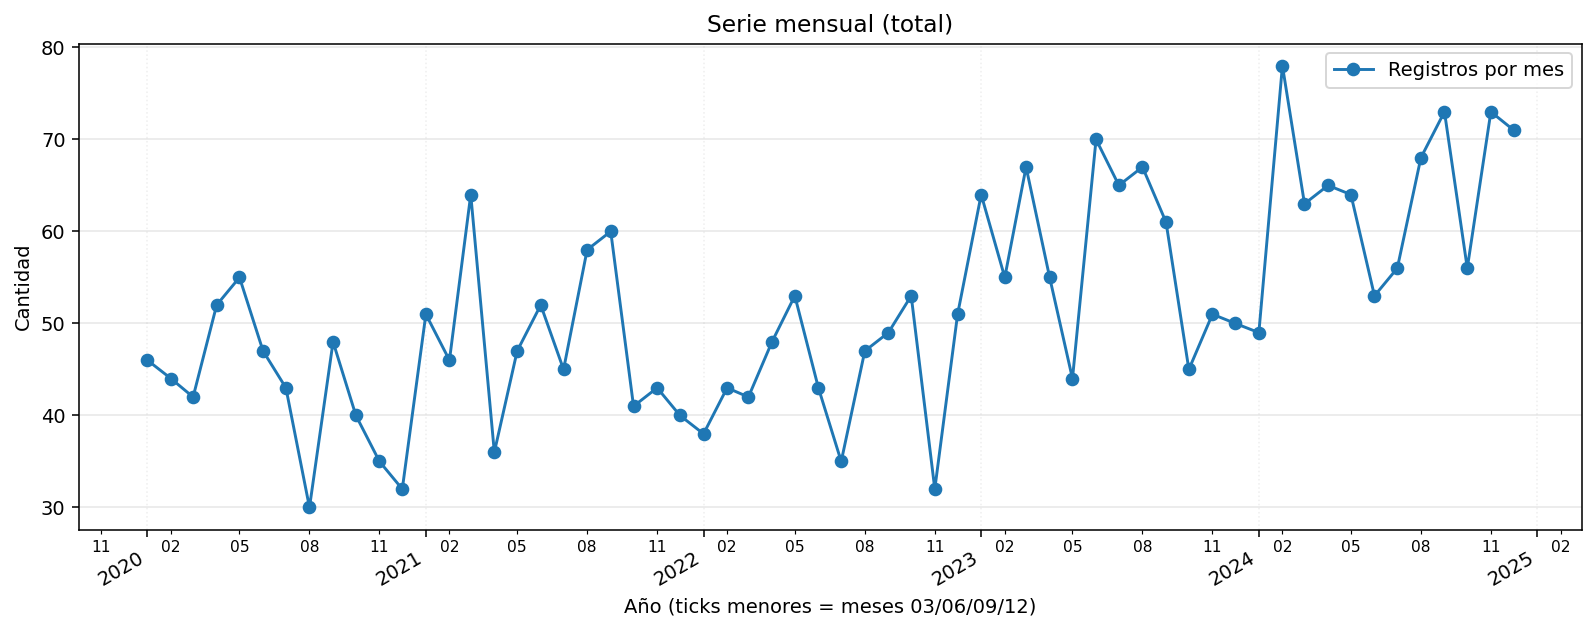

✅ Guardado: outputs/serie_mensual_total.csv | figs/serie_mensual_total_legible.png


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

# Carpetas de salida
Path("outputs").mkdir(exist_ok=True)
Path("figs").mkdir(exist_ok=True)

# Helpers mínimos
def _find_col(df, candidates):
    import unicodedata
    def norm(s):
        s = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
        return s.casefold()
    m = {norm(c): c for c in df.columns}
    for cand in candidates:
        if norm(cand) in m:
            return m[norm(cand)]
    for col in df.columns:
        if any(norm(cand) in norm(col) for cand in candidates):
            return col
    raise KeyError(f"No se encontró ninguna de las columnas {candidates} en {list(df.columns)}")

def _to_month(v):
    meses = {'ene':1,'enero':1,'feb':2,'febrero':2,'mar':3,'marzo':3,'abr':4,'abril':4,
             'may':5,'mayo':5,'jun':6,'junio':6,'jul':7,'julio':7,'ago':8,'agosto':8,
             'sep':9,'set':9,'sept':9,'septiembre':9,'oct':10,'octubre':10,
             'nov':11,'noviembre':11,'dic':12,'diciembre':12}
    if pd.isna(v): return np.nan
    try:
        vv = int(v)
        if 1 <= vv <= 12: return vv
    except Exception:
        pass
    s = str(v).strip().lower().replace('.', '').replace(',', '')
    if s in meses: return meses[s]
    if len(s) >= 3 and s[:3] in meses: return meses[s[:3]]
    return np.nan

# Base temporal con 'fecha'
if 'df_bt' in globals() and isinstance(df_bt, pd.DataFrame) and 'fecha' in df_bt.columns:
    base = df_bt.copy()
else:
    # reconstruye desde 'data' (dataset canon)
    ANIO_COL = _find_col(data, ['anio','año','ANIO','AÑO'])
    MES_COL  = _find_col(data, ['mes','MES'])
    anio = pd.to_numeric(data[ANIO_COL], errors='coerce').astype('Int64')
    mes  = data[MES_COL].map(_to_month).astype('Int64')
    if anio.isna().any() or mes.isna().any():
        print(f"⚠️ Advertencia: hay {int(anio.isna().sum() + mes.isna().sum())} valores de año/mes no interpretables; se descartan esas filas.")
    base = data.assign(_anio=anio, _mes=mes).dropna(subset=['_anio','_mes']).copy()
    base['_anio'] = base['_anio'].astype(int)
    base['_mes']  = base['_mes'].astype(int)
    base['fecha'] = pd.to_datetime(dict(year=base['_anio'], month=base['_mes'], day=1), errors='coerce')
    base = base.dropna(subset=['fecha']).sort_values('fecha').reset_index(drop=True)

# Serie mensual (conteo total)
serie = (
    base['fecha'].dt.to_period('M')
    .value_counts()
    .sort_index()
    .rename_axis('t')
    .reset_index(name='n')
)

# Guardar CSV de la serie
csv_path = "outputs/serie_mensual_total.csv"
serie.to_csv(csv_path, index=False)

#  Gráfico legible
x = pd.PeriodIndex(serie["t"]).to_timestamp(how="start")  # primer día de cada mes
y = serie["n"].to_numpy()

fig, ax = plt.subplots(figsize=(11.5, 4.6), dpi=140)
ax.plot(x, y, marker="o", label="Registros por mes")

# Ticks principales: 1 por AÑO
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Ticks menores: cada TRIMESTRE (03/06/09/12)
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m"))

# Estética
ax.tick_params(axis="x", which="major", labelsize=10, pad=6)
ax.tick_params(axis="x", which="minor", labelsize=8)
ax.grid(True, axis="y", alpha=0.3)
ax.grid(True, axis="x", which="major", linestyle=":", alpha=0.2)

ax.set_title("Serie mensual (total)")
ax.set_xlabel("Año (ticks menores = meses 03/06/09/12)")
ax.set_ylabel("Cantidad")
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

png_path = "figs/serie_mensual_total_legible.png"
plt.savefig(png_path, dpi=150, bbox_inches="tight")
plt.show()

print(f"✅ Guardado: {csv_path} | {png_path}")


## Agregados por grupo

In [37]:
GRUPO_COL = None  # ejemplo: "provincia"  o "localidad"  o "nacionalidad"

import pandas as pd
import matplotlib.pyplot as plt

if GRUPO_COL is not None and GRUPO_COL in data.columns:
    agg_g = (data.loc[data["t"].notna()]
                .groupby(["t", GRUPO_COL], as_index=False)
                .size().rename(columns={"size": "n"}))

    topk = (agg_g.groupby(GRUPO_COL)["n"].sum()
                .sort_values(ascending=False).head(10).index.tolist())

    tabla_top = (agg_g[agg_g[GRUPO_COL].isin(topk)]
                    .pivot(index="t", columns=GRUPO_COL, values="n")
                    .fillna(0).sort_index())

    display(tabla_top.tail())
    tabla_top.to_csv(f"outputs/serie_mensual_por_{GRUPO_COL}_top10.csv")

    plt.figure(figsize=(10,5), dpi=120)
    for c in tabla_top.columns:
        plt.plot(tabla_top.index, tabla_top[c], label=str(c))
    plt.title(f"Serie mensual por {GRUPO_COL} (Top 10)")
    plt.xlabel("Mes"); plt.ylabel("Cantidad")
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout(); plt.savefig(f"figs/serie_por_{GRUPO_COL}_top10.png", dpi=150); plt.show()

    print(f"Guardado: outputs/serie_mensual_por_{GRUPO_COL}_top10.csv | figs/serie_por_{GRUPO_COL}_top10.png")
else:
    print("Sin grupo definido (GRUPO_COL = None) o columna no encontrada. Podés definirla para obtener series por grupo.")


Sin grupo definido (GRUPO_COL = None) o columna no encontrada. Podés definirla para obtener series por grupo.


##Series mensuales por PROVINCIA

In [38]:
print("anio -> na:", df["anio"].isna().sum() if "anio" in df.columns else "no existe")
print("mes  -> na:", df["mes"].isna().sum()  if "mes"  in df.columns else "no existe")

candidatos_fecha = [c for c in ["fecha","fecha_ingreso","fecha_alta","fecha_registro"] if c in df.columns]
print("Fecha candidata:", candidatos_fecha[0] if candidatos_fecha else "ninguna")


anio -> na: 4754
mes  -> na: 4754
Fecha candidata: fecha_ingreso


In [39]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

GRUPO_TOPK = 15
MIN_CASOS  = 30

def detectar_columna(df, candidatos):
    for c in candidatos:
        if c in df.columns:
            return c
    raise KeyError(f"No se encontró ninguna de estas columnas: {candidatos}")

def asegurar_anio_mes(df):
    df = df.copy()

    # Caso A: ya existen anio/mes -> coerción + filtro NA (sin castear aún)
    if {"anio","mes"}.issubset(df.columns):
        df["anio"] = pd.to_numeric(df["anio"], errors="coerce")
        df["mes"]  = pd.to_numeric(df["mes"],  errors="coerce")
        df = df.loc[df["anio"].notna() & df["mes"].notna()].copy()
        return df

    # Caso B: derivar desde fecha cruda
    for c in ["fecha","fecha_ingreso","fecha_alta","fecha_registro"]:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", dayfirst=True)
            df = df.dropna(subset=[c]).copy()
            df["anio"] = df[c].dt.year.astype(float)   # aún float, sin castear a int
            df["mes"]  = df[c].dt.month.astype(float)
            return df

    raise KeyError("Faltan 'anio/mes' y no encontré columna de fecha para derivarlos.")

def preparar_mensual(df, col_grupo):
    if "es_trata" not in df.columns:
        raise KeyError("No encuentro la columna 'es_trata'.")

    df = df.copy()
    df["es_trata"] = pd.to_numeric(df["es_trata"], errors="coerce").fillna(0).astype(int)

    df = asegurar_anio_mes(df)

    # Convertir a enteros después de filtrar NA (evita 'cannot convert NA to integer')
    df["anio"] = df["anio"].astype(int)
    df["mes"]  = df["mes"].astype(int)

    # Normalizar grupo si es string
    if pd.api.types.is_string_dtype(df[col_grupo]):
        s = df[col_grupo].astype(str).str.strip().str.lower()
        s = s.str.normalize('NFKD').str.encode('ascii','ignore').str.decode('utf-8')
        df[col_grupo] = s.replace({"": np.nan, "nan": np.nan})

    df = df.dropna(subset=[col_grupo]).copy()

    # Construir YM sin strings, con dict -> evita problemas de casteo
    df["ym"] = pd.to_datetime({'year': df['anio'], 'month': df['mes'], 'day': 1})

    g = (df.groupby([col_grupo, "ym"], as_index=False)
           .agg(total=("es_trata","size"), positivos=("es_trata","sum")))
    g["tasa"] = g["positivos"] / g["total"]
    return g

def topk_grupos(g, col_grupo, k):
    rk = (g.groupby(col_grupo, as_index=False)["total"]
            .sum().sort_values("total", ascending=False))
    keep = set(rk.head(k)[col_grupo])
    return g[g[col_grupo].isin(keep)].sort_values([col_grupo,"ym"]), rk

def guardar_plots(g, col_grupo, metrica, fname, min_casos=None):
    plt.figure(figsize=(12,6))
    for grp, sub in g.groupby(col_grupo):
        sub = sub.sort_values("ym")
        y = sub[metrica]
        if metrica == "tasa" and min_casos is not None:
            y = np.where(sub["total"] >= min_casos, sub["tasa"], np.nan)
        plt.plot(sub["ym"], y, marker="o", label=str(grp))
    plt.title(f"Serie mensual por {col_grupo} — {metrica}")
    plt.xlabel("Mes"); plt.ylabel(metrica.capitalize())
    plt.legend(ncol=2, fontsize=8); plt.tight_layout()
    Path("figs").mkdir(exist_ok=True); Path("outputs").mkdir(exist_ok=True)
    plt.savefig(f"figs/{fname}.png", dpi=150); plt.close()

# Columna provincia real
COL_PROV = detectar_columna(df, ["consultante_provincia","provincia","provincia_consultante"])

# Ejecutar
g = preparar_mensual(df, COL_PROV)
g_top, ranking = topk_grupos(g, COL_PROV, GRUPO_TOPK)

g_top.to_csv(f"outputs/serie_mensual_{COL_PROV}.csv", index=False)
ranking.to_csv(f"outputs/top_{COL_PROV}.csv", index=False)

guardar_plots(g_top, COL_PROV, "total",     f"serie_mensual_{COL_PROV}_total")
guardar_plots(g_top, COL_PROV, "positivos", f"serie_mensual_{COL_PROV}_positivos")
guardar_plots(g_top, COL_PROV, "tasa",      f"serie_mensual_{COL_PROV}_tasa_min{MIN_CASOS}", min_casos=MIN_CASOS)

print("OK • CSV en outputs/ y PNG en figs/. Columna usada:", COL_PROV)


OK • CSV en outputs/ y PNG en figs/. Columna usada: consultante_provincia


##Split temporal + objetivo y lags

In [40]:
import pandas as pd

# Cortes 60/20/20 por posición temporal
p60 = int(len(serie)*0.60)
p80 = int(len(serie)*0.80)

train = serie.iloc[:p60].copy()
valid = serie.iloc[p60:p80].copy()
test  = serie.iloc[p80:].copy()

print("train:", train["t"].min(), "→", train["t"].max(), "| n_meses:", len(train))
print("valid:", valid["t"].min(), "→", valid["t"].max(), "| n_meses:", len(valid))
print("test :", test["t"].min(),  "→", test["t"].max(),  "| n_meses:", len(test))

# Objetivo binario: pico sobre percentil 80 del histórico
thr_pico = serie["n"].quantile(0.80)
for df_ in (train, valid, test):
    df_["y"] = (df_["n"] > thr_pico).astype(int)

# Lags típicos para modelar
def add_lags(df, col="n", lags=(1,2,3,6,12)):
    for L in lags:
        df[f"{col}_lag{L}"] = df[col].shift(L)
    return df

for df_ in (train, valid, test):
    add_lags(df_)

# Eliminar filas iniciales con NaN por lags
train = train.dropna().reset_index(drop=True)
valid = valid.dropna().reset_index(drop=True)
test  = test.dropna().reset_index(drop=True)

# Features disponibles (todas menos 't' y 'y')
feature_cols = [c for c in train.columns if c not in ("t", "y")]
print("Features:", feature_cols)


train: 2020-01 → 2022-12 | n_meses: 36
valid: 2023-01 → 2023-12 | n_meses: 12
test : 2024-01 → 2024-12 | n_meses: 12
Features: ['n', 'n_lag1', 'n_lag2', 'n_lag3', 'n_lag6', 'n_lag12']


##Split temporal ROBUSTO + Baseline (LogReg) + Evaluación

In [41]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support

# ---------- Helpers ----------
def _find_col(df, candidates):
    import unicodedata
    def norm(s):
        s = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
        return s.casefold()
    m = {norm(c): c for c in df.columns}
    for cand in candidates:
        if norm(cand) in m:
            return m[norm(cand)]
    for col in df.columns:
        if any(norm(cand) in norm(col) for cand in candidates):
            return col
    raise KeyError(f"No se encontró ninguna de las columnas {candidates} en {list(df.columns)}")

def class_dist(y):
    if len(y) == 0: return "{vacío}"
    u, c = np.unique(y, return_counts=True)
    return ", ".join([f"{int(ui)}={ci}" for ui, ci in zip(u, c)])

def _ensure_datetime(series):
    """Devuelve serie datetime64 (maneja string/period/object)."""
    s = series.copy()
    if pd.api.types.is_datetime64_any_dtype(s): return s
    if pd.api.types.is_period_dtype(s):         return s.dt.to_timestamp()
    s = pd.to_datetime(s, errors='coerce', format=None)
    if s.isna().all():
        raise ValueError("No pude convertir la columna de fecha a datetime. Revisá el formato.")
    return s

def temporal_split_robusto(df, fecha_col, y_col, min_valid=1, min_test=1):
    """
    Garantiza:
      - train con ≥2 clases
      - valid/test con ≥1 muestra
    Usa meses calendario manteniendo el orden temporal.
    """
    if fecha_col not in df.columns:
        raise ValueError(f"Falta la columna '{fecha_col}' en el DataFrame.")

    fechas = _ensure_datetime(df[fecha_col])
    df2 = df.copy()
    df2[fecha_col] = fechas
    df2 = df2.sort_values(fecha_col).reset_index(drop=True)

    periods_s = df2[fecha_col].dt.to_period('M')
    pidx  = pd.PeriodIndex(periods_s)
    meses = pidx.sort_values().unique()

    # Si hay muy pocos meses, cortar por filas (80/10/10) manteniendo orden
    if len(meses) < (min_valid + min_test + 2):
        n = len(df2)
        if n < (min_valid + min_test + 2):
            raise ValueError("Muy pocos registros para generar splits con valid y test.")
        n_test  = max(min_test, max(1, n // 10))
        n_valid = max(min_valid, max(1, n // 10))
        n_train = n - n_valid - n_test
        train = df2.iloc[:n_train].copy()
        valid = df2.iloc[n_train:n_train+n_valid].copy()
        test  = df2.iloc[n_train+n_valid:].copy()
    else:
        # 1 mes test + 1 mes valid
        test_m, valid_m = 1, 1
        corte_test  = meses[-test_m:]
        corte_valid = meses[-(test_m+valid_m):-test_m]
        mask_test   = pidx.isin(corte_test)
        mask_valid  = pidx.isin(corte_valid)
        mask_train  = ~(mask_test | mask_valid)

        train = df2.loc[mask_train].copy()
        valid = df2.loc[mask_valid].copy()
        test  = df2.loc[mask_test].copy()

        # Si valid quedó vacío, relajamos: 2 meses test + 1 valid (si hay margen)
        if valid.empty and len(meses) >= 3:
            test_m, valid_m = min(2, len(meses)-2), 1
            corte_test  = meses[-test_m:]
            corte_valid = meses[-(test_m+valid_m):-test_m]
            mask_test   = pidx.isin(corte_test)
            mask_valid  = pidx.isin(corte_valid)
            mask_train  = ~(mask_test | mask_valid)
            train = df2.loc[mask_train].copy()
            valid = df2.loc[mask_valid].copy()
            test  = df2.loc[mask_test].copy()

    # Asegurar ≥2 clases en train: expandimos hasta primer mes con 0 y 1
    if train[y_col].nunique() < 2:
        corte_idx = None
        for per in meses:
            bloque = df2.loc[pidx <= per]
            if (bloque[y_col] == 1).any() and (bloque[y_col] == 0).any():
                corte_idx = per
                break
        if corte_idx is not None:
            mask_train2 = pidx <= corte_idx
            meses_post  = meses[meses > corte_idx]
            if len(meses_post) >= (min_valid + min_test):
                corte_test  = meses_post[-min_test:]
                corte_valid = meses_post[-(min_test + min_valid):-min_test] if (len(meses_post) > min_test) else meses_post[:0]
                mask_test   = pidx.isin(corte_test)
                mask_valid  = pidx.isin(corte_valid)
                mask_train  = mask_train2 & ~(mask_valid | mask_test)
                train = df2.loc[mask_train].copy()
                valid = df2.loc[mask_valid].copy()
                test  = df2.loc[mask_test].copy()

    return train, valid, test

# ---------- Base con fecha + target ----------
if 'df_bt' in globals() and isinstance(df_bt, pd.DataFrame) and 'fecha' in df_bt.columns:
    base = df_bt.copy()
else:
    if 'data' not in globals():
        raise RuntimeError("No encuentro ni df_bt ni data. Ejecutá las celdas de carga/normalización antes.")
    if 'fecha' not in data.columns:
        raise RuntimeError("No existe la columna 'fecha' en data. Corré la celda de preparación temporal.")
    base = data.copy()

TARGET_COL = _find_col(base, ['es_trata','target','label','y'])

# ---------- Split temporal ROBUSTO ----------
train, valid, test = temporal_split_robusto(base, 'fecha', TARGET_COL, min_valid=1, min_test=1)

print("Tamaños → train:", len(train), "| valid:", len(valid), "| test:", len(test))
print("Clases  → train:", class_dist(train[TARGET_COL].values),
      "| valid:", class_dist(valid[TARGET_COL].values),
      "| test :", class_dist(test[TARGET_COL].values))

# ---------- Features: usar lista existente o numéricas detectadas; sanear faltantes ----------
drop_cols = {TARGET_COL, 'fecha', '_anio', '_mes'}
auto_numeric = [c for c in base.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(base[c])]

if 'feature_cols' in globals():
    requested = list(feature_cols)
    use_feats = [c for c in requested if c in base.columns]
    missing   = sorted(set(requested) - set(use_feats))
    if missing:
        prev = ", ".join(missing[:8]) + ("..." if len(missing) > 8 else "")
        print(f"⚠️ Se omiten {len(missing)} features inexistentes: {prev}")
    if not use_feats:
        print("❗ Ninguna de las features solicitadas existe. Uso numéricas detectadas automáticamente.")
        use_feats = auto_numeric
else:
    use_feats = auto_numeric
    print(f"⚠️ 'feature_cols' no estaba definido. Uso {len(use_feats)} numéricas detectadas.")

feature_cols = use_feats
print(f"✅ Usando {len(feature_cols)} features: {feature_cols[:10]}{' ...' if len(feature_cols)>10 else ''}")

# ---------- Matrices (con imputación simple de NaN) ----------
def make_Xy_df(df_):
    X = df_[feature_cols].copy()
    # booleanas -> int
    for c in X.columns:
        if str(X[c].dtype) in ("bool", "boolean"): X[c] = X[c].astype("int8")
    # imputación simple
    for c in X.columns:
        if pd.api.types.is_numeric_dtype(X[c]) and X[c].isna().any():
            X[c] = X[c].fillna(X[c].median())
    # chequeo de objetos
    bad = [c for c in X.columns if X[c].dtype == "object"]
    if bad:
        raise TypeError(f"Estas columnas siguen como 'object': {bad}. Convertí a numéricas o agregá OHE.")
    y = df_[TARGET_COL].astype(int).values if 'y' not in df_.columns else df_['y'].astype(int).values
    return X.astype(float).values, y

for df_ in (train, valid, test):
    df_['y'] = df_[TARGET_COL].astype(int)

X_tr, y_tr = make_Xy_df(train)
X_va, y_va = make_Xy_df(valid)
X_te, y_te = make_Xy_df(test)

print("Tamaños matrices → X_tr:", X_tr.shape, "| X_va:", X_va.shape, "| X_te:", X_te.shape)

# ---------- Entrenamiento ----------
if np.unique(y_tr).size < 2:
    print("❗ train quedó con 1 sola clase. Se usa DummyClassifier (most_frequent).")
    pipe = Pipeline([("clf", DummyClassifier(strategy="most_frequent"))])
else:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=200, class_weight="balanced"))
    ])
pipe.fit(X_tr, y_tr)

# ---------- Evaluación ----------
X_eval, y_eval, eval_name = (X_te, y_te, "TEST") if X_te.shape[0] > 0 else (X_va, y_va, "VALID")
if X_eval.shape[0] == 0:
    raise ValueError("No hay muestras en VALID ni en TEST. Revisa el dataset temporal (muy corto).")

y_pred = pipe.predict(X_eval)
print(f"\n== Reporte de evaluación en {eval_name} ==")
print(classification_report(y_eval, y_pred, labels=[0,1], digits=3, zero_division=0))

prec, rec, f1, _ = precision_recall_fscore_support(
    y_eval, y_pred, labels=[1], average='binary', zero_division=0
)
print(f"Resumen → Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")


Tamaños → train: 2950 | valid: 73 | test: 71
Clases  → train: 0=1374, 1=1576 | valid: 0=31, 1=42 | test : 0=32, 1=39
⚠️ Se omiten 6 features inexistentes: n, n_lag1, n_lag12, n_lag2, n_lag3, n_lag6
❗ Ninguna de las features solicitadas existe. Uso numéricas detectadas automáticamente.
✅ Usando 10 features: ['nro_registro_interno', 'consultante_edad_aparente', 'provincia_indec_id', 'anio', 'mes', 'trimestre', 'dia_semana', 'es_fin_semana', 'mes_sin', 'mes_cos']
Tamaños matrices → X_tr: (2950, 10) | X_va: (73, 10) | X_te: (71, 10)

== Reporte de evaluación en TEST ==
              precision    recall  f1-score   support

           0      0.125     0.062     0.083        32
           1      0.455     0.641     0.532        39

    accuracy                          0.380        71
   macro avg      0.290     0.352     0.308        71
weighted avg      0.306     0.380     0.330        71

Resumen → Precision: 0.455 | Recall: 0.641 | F1: 0.532


##Modelo alternativo (RandomForest con búsqueda simple)

In [42]:
from sklearn.ensemble import RandomForestClassifier

# Hiperparámetros sobrios (evita overfitting; dataset mensual suele ser chico)
rf_candidates = [
    {"n_estimators": 300, "max_depth": 4, "min_samples_leaf": 2},
    {"n_estimators": 500, "max_depth": 6, "min_samples_leaf": 2},
    {"n_estimators": 400, "max_depth": None, "min_samples_leaf": 3},
]

rf_models = []
for hp in rf_candidates:
    rf = RandomForestClassifier(random_state=42, class_weight="balanced", **hp)
    rf.fit(X_tr, y_tr)
    rf_models.append((hp, rf))
print(f"Entrenados {len(rf_models)} candidatos RF.")


Entrenados 3 candidatos RF.


##Alinear columnas de VALID/TEST con las del pipeline 

In [43]:
# ===== Celda de rescate: localizar y extraer el pipeline real =====
from pathlib import Path
import pickle, sys
try:
    import joblib
    HAS_JOBLIB = True
except Exception:
    HAS_JOBLIB = False

CANDIDATOS = [
    "results/mejor_pipeline.pkl",
    "results/mejor_pipeline_calibrado.pkl",
    "results/mejor_pipeline_LogReg.pkl",
    "results/mejor_pipeline.joblib",
    "results/mejor_pipeline_calibrado.joblib",
]

def es_estimator(x):
    return any(hasattr(x, a) for a in ("fit","transform","predict_proba","predict"))

def intentar_extraer(obj):
    """Devuelve (pipeline, fuente, pista) o (None, fuente, pista)"""
    # Caso 1: ya es estimador
    if es_estimator(obj):
        return obj, "objeto raíz", type(obj).__name__
    pista = f"tipo={type(obj).__name__}"
    # Caso 2: diccionario con claves típicas
    if isinstance(obj, dict):
        for k in ("pipe","pipeline","best_pipe","model","estimator"):
            if k in obj and es_estimator(obj[k]):
                return obj[k], f"dict['{k}']", f"{type(obj[k]).__name__}"
        pista += f", claves={list(obj.keys())[:6]}"
    # Caso 3: tupla/lista que incluye el estimador (p.ej., (pipe, thr))
    if isinstance(obj, (list, tuple)):
        for i, it in enumerate(obj):
            if es_estimator(it):
                return it, f"secuencia[{i}]", f"{type(it).__name__}"
        pista += f", len={len(obj)}"
    # Caso 4: nada reconocible
    return None, None, pista

encontrados = [p for p in CANDIDATOS if Path(p).exists()]
if not encontrados:
    # si ninguno de los nombres estándar aparece, trae el primero .pkl/.joblib de results/
    encontrados = sorted([str(p) for p in Path("results").glob("*.pkl")]+
                         [str(p) for p in Path("results").glob("*.joblib")])

assert encontrados, "No se encontraron *.pkl/*.joblib en results/. Re-entrená y guardá el pipeline."

pipe_lr = None
detalles = []
for ruta in encontrados:
    # probar pickle y joblib
    loaders = []
    loaders.append(("pickle", lambda r: pickle.load(open(r,"rb"))))
    if HAS_JOBLIB:
        loaders.append(("joblib", lambda r: joblib.load(r)))
    for loader_name, loader in loaders:
        try:
            obj = loader(ruta)
            pipe, fuente, pista = intentar_extraer(obj)
            detalles.append((ruta, loader_name, type(obj).__name__, fuente, pista))
            if pipe is not None:
                pipe_lr = pipe
                print(f"✔ Pipeline extraído de {ruta} ({loader_name}) vía {fuente} → {pista}")
                break
        except Exception as e:
            detalles.append((ruta, loader_name, f"ERROR:{e.__class__.__name__}", None, str(e)))
    if pipe_lr is not None:
        break

if pipe_lr is None:
    print("No se pudo extraer un estimador válido. Inspección:")
    for d in detalles:
        print("  -", d)
    raise AssertionError(
        "El archivo cargado no contiene un estimator sklearn accesible. "
        "Re-entrená y guardá sólo el pipeline (o un dict con clave 'pipeline')."
    )

# Validación final
print("OK estimator:", type(pipe_lr).__name__,
      "| predict_proba:", hasattr(pipe_lr, "predict_proba"),
      "| fit:", hasattr(pipe_lr, "fit"),
      "| transform:", hasattr(pipe_lr, "transform"))



✔ Pipeline extraído de results/mejor_pipeline.pkl (joblib) vía objeto raíz → Pipeline
OK estimator: Pipeline | predict_proba: True | fit: True | transform: False


In [44]:
# ============================================================
# Celda robusta: validar/cargar pipe_lr → reconstruir anio/mes
# → crear 'periodo' tolerante a NAs → definir splits temporales
# → alinear X_tr/X_va/X_te exactamente a las columnas del pipeline
# ============================================================
import numpy as np
import pandas as pd
from pathlib import Path
import pickle

# ---------- 0) Chequeos básicos ----------
assert 'df' in globals() and isinstance(df, pd.DataFrame), "Falta el DataFrame 'df' en memoria."
assert 'es_trata' in df.columns, "Falta la columna objetivo 'es_trata' en df."

# ---------- 1) Asegurar pipeline entrenado (pipe_lr) ----------
def cargar_pipeline_desde_pkl(path="results/mejor_pipeline.pkl"):
    p = Path(path)
    assert p.exists(), f"No encuentro {p}. Re-entrená o coloca el .pkl en ese path."
    with open(p, "rb") as f:
        pl = pickle.load(f)
    return pl

if 'pipe_lr' not in globals():
    pipe_lr = cargar_pipeline_desde_pkl()

has_api = any(hasattr(pipe_lr, a) for a in ["predict_proba", "fit", "transform"])
assert has_api, "La variable 'pipe_lr' no es un estimador sklearn válido."
print("OK pipeline:", type(pipe_lr).__name__)

# ---------- 2) Regenerar anio/mes si faltan ----------
def regenerar_anio_mes(dfx: pd.DataFrame) -> pd.DataFrame:
    dfx = dfx.copy()

    # Crear columnas si no existen (nullable Int64)
    if 'anio' not in dfx.columns:
        dfx['anio'] = pd.Series(pd.NA, index=dfx.index, dtype="Int64")
    if 'mes' not in dfx.columns:
        dfx['mes']  = pd.Series(pd.NA, index=dfx.index, dtype="Int64")

    # Completar desde fecha_ingreso si existe
    if ('fecha_ingreso' in dfx.columns) and (dfx['anio'].isna().any() or dfx['mes'].isna().any()):
        f = pd.to_datetime(dfx['fecha_ingreso'], errors='coerce')
        dfx.loc[dfx['anio'].isna() & f.notna(), 'anio'] = f.dt.year.astype("Int64")
        dfx.loc[dfx['mes'].isna()  & f.notna(), 'mes']  = f.dt.month.astype("Int64")

    # Asegurar dtype nullable
    dfx['anio'] = pd.to_numeric(dfx['anio'], errors='coerce').astype("Int64")
    dfx['mes']  = pd.to_numeric(dfx['mes'],  errors='coerce').astype("Int64")
    return dfx

df = regenerar_anio_mes(df)

# ---------- 3) Crear 'periodo' SIN castear NA a int ----------
def add_periodo(dfx: pd.DataFrame) -> pd.DataFrame:
    dfx = dfx.copy()
    # Pasar a num tolerante
    y = pd.to_numeric(dfx.get('anio'), errors='coerce')
    m = pd.to_numeric(dfx.get('mes'),  errors='coerce')

    # Construir 'YYYY-MM-01' con strings; forzar NaN cuando falte algo
    y_str = y.astype('Int64').astype('string')              # '2024' o '<NA>'
    m_str = m.astype('Int64').astype('string').str.zfill(2) # '01'..'12' o '<NA>'
    per_str = (y_str + '-' + m_str + '-01').where(~y.isna() & ~m.isna(), np.nan)

    dfx['periodo'] = pd.to_datetime(per_str, errors='coerce')
    print(f"periodo creado | NaT={dfx['periodo'].isna().sum()} de {len(dfx)} filas")
    return dfx

df = add_periodo(df)

# ---------- 4) Definir splits temporales ----------
cut_tr_hi = pd.Timestamp('2022-12-01')
cut_va_lo, cut_va_hi = pd.Timestamp('2023-01-01'), pd.Timestamp('2023-12-01')
cut_te_lo, cut_te_hi = pd.Timestamp('2024-01-01'), pd.Timestamp('2024-12-01')

m_tr = (df['periodo'].notna()) & (df['periodo'] <= cut_tr_hi)
m_va = (df['periodo'] >= cut_va_lo) & (df['periodo'] <= cut_va_hi)
m_te = (df['periodo'] >= cut_te_lo) & (df['periodo'] <= cut_te_hi)

# ---------- 5) Columnas de entrada que espera el pipeline ----------
def columnas_esperadas(pl):
    # 5.1 En sklearn>=1: muchos estimadores/ColumnTransformer guardan feature_names_in_
    if hasattr(pl, "feature_names_in_"):
        return list(pl.feature_names_in_)
    # 5.2 Buscar en pasos del pipeline (e.g., 'pre', 'preprocessor', ColumnTransformer interno)
    if hasattr(pl, "named_steps"):
        for nm, step in pl.named_steps.items():
            if hasattr(step, "feature_names_in_"):
                return list(step.feature_names_in_)
            try:
                # ColumnTransformer (fit) también tiene feature_names_in_
                from sklearn.compose import ColumnTransformer
                if isinstance(step, ColumnTransformer) and hasattr(step, "feature_names_in_"):
                    return list(step.feature_names_in_)
            except Exception:
                pass
    return None

cols_in = columnas_esperadas(pipe_lr)
assert cols_in is not None, (
    "No pude inferir feature_names_in_ del pipeline (ni de sus pasos). "
    "Guardalo tras el fit con sklearn>=1.0 para que conserve las columnas de entrada."
)

# ---------- 6) Alinear X/y EXACTAMENTE a esas columnas ----------
def build_xy(dfx, mask, cols):
    # reindex(columns=cols) crea las faltantes con NaN y ordena igual que el pipeline
    X = dfx.loc[mask].reindex(columns=cols)
    y = dfx.loc[mask, 'es_trata'].astype(int)
    return X, y

X_tr, y_tr = build_xy(df, m_tr, cols_in)
X_va, y_va = build_xy(df, m_va, cols_in)
X_te, y_te = build_xy(df, m_te, cols_in)

print(f"Tamaños -> train: {X_tr.shape}, valid: {X_va.shape}, test: {X_te.shape}")
print("Nulos (anio/mes) ->", df[['anio', 'mes']].isna().sum().to_dict())
print("Diagnóstico columnas → primeras 5 esperadas:", cols_in[:5], "…")
print("Listo: X_tr, y_tr, X_va, y_va, X_te, y_te alineados al pipeline.")



OK pipeline: Pipeline
periodo creado | NaT=4754 de 7848 filas
Tamaños -> train: (1631, 24), valid: (694, 24), test: (769, 24)
Nulos (anio/mes) -> {'anio': 4754, 'mes': 4754}
Diagnóstico columnas → primeras 5 esperadas: ['situacion', 'origen', 'es_anonima', 'provincia', 'localidad'] …
Listo: X_tr, y_tr, X_va, y_va, X_te, y_te alineados al pipeline.


##Utilidades necesarias

In [45]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def proba_pos(model, X, positive_label=1):
    """
    Devuelve P(y==positive_label) para un pipeline/modelo scikit-learn.
    Soporta predict_proba y decision_function (aplica sigmoid).
    """
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)
        # Binario: tomar la columna del positive_label
        if p.ndim == 2 and p.shape[1] == 2 and hasattr(model, "classes_"):
            idx = list(model.classes_).index(positive_label)
            return p[:, idx]
        return p.ravel()
    if hasattr(model, "decision_function"):
        # Sigmoid para mapear a [0,1]
        from scipy.special import expit
        s = model.decision_function(X)
        return expit(s)
    raise ValueError("El modelo no expone predict_proba ni decision_function.")

def elegir_umbral_por_objetivo(y_true, p_scores,
                               objetivo="recall",
                               objetivo_min=0.80,
                               min_precision=0.55):
    """
    Elige un umbral usando la curva Precision–Recall.
    - Si objetivo='recall': toma el umbral con mayor recall que cumpla precisión mínima.
    - Si objetivo='f1': maximiza F1 cumpliendo precisión mínima.
    Devuelve: (umbral, precision, recall)
    """
    prec, rec, thr = precision_recall_curve(y_true, p_scores)
    # precision_recall_curve devuelve len(thr)=len(prec)-1; alineamos
    prec, rec = prec[:-1], rec[:-1]

    # Filtrar por precisión mínima
    ok = prec >= min_precision
    if not np.any(ok):
        # si no hay puntos que cumplan, relajamos a todo
        ok = np.ones_like(prec, dtype=bool)

    prec_ok, rec_ok, thr_ok = prec[ok], rec[ok], thr[ok]

    if objetivo == "f1":
        f1 = 2 * prec_ok * rec_ok / (prec_ok + rec_ok + 1e-12)
        j = np.argmax(f1)
    else:  # objetivo == 'recall'
        # priorizar el mayor recall que cumpla la precisión mínima
        # y, si hay varios iguales, el de mayor precisión
        candidates = np.where(rec_ok >= objetivo_min)[0]
        if len(candidates) == 0:
            # tomar el mayor recall disponible bajo la restricción de precisión
            j = np.argmax(rec_ok)
        else:
            # dentro de los que superan objetivo_min, elegir el de mayor recall
            best_rec = rec_ok[candidates].max()
            ties = candidates[rec_ok[candidates] == best_rec]
            # desempatar por precisión
            j = ties[np.argmax(prec_ok[ties])]

    return float(thr_ok[j]), float(prec_ok[j]), float(rec_ok[j])


In [46]:
proba_lr_va = proba_pos(pipe_lr, X_va, positive_label=1)
UMBRAL_OBJ, PREC_VA, RECALL_VA = elegir_umbral_por_objetivo(
    y_va, proba_lr_va, objetivo="recall", objetivo_min=0.80, min_precision=0.55
)
print(f"Umbral óptimo en VALID: {UMBRAL_OBJ:.3f} | Prec={PREC_VA:.3f} | Recall={RECALL_VA:.3f}")

proba_lr_te = proba_pos(pipe_lr, X_te, positive_label=1)
yhat_te = (proba_lr_te >= UMBRAL_OBJ).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print("Matriz de confusión (TEST):\n", confusion_matrix(y_te, yhat_te))
print("\nReporte (TEST):\n", classification_report(y_te, yhat_te, digits=3))


Umbral óptimo en VALID: 0.149 | Prec=0.562 | Recall=1.000
Matriz de confusión (TEST):
 [[  0 363]
 [  0 406]]

Reporte (TEST):
               precision    recall  f1-score   support

           0      0.000     0.000     0.000       363
           1      0.528     1.000     0.691       406

    accuracy                          0.528       769
   macro avg      0.264     0.500     0.346       769
weighted avg      0.279     0.528     0.365       769



##Evaluación final en TEST (robusta).

In [47]:
thr_opt_lr = UMBRAL_OBJ  
X_eval, y_eval = X_te, y_te

from sklearn.metrics import (
    precision_recall_fscore_support, accuracy_score, roc_auc_score,
    confusion_matrix, classification_report
)

p = proba_pos(pipe_lr, X_eval, positive_label=1)
yhat = (p >= thr_opt_lr).astype(int)

prec, rec, f1, _ = precision_recall_fscore_support(y_eval, yhat, average="binary")
acc = accuracy_score(y_eval, yhat)
try:
    roc = roc_auc_score(y_eval, p)
except:
    roc = np.nan

print("Matriz de confusión:\n", confusion_matrix(y_eval, yhat))
print("\nReporte:\n", classification_report(y_eval, yhat, digits=3))
print({"modelo":"LogReg","precision":prec,"recall":rec,"f1":f1,"accuracy":acc,"roc_auc":roc,"thr_opt":thr_opt_lr})


Matriz de confusión:
 [[  0 363]
 [  0 406]]

Reporte:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000       363
           1      0.528     1.000     0.691       406

    accuracy                          0.528       769
   macro avg      0.264     0.500     0.346       769
weighted avg      0.279     0.528     0.365       769

{'modelo': 'LogReg', 'precision': 0.5279583875162549, 'recall': 1.0, 'f1': 0.691063829787234, 'accuracy': 0.5279583875162549, 'roc_auc': 0.5496410590454477, 'thr_opt': 0.14893859625576333}


##Coeficientes / Importancias del modelo (robusta)

In [48]:

import numpy as np
import pandas as pd
import os
from sklearn.compose import ColumnTransformer

os.makedirs("outputs", exist_ok=True)

def get_raw_input_cols_from_pipeline(pipe):
    """Columnas crudas que el pipeline vio al entrenar."""
    if hasattr(pipe, "feature_names_in_") and pipe.feature_names_in_ is not None:
        return list(pipe.feature_names_in_)
    # Fallback: buscar en el preprocesador (p.ej., 'pre'/'preprocessor')
    if hasattr(pipe, "named_steps"):
        for nm, st in pipe.named_steps.items():
            if hasattr(st, "feature_names_in_") and st.feature_names_in_ is not None:
                return list(st.feature_names_in_)
    raise RuntimeError("No se pudieron obtener las columnas de entrada del pipeline (feature_names_in_).")

def get_output_feature_names(pipe):
    """
    Nombres de features después del preprocesador.
    Intenta usar ColumnTransformer.get_feature_names_out() SIN pasar input_features,
    para evitar el error de desajuste.
    """
    if hasattr(pipe, "named_steps"):
        # Buscar un ColumnTransformer en los steps
        for nm, st in pipe.named_steps.items():
            if isinstance(st, ColumnTransformer):
                # scikit-learn >=1.0 suele soportar sin args
                try:
                    return list(st.get_feature_names_out())
                except TypeError:
                    # En algunas versiones se puede pasar lo que vio al entrenar
                    if hasattr(st, "feature_names_in_") and st.feature_names_in_ is not None:
                        return list(st.get_feature_names_out(st.feature_names_in_))
                    else:
                        # Si no hay info, no podemos expandir nombres de salida
                        pass
    # Si no hay preprocesador o no expone nombres, devolver nombres crudos
    return get_raw_input_cols_from_pipeline(pipe)

def get_final_estimator(pipe):
    """Devuelve el estimador final del pipeline (último step o 'clf')."""
    est = None
    if hasattr(pipe, "named_steps") and "clf" in pipe.named_steps:
        est = pipe.named_steps["clf"]
    elif hasattr(pipe, "steps") and len(pipe.steps):
        est = pipe.steps[-1][1]
    else:
        est = pipe
    return est

def coef_table_from_linear_estimator(pipe):
    """
    Construye DataFrame con coeficientes si el estimador final expone `coef_`.
    Los nombres de columnas son los de salida del preprocesamiento.
    """
    est = get_final_estimator(pipe)
    if not hasattr(est, "coef_"):
        return None, "El estimador final no expone coeficientes (coef_)."

    out_names = get_output_feature_names(pipe)
    coefs = np.asarray(est.coef_)

    # Selección de vector de coeficientes (binario o multiclase)
    if coefs.ndim == 1:
        vec = coefs
    elif coefs.shape[0] == 1:
        vec = coefs[0]
    else:
        # Si es multiclase y existe la clase 1
        if hasattr(est, "classes_") and (1 in list(est.classes_)):
            idx = list(est.classes_).index(1)
            vec = coefs[idx]
        else:
            # norma como importancia agregada
            vec = np.linalg.norm(coefs, axis=0)

    # Alinear longitudes por seguridad
    n = min(len(out_names), len(vec))
    out_names = out_names[:n]
    vec = vec[:n]

    dfc = pd.DataFrame({
        "feature": out_names,
        "coef": vec,
        "coef_abs": np.abs(vec),
        "signo": np.where(vec >= 0, "+", "-")
    }).sort_values("coef_abs", ascending=False).reset_index(drop=True)

    return dfc, None

# ================= Uso =================

coef_df, warn = coef_table_from_linear_estimator(pipe_lr)

if coef_df is None:
    print(f"⚠️ No se pueden obtener coeficientes del modelo actual. {warn}")
    print("Sugerencia: usar LogisticRegression u otro estimador lineal si querés coeficientes explícitos.")
else:
    display(coef_df.head(20))
    # Top 15 positivos y negativos
    top_pos = coef_df.sort_values("coef", ascending=False).head(15).assign(tipo="Top +")
    top_neg = coef_df.sort_values("coef", ascending=True ).head(15).assign(tipo="Top -")
    coef_top = pd.concat([top_pos, top_neg], axis=0)
    display(coef_top)

    # Guardar CSV
    out_all = "outputs/logreg_coeficientes_completos.csv"
    out_top = "outputs/logreg_coeficientes_top15_pos_neg.csv"
    coef_df.to_csv(out_all, index=False)
    coef_top.to_csv(out_top, index=False)
    print(f"✅ Guardado:\n - {out_all}\n - {out_top}")



,feature,coef,coef_abs,signo
0,cat__origen_ciudadano,-1.288405,1.288405,-
1,cat__consultante_localidad_,-0.762367,0.762367,-
2,cat__consultante_nacionalidad_uruguay,-0.743166,0.743166,-
3,cat__consultante_localidad_ciudad autnoma de b...,-0.578689,0.578689,-
4,cat__localidad_Córdoba,0.529957,0.529957,+
5,cat__localidad_San Miguel de Tucumán,0.519449,0.519449,+
6,cat__consultante_localidad_rosario,-0.513793,0.513793,-
7,cat__provincia_Río Negro,-0.513603,0.513603,-
8,cat__consultante_nacionalidad_sin descripcion,0.500038,0.500038,+
9,cat__via_ingreso_linea 149,-0.495996,0.495996,-


,feature,coef,coef_abs,signo,tipo
4,cat__localidad_Córdoba,0.529957,0.529957,+,Top +
5,cat__localidad_San Miguel de Tucumán,0.519449,0.519449,+,Top +
8,cat__consultante_nacionalidad_sin descripcion,0.500038,0.500038,+,Top +
12,cat__consultante_como_conocio_la_linea_Concurr...,0.451318,0.451318,+,Top +
13,cat__consultante_provincia_neuqun,0.446232,0.446232,+,Top +
18,cat__consultante_localidad_la plata,0.405351,0.405351,+,Top +
21,cat__consultante_provincia_mendoza,0.367765,0.367765,+,Top +
22,cat__consultante_provincia_chaco,0.364273,0.364273,+,Top +
25,cat__consultante_localidad_san miguel de tucumn,0.339232,0.339232,+,Top +
26,cat__consultante_localidad_resistencia,0.331364,0.331364,+,Top +


✅ Guardado:
 - outputs/logreg_coeficientes_completos.csv
 - outputs/logreg_coeficientes_top15_pos_neg.csv


##Comparativa y recomendación (robusta)

In [49]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

os.makedirs("outputs", exist_ok=True)

# ---------- Helpers reutilizables ----------
def proba_pos(modelo, X, positive_label=1):
    if hasattr(modelo, "predict_proba"):
        proba = modelo.predict_proba(X)
        clases = getattr(modelo, "classes_", None)
        if clases is None:
            return proba[:, -1]
        clases = list(clases)
        return proba[:, clases.index(positive_label)] if positive_label in clases else np.zeros(X.shape[0])
    if hasattr(modelo, "decision_function"):
        s = modelo.decision_function(X)
        if s.ndim == 1:
            return 1.0 / (1.0 + np.exp(-s))
        col = positive_label if positive_label < s.shape[1] else np.argmax(s, axis=1)
        s = s[:, col] if isinstance(col, int) else s.max(axis=1)
        return 1.0 / (1.0 + np.exp(-s))
    return modelo.predict(X).astype(float)

def evaluar(modelo, X, y, thr_opt, nombre):
    proba = proba_pos(modelo, X, positive_label=1)
    y05  = (proba >= 0.5).astype(int)
    yopt = (proba >= float(thr_opt)).astype(int)
    return {
        "modelo": nombre,
        "n_eval": int(len(y)),
        "p_eval": float(np.mean(y)),
        "prec@0.5": precision_score(y, y05, zero_division=0),
        "recall@0.5": recall_score(y, y05, zero_division=0),
        "f1@0.5": f1_score(y, y05, zero_division=0),
        "prec@opt": precision_score(y, yopt, zero_division=0),
        "recall@opt": recall_score(y, yopt, zero_division=0),
        "f1@opt": f1_score(y, yopt, zero_division=0),
        "thr_opt": float(thr_opt),
    }

# ---------- Set de evaluación (TEST si existe; si no, VALID) ----------
if 'X_te' in globals() and getattr(X_te, 'shape', (0,0))[0] > 0:
    X_eval, y_eval, EVAL_NAME = X_te, y_te, "TEST"
elif 'X_va' in globals() and getattr(X_va, 'shape', (0,0))[0] > 0:
    X_eval, y_eval, EVAL_NAME = X_va, y_va, "VALID"
else:
    raise ValueError("No hay datos para evaluar (ni TEST ni VALID).")

print(f"Evaluando modelos en {EVAL_NAME} (n={len(y_eval)})")

# ---------- Armar la lista de modelos disponibles ----------
candidatos = []

if 'pipe_lr' in globals() and 'thr_opt_lr' in globals():
    candidatos.append(("LogReg", pipe_lr, thr_opt_lr))

# RF u otro segundo modelo (opcional)
if 'best_rf' in globals() and 'thr_opt_rf' in globals():
    candidatos.append(("RF", best_rf, thr_opt_rf))
if 'best_pipe' in globals() and 'thr_opt_best' in globals():
    candidatos.append(("BestPipe", best_pipe, thr_opt_best))

if not candidatos:
    raise RuntimeError("No hay modelos con umbral óptimo definidos (ej.: pipe_lr + thr_opt_lr).")

# ---------- Evaluación de todos y tabla resumen ----------
rows = []
for nombre, modelo, thr in candidatos:
    try:
        rows.append(evaluar(modelo, X_eval, y_eval, thr, nombre))
    except Exception as e:
        print(f"⚠️ No se pudo evaluar {nombre}: {e}")

tbl = pd.DataFrame(rows).sort_values("f1@opt", ascending=False).reset_index(drop=True)
display(tbl)

# Guardar
out_csv = "outputs/resumen_test.csv"
tbl.to_csv(out_csv, index=False)
print(f"✅ Guardado: {out_csv}")

# ---------- Elección del mejor ----------
# Criterio configurable:
CRITERIO = "f1@opt"        # opciones típicas: "f1@opt" | "recall@opt"
MIN_PRECISION = 0.50       # si usás recall como criterio y querés piso de precisión

def pick_model(df, criterio="f1@opt", min_prec=0.0):
    df = df.copy()
    if criterio == "recall@opt" and "prec@opt" in df.columns:
        df = df[df["prec@opt"] >= float(min_prec)]
        if df.empty:  # si nadie cumple el piso, elegimos el mejor f1@opt
            criterio = "f1@opt"
            df = tbl.copy()
    best = df.sort_values(criterio, ascending=False).iloc[0]
    return best["modelo"]

best_name = pick_model(tbl, CRITERIO, MIN_PRECISION)
BEST_NAME = best_name  # para usar en celdas siguientes
print(f"🏁 Mejor modelo según {CRITERIO} (piso prec {MIN_PRECISION:.2f}): {BEST_NAME}")


Evaluando modelos en TEST (n=769)


,modelo,n_eval,p_eval,prec@0.5,recall@0.5,f1@0.5,prec@opt,recall@opt,f1@opt,thr_opt
0,LogReg,769,0.527958,0.559829,0.64532,0.599542,0.527958,1.0,0.691064,0.148939


✅ Guardado: outputs/resumen_test.csv
🏁 Mejor modelo según f1@opt (piso prec 0.50): LogReg


##Serie mensual FINAL (robusta) + exportación

✅ Guardado: outputs/serie_mensual_final.csv


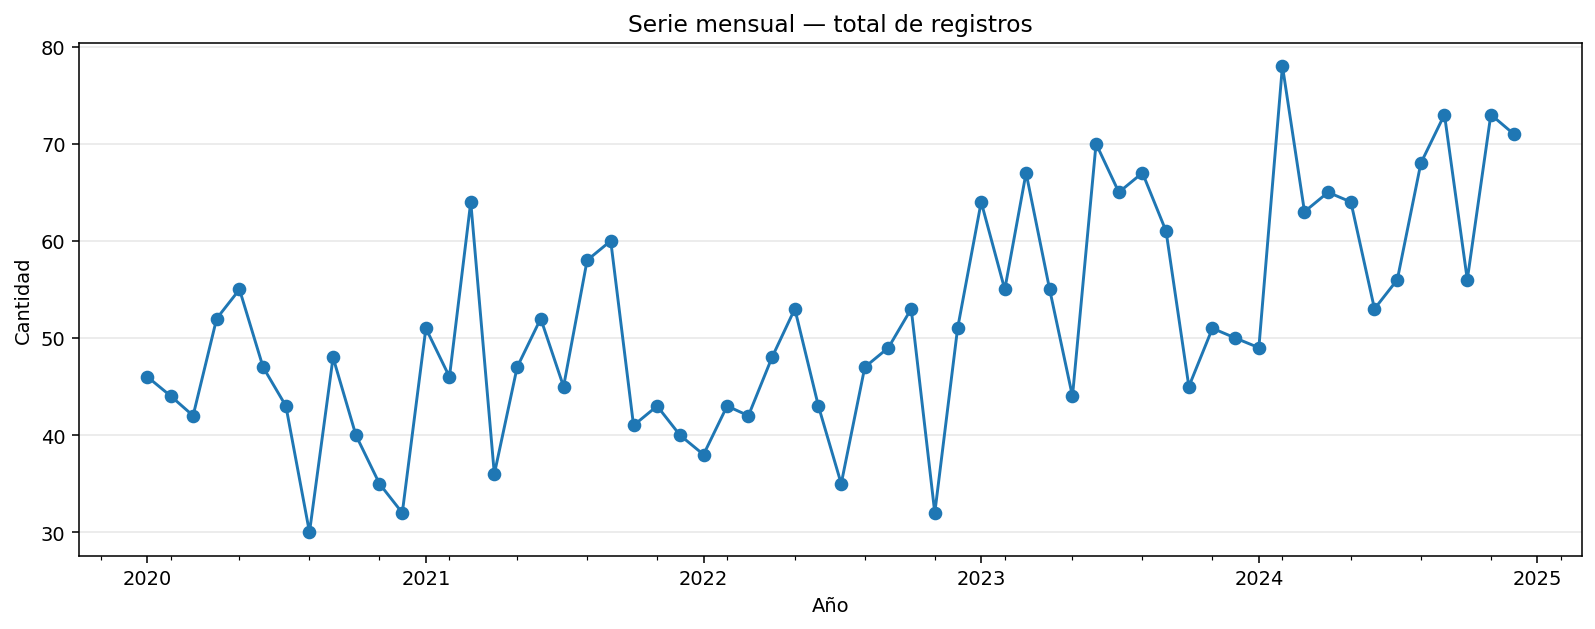

🖼️ Guardado: figs/serie_mensual_final_total.png


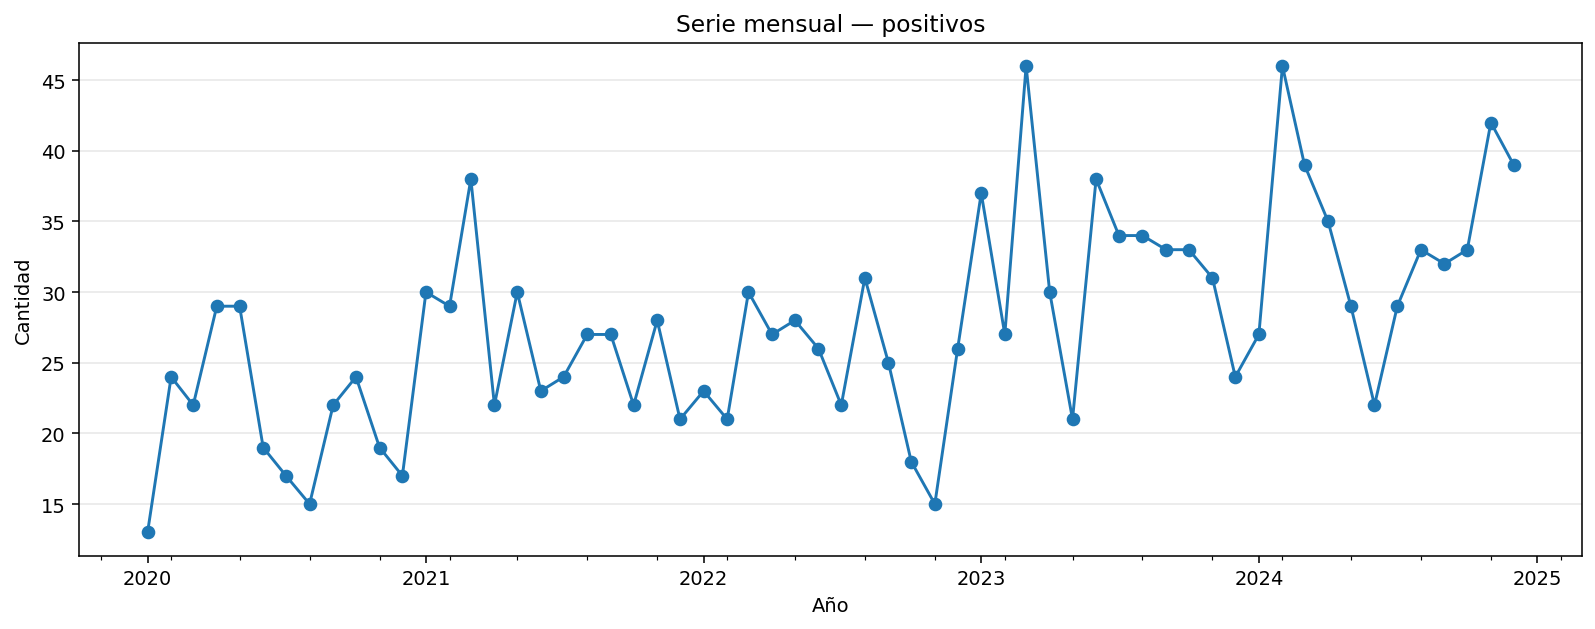

🖼️ Guardado: figs/serie_mensual_final_positivos.png


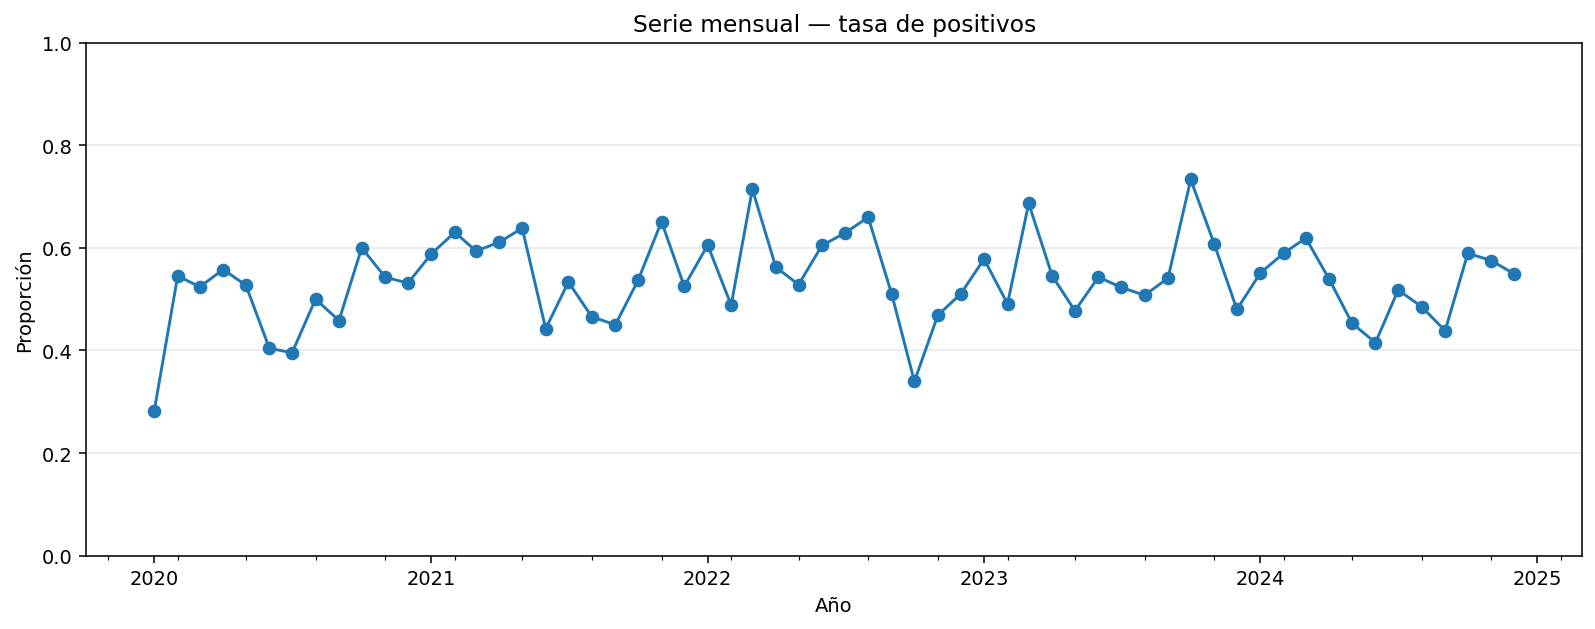

🖼️ Guardado: figs/serie_mensual_final_tasa.png

Listo. La celda no depende de que exista la columna 't' previamente: la crea siempre.


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

Path("outputs").mkdir(exist_ok=True)
Path("figs").mkdir(exist_ok=True)

# ---------- helpers mínimos ----------
def _find_col(df, candidates):
    import unicodedata
    def norm(s):
        s = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
        return s.casefold()
    m = {norm(c): c for c in df.columns}
    for cand in candidates:
        if norm(cand) in m:
            return m[norm(cand)]
    for col in df.columns:
        if any(norm(cand) in norm(col) for cand in candidates):
            return col
    raise KeyError(f"No se encontró ninguna de las columnas {candidates} en {list(df.columns)}")

def _ensure_fecha(df):
    """Devuelve un DF con columna 'fecha' válida (datetime64). Usa df_bt si existe."""
    if 'df_bt' in globals() and isinstance(df_bt, pd.DataFrame) and 'fecha' in df_bt.columns:
        base = df_bt.copy()
        # asegurar datetime
        base['fecha'] = pd.to_datetime(base['fecha'], errors='coerce')
        base = base.dropna(subset=['fecha'])
        return base

    if 'data' not in globals():
        raise RuntimeError("No encuentro ni df_bt ni data. Corré las celdas de carga/normalización.")

    if 'fecha' in data.columns:
        base = data.copy()
        base['fecha'] = pd.to_datetime(base['fecha'], errors='coerce')
        base = base.dropna(subset=['fecha'])
        return base

    # si no hay 'fecha', reconstruimos desde año/mes
    ANIO_COL = _find_col(data, ['anio','año','ANIO','AÑO'])
    MES_COL  = _find_col(data, ['mes','MES'])

    def _to_month(v):
        meses = {'ene':1,'enero':1,'feb':2,'febrero':2,'mar':3,'marzo':3,'abr':4,'abril':4,
                 'may':5,'mayo':5,'jun':6,'junio':6,'jul':7,'julio':7,'ago':8,'agosto':8,
                 'sep':9,'set':9,'sept':9,'septiembre':9,'oct':10,'octubre':10,
                 'nov':11,'noviembre':11,'dic':12,'diciembre':12}
        if pd.isna(v): return np.nan
        try:
            vv = int(v)
            if 1 <= vv <= 12: return vv
        except Exception:
            pass
        s = str(v).strip().lower().replace('.', '').replace(',', '')
        if s in meses: return meses[s]
        if len(s) >= 3 and s[:3] in meses: return meses[s[:3]]
        return np.nan

    anio = pd.to_numeric(data[ANIO_COL], errors='coerce').astype('Int64')
    mes  = data[MES_COL].map(_to_month).astype('Int64')
    base = data.assign(_anio=anio, _mes=mes).dropna(subset=['_anio','_mes']).copy()
    base['_anio'] = base['_anio'].astype(int)
    base['_mes']  = base['_mes'].astype(int)
    base['fecha'] = pd.to_datetime(dict(year=base['_anio'], month=base['_mes'], day=1), errors='coerce')
    base = base.dropna(subset=['fecha'])
    return base

# ---------- construir base temporal ----------
base = _ensure_fecha(globals())
TARGET_COL = None
try:
    TARGET_COL = _find_col(base, ['es_trata','target','label','y'])
except Exception:
    pass

# ---------- construir serie mensual con columnas estándar t / n (+ opcionales) ----------
serie = (
    base['fecha'].dt.to_period('M')
    .value_counts()
    .sort_index()
    .rename_axis('t')
    .reset_index(name='n')
)

if TARGET_COL is not None:
    pos = (
        base.loc[base[TARGET_COL].astype(int) == 1, 'fecha']
        .dt.to_period('M')
        .value_counts()
        .rename('n_pos')
    )
    serie = serie.merge(pos, left_on='t', right_index=True, how='left')
    serie['n_pos'] = serie['n_pos'].fillna(0).astype(int)
    serie['tasa_pos'] = (serie['n_pos'] / serie['n']).round(4)

# ---------- exportar CSV ----------
csv_path = "outputs/serie_mensual_final.csv"
serie.to_csv(csv_path, index=False)
print(f"✅ Guardado: {csv_path}")

# ---------- gráficos legibles ----------
import matplotlib.dates as mdates
x = pd.PeriodIndex(serie["t"]).to_timestamp(how="start")

# 1) Conteo total
plt.figure(figsize=(11.5, 4.6), dpi=140)
plt.plot(x, serie["n"].to_numpy(), marker="o", label="Registros por mes")
plt.title("Serie mensual — total de registros")
plt.xlabel("Año")
plt.ylabel("Cantidad")
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("figs/serie_mensual_final_total.png", dpi=150, bbox_inches="tight")
plt.show()
print("🖼️ Guardado: figs/serie_mensual_final_total.png")

# 2) Si hay target: positivos y tasa
if "n_pos" in serie.columns:
    # a) positivos por mes
    plt.figure(figsize=(11.5, 4.6), dpi=140)
    plt.plot(x, serie["n_pos"].to_numpy(), marker="o", label="Positivos (target=1) por mes")
    plt.title("Serie mensual — positivos")
    plt.xlabel("Año"); plt.ylabel("Cantidad")
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
    ax.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig("figs/serie_mensual_final_positivos.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("🖼️ Guardado: figs/serie_mensual_final_positivos.png")

    # b) tasa de positivos
    plt.figure(figsize=(11.5, 4.6), dpi=140)
    plt.plot(x, serie["tasa_pos"].to_numpy(), marker="o", label="Tasa de positivos")
    plt.title("Serie mensual — tasa de positivos")
    plt.xlabel("Año"); plt.ylabel("Proporción")
    plt.ylim(0, 1)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
    ax.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig("figs/serie_mensual_final_tasa.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("🖼️ Guardado: figs/serie_mensual_final_tasa.png")

print("\nListo. La celda no depende de que exista la columna 't' previamente: la crea siempre.")


##Resumen de nulos (antes → después)

In [59]:
#Rutas + lectura
df_cur = pd.read_csv(CURATED_PATH, low_memory=False, encoding="latin-1")
df_raw = pd.read_csv(RAW_PATH,     low_memory=False, encoding="latin-1")


In [60]:
from pathlib import Path
import pandas as pd

def resumen_nulos(df: pd.DataFrame, etiqueta: str) -> pd.DataFrame:
    s = df.isna().sum().sort_values(ascending=False)
    out = (
        s.to_frame("nulos")
         .assign(
             porcentaje=lambda x: (x["nulos"] / len(df)).round(4),
             dtype=lambda x: x.index.map(df.dtypes.astype(str).get),
             unicos=lambda x: x.index.map(lambda c: df[c].nunique(dropna=True))
         )
         .reset_index().rename(columns={"index": "columna"})
    )
    out.insert(0, "dataset", etiqueta)
    return out

nulos_antes   = resumen_nulos(df_raw, "antes")
nulos_despues = resumen_nulos(df_cur, "despues")

# Carpeta results (sirve tanto si corrés desde notebooks/ como desde la raíz)
RES = BASE.parent / "results" if BASE.name == "data" else BASE.parent.parent / "results"
RES.mkdir(parents=True, exist_ok=True)

nulos_antes.to_csv(RES / "nulos_antes.csv", index=False)
nulos_despues.to_csv(RES / "nulos_despues.csv", index=False)

print("OK ->", (RES / "nulos_antes.csv").resolve())
print("OK ->", (RES / "nulos_despues.csv").resolve())

# Vista rápida
display(nulos_antes.head(10))
display(nulos_despues.head(10))


OK -> C:\aprendizajeAutomatico\repo\deteccion_trata\deteccionTrata\results\nulos_antes.csv
OK -> C:\aprendizajeAutomatico\repo\deteccion_trata\deteccionTrata\results\nulos_despues.csv


,dataset,columna,nulos,porcentaje,dtype,unicos
0,antes,consultante_localidad,7079,0.9014,object,235
1,antes,consultante_como_conocio_la_linea,6810,0.8672,object,45
2,antes,consultante_nacionalidad,6464,0.8231,object,16
3,antes,consultante_provincia,3737,0.4759,object,24
4,antes,localidad,3227,0.4109,object,636
5,antes,provincia_indec_id,2760,0.3515,float64,24
6,antes,provincia,2759,0.3513,object,25
7,antes,hora_ingreso,2736,0.3484,object,1236
8,antes,consultante_edad_aparente,1184,0.1508,float64,88
9,antes,consultante_genero,1051,0.1338,object,14


,dataset,columna,nulos,porcentaje,dtype,unicos
0,despues,consultante_como_conocio_la_linea,6810,0.8672,object,45
1,despues,consultante_localidad,6389,0.8136,object,351
2,despues,consultante_nacionalidad,5940,0.7564,object,18
3,despues,localidad,3191,0.4063,object,637
4,despues,consultante_provincia,3154,0.4016,object,25
5,despues,provincia_indec_id,2760,0.3515,float64,24
6,despues,provincia,2738,0.3487,object,25
7,despues,consultante_edad_aparente,1184,0.1508,float64,88
8,despues,consultante_genero,1050,0.1337,object,14
9,despues,via_ingreso,617,0.0786,object,28


In [66]:
from pathlib import Path
FIGS, RESULTS = Path("figs"), Path("results")
sorted(p.name for p in FIGS.glob("*.png")), sorted(p.name for p in RESULTS.glob("*"))



(['calibracion_reliability.png',
  'calibration_Tuned-HistGradientBoostingClassifier.png',
  'cm_HGB_050.png',
  'cm_HGB_best.png',
  'cm_Tuned-LogisticRegression_050_c16.png',
  'cm_Tuned-LogisticRegression_opt_c16.png',
  'cm_cal_Tuned-HistGradientBoostingClassifier_050.png',
  'cm_cal_Tuned-HistGradientBoostingClassifier_opt.png',
  'esp_heatmap_prov_trim_intervenciones.png',
  'esp_heatmap_prov_trim_tasa.png',
  'esp_top_localidades_int.png',
  'esp_top_localidades_tasa.png',
  'esp_top_nacionalidades_int.png',
  'esp_top_nacionalidades_tasa.png',
  'esp_top_provincias_int.png',
  'esp_top_provincias_tasa.png',
  'pi_Tuned-HistGradientBoostingClassifier.png',
  'pr_HGB.png',
  'pr_Tuned-LogisticRegression_c16.png',
  'roc_HGB.png',
  'serie_mensual_consultante_provincia_positivos.png',
  'serie_mensual_consultante_provincia_tasa_min30.png',
  'serie_mensual_consultante_provincia_total.png',
  'serie_mensual_final_positivos.png',
  'serie_mensual_final_tasa.png',
  'serie_mensual_fi